# Word2Bits in TensorFlow

This notebook reproduces the results of the [Word2Bits paper][1] (Lam, 2018) by applying the least necessary amount of changes to the [basic word2vec example][2] from a [TensorFlow word tutorial][3].

 [1]: https://arxiv.org/abs/1803.05651 (Word2Bits-Quantized Word Vectors)
 [2]: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py
 [3]: https://www.tensorflow.org/tutorials/representation/word2vec (Vector Representations of Words)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import sys
import argparse
import random
from tempfile import gettempdir
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

from tensorflow.contrib.tensorboard.plugins import projector

# Give a folder path as an argument with '--log_dir' to save
# TensorBoard summaries. Default is a log folder in current directory.
current_path = os.path.dirname(os.path.realpath(sys.argv[0]))

parser = argparse.ArgumentParser()
parser.add_argument(
    '--log_dir',
    type=str,
    default=os.path.join(current_path, 'log'),
    help='The log directory for TensorBoard summaries.')
FLAGS, unparsed = parser.parse_known_args()

# Create the directory for TensorBoard variables if there is not.
if not os.path.exists(FLAGS.log_dir):
    os.makedirs(FLAGS.log_dir)

## **Step 1:** Download the data

In [2]:
url = 'http://mattmahoney.net/dc/'


# pylint: disable=redefined-outer-name
def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  local_filename = os.path.join('.', filename)
  if not os.path.exists(local_filename):
    local_filename, _ = urllib.request.urlretrieve(url + filename,
                                                   local_filename)
  statinfo = os.stat(local_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print(statinfo.st_size)
    raise Exception('Failed to verify ' + local_filename +
                    '. Can you get to it with a browser?')
  return local_filename


filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a list of strings.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words."""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data


vocabulary = read_data(filename)
print('Data size', len(vocabulary))

Data size 17005207


## **Step 2:** Build the dictionary and replace rare words with UNK token.

The Word2Bits paper [completely removes][1] rare words, whereas we replace them with a UNK token. The Word2Bits paper also keeps all words whose [frequency is larger than 5][2] and whose [frequency is larger than 1 when the hash table is rehashed][3], which amounts to a dictionary of [71,291 words][4]~~, whereas we only keep the 50,000 most frequent words in the dictionary~~.

 [1]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L398
 [2]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L225
 [3]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L248
 [4]: https://pastebin.com/PaYruqAu

In [4]:
vocabulary_size = len(set(vocabulary)) + 1


def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    if index == 0:  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary


# Filling 4 global variables:
# data - list of codes (integers from 0 to vocabulary_size-1).
#   This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# dictionary - map of words(strings) to their codes(integers)
# reverse_dictionary - maps codes(integers) to words(strings)
data, count, dictionary, reverse_dictionary = build_dataset(
    vocabulary, vocabulary_size)
del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 0], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


## **Step 3:** Function to generate a training batch for the skip-gram model.

The Word2Bits paper [computes gradients for every training sample][1], whereas we use minibatches. The Word2Bits paper also uses the CBOW model, whereas we use the Skip-gram model. The Word2Bits model also [subsamples the input data][2] with probability $1 - \frac{1\text{E}-4}{f(w_i)}$ (see [Mikolov13Distributed][3], Section 2.3), whereas we subsample the context words uniformly.

 [1]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L424
 [2]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L401
 [3]: http://papers.nips.cc/paper/5021-distributed-representations-of-words-andphrases (Distributed representations of words and phrases and their compositionality)

In [5]:
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
  if data_index + span > len(data):
    print('Finished an epoch.')
    data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[context_word]
    if data_index == len(data):
      buffer.extend(data[0:span])
      data_index = span
      print('Finished an epoch.')
    else:
      buffer.append(data[data_index])
      data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels


batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
reverse_dictionary[labels[i, 0]])

3084 originated -> 12 as
3084 originated -> 5239 anarchism
12 as -> 6 a
12 as -> 3084 originated
6 a -> 12 as
6 a -> 195 term
195 term -> 2 of
195 term -> 6 a


## **Step 4:** Build and train a skip-gram model.
The Word2Bits paper [uses negative sampling][1] (see [Mikolov13Distributed][2], Section 2.2), whereas we use the more general technique of [Noise Contrastive Estimation (NCE)][3]. ~~The Word2bits paper also [uses a learning rate of $0.05$ linearly decayed to $0.0001\cdot 0.05$][4]. The Word2bits paper also [quantizes the word embeddings][5].~~

 [1]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L456
 [2]: http://papers.nips.cc/paper/5021-distributed-representations-of-words-andphrases (Distributed representations of words and phrases and their compositionality)
 [3]: https://www.tensorflow.org/api_docs/python/tf/nn/nce_loss (tf.nn.nce_loss)
 [4]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L391
 [5]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L86

In [6]:
from math import ceil
batch_size = 128
embedding_size = 600  # Dimension of the embedding vector.
skip_window = 10  # How many words to consider left and right.
num_skips = 16  # How many times to reuse an input to generate a label.
num_sampled = 24  # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

num_epochs = 10
num_steps = int(ceil(num_epochs * len(data) / (batch_size // num_skips)))

graph = tf.Graph()

def quantize(x):
    return tf.sign(x) / 3

@tf.custom_gradient
def quantize_with_straight_through_gradient(x):
    return quantize(x), tf.identity

with graph.as_default():

  # Input data.
  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/gpu:0'):
    # Look up embeddings for inputs.
    with tf.name_scope('embeddings'):
      embeddings = tf.Variable(
          tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
      embed = tf.nn.embedding_lookup(embeddings, train_inputs)
      quantized_embed = quantize_with_straight_through_gradient(embed)


    # Construct the variables for the NCE loss
    with tf.name_scope('weights'):
      nce_weights = tf.Variable(
          tf.truncated_normal(
              [vocabulary_size, embedding_size],
              stddev=1.0 / math.sqrt(embedding_size)))
    with tf.name_scope('biases'):
      nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  # Explanation of the meaning of NCE loss:
  #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
  with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=quantized_embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

  # Add the loss value as a scalar to summary.
  tf.summary.scalar('loss', loss)

  # Construct the SGD optimizer using a learning rate of 1.0.
  with tf.name_scope('optimizer'):
    global_step = tf.Variable(0, name='global_step', trainable=False, dtype=tf.int32)
    increment_global_step_op = tf.assign(global_step, global_step+1)
    learning_rate = tf.math.maximum(0.05 * 0.0001, tf.train.polynomial_decay(0.05, global_step, num_steps, 0.0))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  quantized_embeddings = quantize(embeddings)
  normalized_embeddings = quantized_embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Merge all summaries.
  merged = tf.summary.merge_all()

  # Add variable initializer.
  init = tf.global_variables_initializer()

  # Create a saver.
  saver = tf.train.Saver()

## **Step 5**: Begin training.

In [7]:
with tf.Session(graph=graph) as session:
  # Open a writer to write summaries.
  writer = tf.summary.FileWriter(FLAGS.log_dir, session.graph)

  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # Define metadata variable.
    run_metadata = tf.RunMetadata()

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
    # Feed metadata variable to session for visualizing the graph in TensorBoard.
    _, summary, loss_val = session.run(
        [optimizer, merged, loss],
        feed_dict=feed_dict,
        run_metadata=run_metadata)
    session.run(increment_global_step_op)
    average_loss += loss_val

    # Add returned summaries to writer in each step.
    writer.add_summary(summary, step)
    # Add metadata to visualize the graph for the last run.
    if step == (num_steps - 1):
      writer.add_run_metadata(run_metadata, 'step%d' % step)

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ' (', 100 * step / num_steps, '%): ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 100000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = quantized_embeddings.eval()

  # Write corresponding labels for the embeddings.
  with open(FLAGS.log_dir + '/metadata.tsv', 'w') as f:
    for i in xrange(vocabulary_size):
      f.write(reverse_dictionary[i] + '\n')

  # Save the model for checkpoints.
  saver.save(session, os.path.join(FLAGS.log_dir, 'model.ckpt'))

  # Create a configuration for visualizing embeddings with the labels in TensorBoard.
  config = projector.ProjectorConfig()
  embedding_conf = config.embeddings.add()
  embedding_conf.tensor_name = embeddings.name
  embedding_conf.metadata_path = os.path.join(FLAGS.log_dir, 'metadata.tsv')
  projector.visualize_embeddings(writer, config)

writer.close()

Initialized
Average loss at step  0  ( 0.0 %):  130.918701171875
Nearest to if: faria, cows, serer, libracho, connexions, kaghan, bisonoric, bbp,
Nearest to s: diease, warneke, muzaffarabad, balcohistan, euer, itineraries, jalaali, matei,
Nearest to state: outweighing, kleng, bairoch, naradiya, shaikhs, dualis, demeanor, storied,
Nearest to their: hick, otrochestvo, vav, lombardi, democratici, relocation, vodafone, portrush,
Nearest to than: groundworks, datenschleuder, sake, dasycladus, neuradaceae, ferromagnet, lejos, paphlagonian,
Nearest to have: invoice, prinz, snuff, eldis, stoller, divisiveness, marlais, pol,
Nearest to time: rouan, imco, gelling, webopedia, sassamanash, gonal, vitreous, liben,
Nearest to only: carthay, wirehair, cloves, defmacro, sportbund, contrabassist, pantries, crebrisculpta,
Nearest to some: nasals, blunderbusses, nasty, steak, pocock, blatchford, kosuji, arndale,
Nearest to such: lambinowice, linndale, unhomogenized, swiftsure, toome, lately, retrospectiv

Average loss at step  160000  ( 0.752710616781 %):  45.11636421298981
Average loss at step  162000  ( 0.762119499491 %):  41.575103256344796
Average loss at step  164000  ( 0.7715283822 %):  41.41664415884018
Average loss at step  166000  ( 0.78093726491 %):  41.16609631788731
Average loss at step  168000  ( 0.79034614762 %):  41.40563467764854
Average loss at step  170000  ( 0.79975503033 %):  41.12967722821236
Average loss at step  172000  ( 0.80916391304 %):  41.47032332038879
Average loss at step  174000  ( 0.818572795749 %):  39.06159478414059
Average loss at step  176000  ( 0.827981678459 %):  40.867749578714374
Average loss at step  178000  ( 0.837390561169 %):  41.33778031218052
Average loss at step  180000  ( 0.846799443879 %):  40.38981896948815
Average loss at step  182000  ( 0.856208326588 %):  40.888542011022565
Average loss at step  184000  ( 0.865617209298 %):  39.09967956531048
Average loss at step  186000  ( 0.875026092008 %):  38.46637114524842
Average loss at step  1

Average loss at step  330000  ( 1.55246564711 %):  25.420175028443335
Average loss at step  332000  ( 1.56187452982 %):  25.567643474459647
Average loss at step  334000  ( 1.57128341253 %):  25.885277578115463
Average loss at step  336000  ( 1.58069229524 %):  24.79298955476284
Average loss at step  338000  ( 1.59010117795 %):  27.560213569641114
Average loss at step  340000  ( 1.59951006066 %):  25.690518144488333
Average loss at step  342000  ( 1.60891894337 %):  26.598883925676347
Average loss at step  344000  ( 1.61832782608 %):  23.51735489666462
Average loss at step  346000  ( 1.62773670879 %):  23.189474968791007
Average loss at step  348000  ( 1.6371455915 %):  26.962358106732367
Average loss at step  350000  ( 1.64655447421 %):  25.915999133348464
Average loss at step  352000  ( 1.65596335692 %):  23.15441625380516
Average loss at step  354000  ( 1.66537223963 %):  25.155547304868698
Average loss at step  356000  ( 1.67478112234 %):  25.595435438156127
Average loss at step  35

Average loss at step  502000  ( 2.36162956015 %):  18.489541161298753
Average loss at step  504000  ( 2.37103844286 %):  18.061029857873915
Average loss at step  506000  ( 2.38044732557 %):  18.1671000739336
Average loss at step  508000  ( 2.38985620828 %):  17.135119457006454
Average loss at step  510000  ( 2.39926509099 %):  18.874808790564536
Average loss at step  512000  ( 2.4086739737 %):  19.119128386080266
Average loss at step  514000  ( 2.41808285641 %):  17.133723593890668
Average loss at step  516000  ( 2.42749173912 %):  16.538714947223664
Average loss at step  518000  ( 2.43690062183 %):  17.618718350589276
Average loss at step  520000  ( 2.44630950454 %):  18.6296749805212
Average loss at step  522000  ( 2.45571838725 %):  18.02069441521168
Average loss at step  524000  ( 2.46512726996 %):  16.863573501467705
Average loss at step  526000  ( 2.47453615267 %):  16.991617492079733
Average loss at step  528000  ( 2.48394503538 %):  15.833192763328553
Average loss at step  5300

Average loss at step  700000  ( 3.29310894842 %):  13.909690537810325
Nearest to if: remaining, pope, network, whole, software, days, prince, analysis,
Nearest to s: pope, remaining, analysis, network, chemical, code, medical, prince,
Nearest to state: remaining, analysis, software, pope, network, interest, created, code,
Nearest to their: analysis, pope, remaining, created, code, software, interest, network,
Nearest to than: pope, remaining, analysis, created, code, structure, added, prince,
Nearest to have: pope, remaining, analysis, network, code, medical, software, interest,
Nearest to time: pope, remaining, analysis, code, medical, interest, network, mass,
Nearest to only: pope, analysis, remaining, network, chemical, code, attack, medical,
Nearest to some: pope, remaining, analysis, network, chemical, code, attack, medical,
Nearest to such: remaining, software, pope, prince, analysis, interest, network, birth,
Nearest to use: remaining, code, prince, pope, mass, medical, analysis

Average loss at step  858000  ( 4.03641068249 %):  12.352969624519348
Average loss at step  860000  ( 4.0458195652 %):  13.55866834652424
Average loss at step  862000  ( 4.05522844791 %):  12.492536093711854
Average loss at step  864000  ( 4.06463733062 %):  12.803387604475022
Average loss at step  866000  ( 4.07404621333 %):  14.095179793953896
Average loss at step  868000  ( 4.08345509604 %):  12.822056846737862
Average loss at step  870000  ( 4.09286397875 %):  12.777575809001922
Average loss at step  872000  ( 4.10227286146 %):  13.409080105900765
Average loss at step  874000  ( 4.11168174417 %):  13.665094699382783
Average loss at step  876000  ( 4.12109062688 %):  12.5249497448802
Average loss at step  878000  ( 4.13049950959 %):  12.935800551772118
Average loss at step  880000  ( 4.1399083923 %):  12.359116874337197
Average loss at step  882000  ( 4.14931727501 %):  13.856585252285004
Average loss at step  884000  ( 4.15872615771 %):  12.168533663153648
Average loss at step  886

Average loss at step  1014000  ( 4.77030353385 %):  10.951052697241307
Average loss at step  1016000  ( 4.77971241656 %):  12.283547314286231
Average loss at step  1018000  ( 4.78912129927 %):  12.274905449151992
Average loss at step  1020000  ( 4.79853018198 %):  11.132298421025276
Average loss at step  1022000  ( 4.80793906469 %):  11.769963583230972
Average loss at step  1024000  ( 4.8173479474 %):  12.104110442519188
Average loss at step  1026000  ( 4.82675683011 %):  13.976356394052505
Average loss at step  1028000  ( 4.83616571282 %):  12.221657687306404
Average loss at step  1030000  ( 4.84557459553 %):  13.121826640963555
Average loss at step  1032000  ( 4.85498347824 %):  11.657745432972908
Average loss at step  1034000  ( 4.86439236095 %):  9.765664198517799
Average loss at step  1036000  ( 4.87380124366 %):  10.987234153032302
Average loss at step  1038000  ( 4.88321012637 %):  11.254312340736389
Average loss at step  1040000  ( 4.89261900908 %):  11.06601576089859
Average l

Nearest to than: software, network, code, pope, structure, carried, episode, created,
Nearest to have: network, software, code, episode, medical, pope, analysis, light,
Nearest to time: code, network, software, medical, season, pope, analysis, light,
Nearest to only: network, code, pope, software, season, episode, medical, analysis,
Nearest to some: network, software, code, episode, medical, pope, analysis, light,
Nearest to such: software, iii, code, rules, episode, medical, pope, light,
Nearest to use: network, software, iii, medical, remaining, regular, pope, growing,
Nearest to four: pope, network, code, medical, software, growth, season, fair,
Nearest to as: code, software, network, medical, pope, analysis, attack, season,
Nearest to when: code, network, software, season, medical, pope, analysis, carried,
Nearest to states: software, code, medical, network, attack, season, pope, growth,
Nearest to they: software, code, network, episode, medical, pope, analysis, attack,
Average los

Average loss at step  1372000  ( 6.4544935389 %):  8.481944514155387
Average loss at step  1374000  ( 6.46390242161 %):  9.833924600362778
Average loss at step  1376000  ( 6.47331130432 %):  9.65121546435356
Average loss at step  1378000  ( 6.48272018703 %):  9.572012132048608
Average loss at step  1380000  ( 6.49212906974 %):  10.39713759803772
Average loss at step  1382000  ( 6.50153795245 %):  7.5175461978316305
Average loss at step  1384000  ( 6.51094683516 %):  9.981173717975617
Average loss at step  1386000  ( 6.52035571787 %):  10.270644675433635
Average loss at step  1388000  ( 6.52976460057 %):  9.534696612238884
Average loss at step  1390000  ( 6.53917348328 %):  12.073404901504517
Average loss at step  1392000  ( 6.54858236599 %):  10.426371735930443
Average loss at step  1394000  ( 6.5579912487 %):  10.872178151071072
Average loss at step  1396000  ( 6.56740013141 %):  9.999876247882844
Average loss at step  1398000  ( 6.57680901412 %):  10.41963978254795
Average loss at st

Average loss at step  1532000  ( 7.20720415568 %):  8.714607922077178
Average loss at step  1534000  ( 7.21661303839 %):  10.999306835174561
Average loss at step  1536000  ( 7.2260219211 %):  9.907290957272053
Average loss at step  1538000  ( 7.23543080381 %):  8.151528409838676
Average loss at step  1540000  ( 7.24483968652 %):  9.044472756505012
Average loss at step  1542000  ( 7.25424856923 %):  9.896620826244355
Average loss at step  1544000  ( 7.26365745194 %):  11.836343581974507
Average loss at step  1546000  ( 7.27306633465 %):  8.30880656683445
Average loss at step  1548000  ( 7.28247521736 %):  9.350034536898136
Average loss at step  1550000  ( 7.29188410007 %):  9.613950549125672
Average loss at step  1552000  ( 7.30129298278 %):  9.596818907737731
Average loss at step  1554000  ( 7.31070186549 %):  11.612789111971855
Average loss at step  1556000  ( 7.32011074819 %):  8.565597692847252
Average loss at step  1558000  ( 7.3295196309 %):  7.766248557031155
Average loss at step

Nearest to when: show, software, created, developed, code, medical, data, attack,
Nearest to states: attack, medical, house, character, society, pope, control, code,
Nearest to they: character, software, jewish, data, developed, attack, medical, show,
Average loss at step  1702000  ( 8.00695918601 %):  7.816216798961163
Average loss at step  1704000  ( 8.01636806872 %):  9.35524511885643
Average loss at step  1706000  ( 8.02577695143 %):  8.158765846848487
Average loss at step  1708000  ( 8.03518583414 %):  9.783819423675537
Average loss at step  1710000  ( 8.04459471685 %):  8.347512146472932
Average loss at step  1712000  ( 8.05400359956 %):  8.512263321757317
Average loss at step  1714000  ( 8.06341248227 %):  7.4207577209472655
Average loss at step  1716000  ( 8.07282136498 %):  10.266233489573002
Average loss at step  1718000  ( 8.08223024769 %):  10.937152949213981
Average loss at step  1720000  ( 8.0916391304 %):  10.320627343773841
Average loss at step  1722000  ( 8.10104801311

Average loss at step  1890000  ( 8.89139416073 %):  9.967513711571694
Average loss at step  1892000  ( 8.90080304343 %):  8.07459192597866
Average loss at step  1894000  ( 8.91021192614 %):  8.277085556268691
Average loss at step  1896000  ( 8.91962080885 %):  8.418977732539178
Average loss at step  1898000  ( 8.92902969156 %):  8.22957438135147
Average loss at step  1900000  ( 8.93843857427 %):  7.079026832580566
Nearest to if: degree, days, developed, created, software, off, control, data,
Nearest to s: developed, data, attack, medical, season, off, control, days,
Nearest to state: developed, degree, software, off, control, data, created, iii,
Nearest to their: developed, created, software, control, data, information, off, code,
Nearest to than: developed, data, created, control, structure, degree, down, certain,
Nearest to have: developed, control, degree, data, attack, created, software, house,
Nearest to time: developed, control, degree, data, attack, medical, created, information

Average loss at step  2050000  ( 9.64410477751 %):  8.604696661114692
Average loss at step  2052000  ( 9.65351366022 %):  8.272423833489418
Average loss at step  2054000  ( 9.66292254293 %):  8.604553902864456
Average loss at step  2056000  ( 9.67233142564 %):  8.75731944477558
Average loss at step  2058000  ( 9.68174030835 %):  8.333451039731502
Average loss at step  2060000  ( 9.69114919105 %):  7.9121053533554075
Average loss at step  2062000  ( 9.70055807376 %):  8.9540144713521
Average loss at step  2064000  ( 9.70996695647 %):  8.849168445706367
Average loss at step  2066000  ( 9.71937583918 %):  7.199216007113456
Average loss at step  2068000  ( 9.72878472189 %):  9.656947042047978
Average loss at step  2070000  ( 9.7381936046 %):  8.717333222627639
Average loss at step  2072000  ( 9.74760248731 %):  9.33766762983799
Average loss at step  2074000  ( 9.75701137002 %):  6.532108150482178
Average loss at step  2076000  ( 9.76642025273 %):  8.888229526162148
Average loss at step  20

Average loss at step  2212000  ( 10.406224277 %):  7.961596007704735
Average loss at step  2214000  ( 10.4156331597 %):  7.704144763231278
Average loss at step  2216000  ( 10.4250420424 %):  7.795777763009071
Average loss at step  2218000  ( 10.4344509251 %):  8.4564414768219
Average loss at step  2220000  ( 10.4438598078 %):  7.823519118070602
Average loss at step  2222000  ( 10.4532686905 %):  9.31439170062542
Average loss at step  2224000  ( 10.4626775733 %):  9.618037352919579
Average loss at step  2226000  ( 10.472086456 %):  8.939256516337394
Average loss at step  2228000  ( 10.4814953387 %):  8.74063723385334
Average loss at step  2230000  ( 10.4909042214 %):  9.108067167043686
Average loss at step  2232000  ( 10.5003131041 %):  9.843900066256523
Average loss at step  2234000  ( 10.5097219868 %):  8.578573617696762
Average loss at step  2236000  ( 10.5191308695 %):  8.76709854722023
Average loss at step  2238000  ( 10.5285397522 %):  9.240175078630447
Average loss at step  22400

Nearest to states: character, degree, days, built, off, house, given, control,
Nearest to they: off, itself, given, days, created, software, season, usually,
Average loss at step  2402000  ( 11.3000681344 %):  8.856552182078362
Average loss at step  2404000  ( 11.3094770171 %):  8.693031526446342
Average loss at step  2406000  ( 11.3188858998 %):  8.958742000460624
Average loss at step  2408000  ( 11.3282947826 %):  7.248287650942802
Average loss at step  2410000  ( 11.3377036653 %):  7.808703701853752
Average loss at step  2412000  ( 11.347112548 %):  7.1105439000725745
Average loss at step  2414000  ( 11.3565214307 %):  7.940583159208297
Average loss at step  2416000  ( 11.3659303134 %):  8.083687589168548
Average loss at step  2418000  ( 11.3753391961 %):  8.041924949645995
Average loss at step  2420000  ( 11.3847480788 %):  8.98877611041069
Average loss at step  2422000  ( 11.3941569615 %):  8.74503124499321
Average loss at step  2424000  ( 11.4035658442 %):  7.067257311820984
Aver

Average loss at step  2596000  ( 12.2127297573 %):  7.846226330816746
Average loss at step  2598000  ( 12.22213864 %):  7.933928352177143
Average loss at step  2600000  ( 12.2315475227 %):  7.31784912443161
Nearest to if: days, season, given, further, particular, itself, degree, off,
Nearest to s: season, days, given, further, present, built, particular, itself,
Nearest to state: season, given, further, days, itself, off, developed, particular,
Nearest to their: season, character, further, days, itself, take, off, software,
Nearest to than: season, days, itself, further, created, words, present, given,
Nearest to have: further, season, days, itself, given, usually, particular, control,
Nearest to time: season, days, given, further, particular, present, usually, itself,
Nearest to only: season, days, given, further, particular, present, usually, itself,
Nearest to some: further, season, days, itself, given, usually, particular, control,
Nearest to such: given, season, further, days, its

Average loss at step  2756000  ( 12.9654403741 %):  8.360780750751495
Average loss at step  2758000  ( 12.9748492568 %):  7.735980300426483
Average loss at step  2760000  ( 12.9842581395 %):  7.607888499975204
Average loss at step  2762000  ( 12.9936670222 %):  6.95552038371563
Average loss at step  2764000  ( 13.0030759049 %):  7.741819963335991
Average loss at step  2766000  ( 13.0124847876 %):  7.780369942069053
Average loss at step  2768000  ( 13.0218936703 %):  7.056849107801915
Average loss at step  2770000  ( 13.031302553 %):  8.847879329681396
Average loss at step  2772000  ( 13.0407114357 %):  7.185172327041626
Average loss at step  2774000  ( 13.0501203184 %):  6.805160848259926
Average loss at step  2776000  ( 13.0595292011 %):  7.005104156911373
Average loss at step  2778000  ( 13.0689380839 %):  7.700596534490585
Average loss at step  2780000  ( 13.0783469666 %):  10.77464029288292
Average loss at step  2782000  ( 13.0877558493 %):  7.957434224784374
Average loss at step  

Average loss at step  2914000  ( 13.7087421081 %):  7.419907765328884
Average loss at step  2916000  ( 13.7181509908 %):  7.650662584900856
Average loss at step  2918000  ( 13.7275598735 %):  9.072734756708146
Average loss at step  2920000  ( 13.7369687563 %):  6.7170188802480695
Average loss at step  2922000  ( 13.746377639 %):  6.748586713075638
Average loss at step  2924000  ( 13.7557865217 %):  8.480964112401008
Average loss at step  2926000  ( 13.7651954044 %):  7.371223251342774
Average loss at step  2928000  ( 13.7746042871 %):  6.836260099470615
Average loss at step  2930000  ( 13.7840131698 %):  7.178639424800873
Average loss at step  2932000  ( 13.7934220525 %):  7.146275711148977
Average loss at step  2934000  ( 13.8028309352 %):  8.029045695543289
Average loss at step  2936000  ( 13.8122398179 %):  7.316565047442913
Average loss at step  2938000  ( 13.8216487006 %):  7.90426628792286
Average loss at step  2940000  ( 13.8310575834 %):  6.953233737230301
Average loss at step 

Nearest to have: period, itself, given, body, very, last, further, days,
Nearest to time: given, period, itself, days, last, very, line, created,
Nearest to only: given, period, itself, days, last, very, line, created,
Nearest to some: period, itself, given, days, very, last, further, body,
Nearest to such: season, itself, period, body, last, very, higher, code,
Nearest to use: season, period, further, itself, last, character, words, take,
Nearest to four: period, given, days, last, west, further, itself, line,
Nearest to as: season, period, last, itself, days, very, character, large,
Nearest to when: given, period, last, itself, further, show, very, character,
Nearest to states: given, period, degree, days, itself, west, last, higher,
Nearest to they: given, season, period, created, body, words, very, last,
Average loss at step  3102000  ( 14.5931770828 %):  6.806885199308395
Average loss at step  3104000  ( 14.6025859656 %):  7.096375099182129
Average loss at step  3106000  ( 14.6119

Average loss at step  3278000  ( 15.4211587613 %):  6.821386803209782
Average loss at step  3280000  ( 15.430567644 %):  6.750753620743752
Average loss at step  3282000  ( 15.4399765267 %):  7.481066960811615
Average loss at step  3284000  ( 15.4493854094 %):  6.777741866350174
Average loss at step  3286000  ( 15.4587942921 %):  7.325744136512279
Average loss at step  3288000  ( 15.4682031748 %):  6.869182760953903
Average loss at step  3290000  ( 15.4776120576 %):  9.332522045016288
Average loss at step  3292000  ( 15.4870209403 %):  6.872395049810409
Average loss at step  3294000  ( 15.496429823 %):  6.884379696369171
Average loss at step  3296000  ( 15.5058387057 %):  6.688264366149903
Average loss at step  3298000  ( 15.5152475884 %):  7.632380158424377
Average loss at step  3300000  ( 15.5246564711 %):  6.661946276664734
Nearest to if: itself, days, period, given, show, life, body, large,
Nearest to s: itself, life, period, days, given, major, members, created,
Nearest to state: i

Average loss at step  3446000  ( 16.2115049089 %):  6.554782313168049
Average loss at step  3448000  ( 16.2209137916 %):  5.957823426663875
Average loss at step  3450000  ( 16.2303226743 %):  6.97107080745697
Average loss at step  3452000  ( 16.239731557 %):  6.811176147460937
Average loss at step  3454000  ( 16.2491404398 %):  6.078955420374871
Average loss at step  3456000  ( 16.2585493225 %):  8.068312098026276
Average loss at step  3458000  ( 16.2679582052 %):  6.905559074282646
Average loss at step  3460000  ( 16.2773670879 %):  6.609545444488526
Average loss at step  3462000  ( 16.2867759706 %):  7.25660444688797
Average loss at step  3464000  ( 16.2961848533 %):  6.987537410378456
Average loss at step  3466000  ( 16.305593736 %):  6.924410506010055
Average loss at step  3468000  ( 16.3150026187 %):  7.5758085799217225
Average loss at step  3470000  ( 16.3244115014 %):  6.663381465673447
Average loss at step  3472000  ( 16.3338203841 %):  6.4702963563203815
Average loss at step  

Average loss at step  3610000  ( 16.9830332911 %):  6.949617486715317
Average loss at step  3612000  ( 16.9924421738 %):  6.697126779556275
Average loss at step  3614000  ( 17.0018510565 %):  6.175569913625717
Average loss at step  3616000  ( 17.0112599392 %):  7.116904662132264
Average loss at step  3618000  ( 17.020668822 %):  6.0005476658940315
Average loss at step  3620000  ( 17.0300777047 %):  6.030495020866394
Average loss at step  3622000  ( 17.0394865874 %):  6.497866846561432
Average loss at step  3624000  ( 17.0488954701 %):  6.3574618704319
Average loss at step  3626000  ( 17.0583043528 %):  6.436736813306808
Average loss at step  3628000  ( 17.0677132355 %):  6.194096361815929
Average loss at step  3630000  ( 17.0771221182 %):  6.901600950360298
Average loss at step  3632000  ( 17.0865310009 %):  7.006634478926658
Average loss at step  3634000  ( 17.0959398836 %):  6.095364014744758
Average loss at step  3636000  ( 17.1053487663 %):  7.82954277330637
Average loss at step  3

Nearest to than: created, therefore, field, production, below, season, aircraft, thought,
Nearest to have: created, season, therefore, certain, code, life, second, below,
Nearest to time: itself, days, where, below, take, created, body, certain,
Nearest to only: days, code, itself, season, below, chief, line, degree,
Nearest to some: words, season, therefore, life, production, take, just, days,
Nearest to such: small, therefore, given, certain, regular, well, below, field,
Nearest to use: season, created, itself, words, particular, therefore, standard, code,
Nearest to four: days, created, itself, iii, second, given, code, remaining,
Nearest to as: thought, name, given, body, code, itself, second, life,
Nearest to when: must, season, thought, itself, life, show, take, well,
Nearest to states: season, code, degree, itself, line, words, attack, character,
Nearest to they: created, itself, higher, therefore, where, days, small, words,
Average loss at step  3802000  ( 17.8862860313 %):  6.

Average loss at step  3974000  ( 18.6954499443 %):  9.195099343538285
Average loss at step  3976000  ( 18.704858827 %):  6.145585825443268
Average loss at step  3978000  ( 18.7142677097 %):  7.589026005983353
Average loss at step  3980000  ( 18.7236765924 %):  6.79345978474617
Average loss at step  3982000  ( 18.7330854751 %):  7.2407993156313895
Average loss at step  3984000  ( 18.7424943578 %):  7.677694226145745
Average loss at step  3986000  ( 18.7519032406 %):  6.152676010727882
Average loss at step  3988000  ( 18.7613121233 %):  7.476980533599853
Average loss at step  3990000  ( 18.770721006 %):  8.025855912089348
Average loss at step  3992000  ( 18.7801298887 %):  7.052014951229095
Average loss at step  3994000  ( 18.7895387714 %):  6.152089122891426
Average loss at step  3996000  ( 18.7989476541 %):  6.626903180480003
Average loss at step  3998000  ( 18.8083565368 %):  9.167865141391754
Average loss at step  4000000  ( 18.8177654195 %):  7.575239803075791
Nearest to if: below, 

Average loss at step  4136000  ( 19.4575694438 %):  5.779865572333336
Average loss at step  4138000  ( 19.4669783265 %):  7.045087612628937
Average loss at step  4140000  ( 19.4763872092 %):  7.1099484648704525
Average loss at step  4142000  ( 19.4857960919 %):  6.383132336378098
Average loss at step  4144000  ( 19.4952049746 %):  6.344130532622337
Average loss at step  4146000  ( 19.5046138573 %):  6.619162089824677
Average loss at step  4148000  ( 19.51402274 %):  7.763711490392685
Average loss at step  4150000  ( 19.5234316228 %):  7.503839485824108
Average loss at step  4152000  ( 19.5328405055 %):  6.79715485394001
Average loss at step  4154000  ( 19.5422493882 %):  6.505255400300026
Average loss at step  4156000  ( 19.5516582709 %):  7.336543699264526
Average loss at step  4158000  ( 19.5610671536 %):  6.203495621263981
Average loss at step  4160000  ( 19.5704760363 %):  6.31612430793047
Average loss at step  4162000  ( 19.579884919 %):  6.368569603800774
Average loss at step  41

Nearest to states: india, degree, line, techniques, states, where, wide, days,
Nearest to they: certain, itself, body, days, degree, small, code, therefore,
Average loss at step  4302000  ( 20.2385067087 %):  5.933086614131928
Average loss at step  4304000  ( 20.2479155914 %):  6.084608244419098
Average loss at step  4306000  ( 20.2573244741 %):  7.2935996001958845
Average loss at step  4308000  ( 20.2667333568 %):  6.178232745409012
Average loss at step  4310000  ( 20.2761422395 %):  5.886533397436142
Average loss at step  4312000  ( 20.2855511222 %):  6.258158149123192
Average loss at step  4314000  ( 20.294960005 %):  6.212641547441483
Average loss at step  4316000  ( 20.3043688877 %):  7.410578240156173
Average loss at step  4318000  ( 20.3137777704 %):  6.207961144566536
Average loss at step  4320000  ( 20.3231866531 %):  6.9997966128587725
Average loss at step  4322000  ( 20.3325955358 %):  6.710028830230236
Average loss at step  4324000  ( 20.3420044185 %):  5.9908496391773225
A

Average loss at step  4496000  ( 21.1511683315 %):  6.891819563388824
Average loss at step  4498000  ( 21.1605772143 %):  7.1373876683712005
Average loss at step  4500000  ( 21.169986097 %):  6.885226339817047
Nearest to if: certain, line, aircraft, where, remaining, assembly, small, body,
Nearest to s: aircraft, days, where, major, code, season, via, body,
Nearest to state: remaining, aircraft, western, interest, front, building, increased, show,
Nearest to their: required, itself, natural, small, either, power, front, words,
Nearest to than: others, therefore, latter, itself, development, last, large, take,
Nearest to have: code, small, where, life, standard, front, required, given,
Nearest to time: line, small, body, given, chief, consider, certain, thought,
Nearest to only: consider, only, where, believe, days, created, end, small,
Nearest to some: itself, code, small, just, take, days, life, some,
Nearest to such: small, regular, therefore, possible, expressed, line, code, distinc

Average loss at step  4658000  ( 21.913287831 %):  6.6589399578571316
Average loss at step  4660000  ( 21.9226967137 %):  6.8548902146816255
Average loss at step  4662000  ( 21.9321055965 %):  6.222945134520531
Average loss at step  4664000  ( 21.9415144792 %):  5.631777531504631
Average loss at step  4666000  ( 21.9509233619 %):  5.641538413286209
Average loss at step  4668000  ( 21.9603322446 %):  5.950591257154942
Average loss at step  4670000  ( 21.9697411273 %):  6.572755995392799
Average loss at step  4672000  ( 21.97915001 %):  6.880088587284088
Average loss at step  4674000  ( 21.9885588927 %):  6.122344310879708
Average loss at step  4676000  ( 21.9979677754 %):  6.469712296426296
Average loss at step  4678000  ( 22.0073766581 %):  6.855716277003288
Average loss at step  4680000  ( 22.0167855408 %):  6.8574850261211395
Average loss at step  4682000  ( 22.0261944236 %):  6.032922975420952
Average loss at step  4684000  ( 22.0356033063 %):  5.6636655448675155
Average loss at ste

Average loss at step  4822000  ( 22.6848162132 %):  6.8041056693792346
Average loss at step  4824000  ( 22.6942250959 %):  4.857860983252525
Average loss at step  4826000  ( 22.7036339787 %):  5.609836240649224
Average loss at step  4828000  ( 22.7130428614 %):  5.679749963283538
Average loss at step  4830000  ( 22.7224517441 %):  5.897148657262325
Average loss at step  4832000  ( 22.7318606268 %):  6.731493681550026
Average loss at step  4834000  ( 22.7412695095 %):  5.847210943937301
Average loss at step  4836000  ( 22.7506783922 %):  5.781922572314739
Average loss at step  4838000  ( 22.7600872749 %):  5.582453607320786
Average loss at step  4840000  ( 22.7694961576 %):  6.560887664973736
Average loss at step  4842000  ( 22.7789050403 %):  6.4318197474479675
Average loss at step  4844000  ( 22.788313923 %):  5.704611710906029
Average loss at step  4846000  ( 22.7977228058 %):  6.387990146517754
Average loss at step  4848000  ( 22.8071316885 %):  5.605010089159012
Average loss at ste

Nearest to as: must, code, natural, where, along, death, large, especially,
Nearest to when: given, last, where, aircraft, rock, programs, provided, must,
Nearest to states: voice, consider, bank, units, continue, native, software, india,
Nearest to they: may, certain, especially, additional, itself, although, days, make,
Average loss at step  5002000  ( 23.5316156571 %):  6.089656217098236
Average loss at step  5004000  ( 23.5410245398 %):  6.338087412238121
Average loss at step  5006000  ( 23.5504334225 %):  6.4264276010990145
Average loss at step  5008000  ( 23.5598423052 %):  6.612934627890587
Average loss at step  5010000  ( 23.569251188 %):  6.486786299586296
Average loss at step  5012000  ( 23.5786600707 %):  6.507551609039306
Average loss at step  5014000  ( 23.5880689534 %):  6.012561710834503
Average loss at step  5016000  ( 23.5974778361 %):  5.788855622529984
Average loss at step  5018000  ( 23.6068867188 %):  5.827478735685348
Average loss at step  5020000  ( 23.6162956015

Average loss at step  5192000  ( 24.4254595145 %):  7.186557869791985
Average loss at step  5194000  ( 24.4348683973 %):  5.198827995717526
Average loss at step  5196000  ( 24.44427728 %):  6.181923789262772
Average loss at step  5198000  ( 24.4536861627 %):  5.5492818877100945
Average loss at step  5200000  ( 24.4630950454 %):  5.825879673004151
Nearest to if: where, certain, aircraft, assembly, object, standard, much, study,
Nearest to s: season, aircraft, given, well, remaining, continue, fully, last,
Nearest to state: given, aircraft, interest, therefore, western, carried, remaining, character,
Nearest to their: code, field, required, must, itself, where, either, body,
Nearest to than: may, mass, others, take, itself, where, aircraft, will,
Nearest to have: where, code, aircraft, small, season, itself, natural, given,
Nearest to time: where, line, given, season, small, particular, take, therefore,
Nearest to only: where, given, those, christianity, same, created, aircraft, show,
Ne

Average loss at step  5354000  ( 25.187579014 %):  6.19711815559864
Average loss at step  5356000  ( 25.1969878967 %):  5.929379478096962
Average loss at step  5358000  ( 25.2063967795 %):  5.71392940568924
Average loss at step  5360000  ( 25.2158056622 %):  5.894695609986782
Average loss at step  5362000  ( 25.2252145449 %):  5.713025839686393
Average loss at step  5364000  ( 25.2346234276 %):  5.827784701585769
Average loss at step  5366000  ( 25.2440323103 %):  7.209662781357765
Average loss at step  5368000  ( 25.253441193 %):  6.022925998926163
Average loss at step  5370000  ( 25.2628500757 %):  5.715157635569573
Average loss at step  5372000  ( 25.2722589584 %):  6.586164808750152
Average loss at step  5374000  ( 25.2816678411 %):  7.128582369148731
Average loss at step  5376000  ( 25.2910767238 %):  12.153571361660957
Average loss at step  5378000  ( 25.3004856065 %):  10.93792325401306
Average loss at step  5380000  ( 25.3098944893 %):  5.756830683469772
Average loss at step  5

Average loss at step  5516000  ( 25.9496985135 %):  6.4967266154289245
Average loss at step  5518000  ( 25.9591073962 %):  6.14265866780281
Average loss at step  5520000  ( 25.9685162789 %):  6.017531707584858
Average loss at step  5522000  ( 25.9779251617 %):  6.474569015860558
Average loss at step  5524000  ( 25.9873340444 %):  6.56181711602211
Average loss at step  5526000  ( 25.9967429271 %):  5.676483345746994
Average loss at step  5528000  ( 26.0061518098 %):  6.048675684809685
Average loss at step  5530000  ( 26.0155606925 %):  6.202442243933677
Average loss at step  5532000  ( 26.0249695752 %):  7.064067950606346
Average loss at step  5534000  ( 26.0343784579 %):  5.907426855802536
Average loss at step  5536000  ( 26.0437873406 %):  6.295569312810898
Average loss at step  5538000  ( 26.0531962233 %):  6.354642095565796
Average loss at step  5540000  ( 26.062605106 %):  6.419149859189988
Average loss at step  5542000  ( 26.0720139888 %):  6.073493694424629
Average loss at step  

Nearest to have: where, small, itself, except, however, especially, season, analysis,
Nearest to time: where, line, given, small, season, therefore, front, take,
Nearest to only: where, given, took, units, position, those, office, therefore,
Nearest to some: small, therefore, itself, take, where, via, others, usually,
Nearest to such: where, object, regular, therefore, position, code, distinction, small,
Nearest to use: standard, particular, season, extended, available, bill, except, largely,
Nearest to four: act, million, start, july, provided, over, degree, st,
Nearest to as: continue, season, where, along, standard, event, third, particular,
Nearest to when: given, programs, techniques, latter, israel, itself, appear, loss,
Nearest to states: india, voice, units, growth, office, consider, continue, third,
Nearest to they: itself, certain, where, particular, position, may, within, additional,
Average loss at step  5702000  ( 26.8247246055 %):  5.4565558977127075
Average loss at step 

Average loss at step  5874000  ( 27.6338885186 %):  5.697344374537468
Average loss at step  5876000  ( 27.6432974013 %):  5.846739046692848
Average loss at step  5878000  ( 27.652706284 %):  5.777273074448109
Average loss at step  5880000  ( 27.6621151667 %):  6.545957254290581
Average loss at step  5882000  ( 27.6715240494 %):  5.60389062589407
Average loss at step  5884000  ( 27.6809329321 %):  5.969514213681221
Average loss at step  5886000  ( 27.6903418148 %):  6.560053727388382
Average loss at step  5888000  ( 27.6997506975 %):  5.674716671526432
Average loss at step  5890000  ( 27.7091595802 %):  5.74795326757431
Average loss at step  5892000  ( 27.718568463 %):  5.694779908061028
Average loss at step  5894000  ( 27.7279773457 %):  6.348882553815842
Average loss at step  5896000  ( 27.7373862284 %):  5.505179420351982
Average loss at step  5898000  ( 27.7467951111 %):  5.879928886175156
Average loss at step  5900000  ( 27.7562039938 %):  5.550965886473656
Nearest to if: where, as

Average loss at step  6034000  ( 28.3865991354 %):  6.0565871142148975
Average loss at step  6036000  ( 28.3960080181 %):  5.137961660504341
Average loss at step  6038000  ( 28.4054169008 %):  6.79318405687809
Average loss at step  6040000  ( 28.4148257835 %):  5.4493706536889075
Average loss at step  6042000  ( 28.4242346662 %):  5.456141267061233
Average loss at step  6044000  ( 28.4336435489 %):  5.073532517969609
Average loss at step  6046000  ( 28.4430524316 %):  5.018283864021301
Average loss at step  6048000  ( 28.4524613143 %):  5.165564750432968
Average loss at step  6050000  ( 28.461870197 %):  5.236410205900669
Average loss at step  6052000  ( 28.4712790797 %):  6.57711646682024
Average loss at step  6054000  ( 28.4806879624 %):  5.283334354043007
Average loss at step  6056000  ( 28.4900968452 %):  6.150544355273246
Average loss at step  6058000  ( 28.4995057279 %):  5.668145091414452
Average loss at step  6060000  ( 28.5089146106 %):  5.88532615172863
Average loss at step  

Nearest to states: units, voice, india, growth, native, third, aircraft, continue,
Nearest to they: itself, where, particular, position, within, additional, will, ground,
Average loss at step  6202000  ( 29.176945283 %):  5.661419399261475
Average loss at step  6204000  ( 29.1863541657 %):  5.84666746532917
Average loss at step  6206000  ( 29.1957630484 %):  5.883782331705094
Average loss at step  6208000  ( 29.2051719311 %):  6.404981526732445
Average loss at step  6210000  ( 29.2145808138 %):  6.0986059875488285
Average loss at step  6212000  ( 29.2239896965 %):  6.803236278772354
Average loss at step  6214000  ( 29.2333985792 %):  5.41492123401165
Average loss at step  6216000  ( 29.2428074619 %):  5.437807071566581
Average loss at step  6218000  ( 29.2522163447 %):  5.609010440826416
Average loss at step  6220000  ( 29.2616252274 %):  6.045827608942986
Average loss at step  6222000  ( 29.2710341101 %):  5.844689362406731
Average loss at step  6224000  ( 29.2804429928 %):  6.1910991

Average loss at step  6394000  ( 30.0801980231 %):  5.399774305582047
Average loss at step  6396000  ( 30.0896069058 %):  5.866022699713707
Average loss at step  6398000  ( 30.0990157885 %):  5.738846116423607
Average loss at step  6400000  ( 30.1084246712 %):  5.2174817872047425
Nearest to if: where, aircraft, given, certain, assembly, body, degree, simply,
Nearest to s: continue, during, market, season, early, distinction, degree, aircraft,
Nearest to state: aircraft, typically, front, where, given, western, position, increased,
Nearest to their: itself, field, small, foreign, usually, must, tradition, charge,
Nearest to than: itself, take, mass, sex, recognized, period, played, numerous,
Nearest to have: small, except, where, effect, itself, central, will, mass,
Nearest to time: where, given, nothing, distinction, therefore, small, season, jewish,
Nearest to only: given, where, fact, mass, should, office, small, took,
Nearest to some: required, therefore, artist, call, where, condit

Average loss at step  6554000  ( 30.8329086399 %):  5.883623158693314
Average loss at step  6556000  ( 30.8423175226 %):  5.798604117631912
Average loss at step  6558000  ( 30.8517264053 %):  5.5836726403236385
Average loss at step  6560000  ( 30.861135288 %):  5.558422287702561
Average loss at step  6562000  ( 30.8705441707 %):  5.471338852882385
Average loss at step  6564000  ( 30.8799530534 %):  5.638093122601509
Average loss at step  6566000  ( 30.8893619361 %):  5.919951958119869
Average loss at step  6568000  ( 30.8987708189 %):  6.182136964917183
Average loss at step  6570000  ( 30.9081797016 %):  5.922272570610047
Average loss at step  6572000  ( 30.9175885843 %):  6.753768424510956
Average loss at step  6574000  ( 30.926997467 %):  6.003350353121758
Average loss at step  6576000  ( 30.9364063497 %):  5.901895770072937
Average loss at step  6578000  ( 30.9458152324 %):  5.924724711418152
Average loss at step  6580000  ( 30.9552241151 %):  5.690372764348984
Average loss at step 

Average loss at step  6714000  ( 31.5856192567 %):  6.022888965964317
Average loss at step  6716000  ( 31.5950281394 %):  5.622557253956795
Average loss at step  6718000  ( 31.6044370221 %):  5.268807929813862
Average loss at step  6720000  ( 31.6138459048 %):  5.09763409036398
Average loss at step  6722000  ( 31.6232547875 %):  4.861838873028756
Average loss at step  6724000  ( 31.6326636702 %):  5.164301273584366
Average loss at step  6726000  ( 31.6420725529 %):  6.0627651069164274
Average loss at step  6728000  ( 31.6514814356 %):  5.059509994387627
Average loss at step  6730000  ( 31.6608903183 %):  5.388066111803055
Average loss at step  6732000  ( 31.6702992011 %):  5.233695168972015
Average loss at step  6734000  ( 31.6797080838 %):  6.189131972551346
Average loss at step  6736000  ( 31.6891169665 %):  5.447205588400364
Average loss at step  6738000  ( 31.6985258492 %):  5.890914181470871
Average loss at step  6740000  ( 31.7079347319 %):  6.671113263487816
Average loss at step

Nearest to use: standard, bill, size, serial, programs, efforts, areas, respectively,
Nearest to four: john, last, recognized, estimated, tom, provided, single, rock,
Nearest to as: regular, support, body, almost, small, may, should, gods,
Nearest to when: given, seems, techniques, loss, therefore, already, woman, aircraft,
Nearest to states: india, voice, units, individual, aircraft, logic, county, native,
Nearest to they: itself, particular, continue, may, already, return, where, position,
Average loss at step  6902000  ( 32.4700542314 %):  5.733360657632351
Average loss at step  6904000  ( 32.4794631141 %):  5.385685701489448
Average loss at step  6906000  ( 32.4888719968 %):  5.180162681162357
Average loss at step  6908000  ( 32.4982808795 %):  5.901440076470375
Average loss at step  6910000  ( 32.5076897622 %):  5.6922959202528
Average loss at step  6912000  ( 32.5170986449 %):  5.789998536229134
Average loss at step  6914000  ( 32.5265075276 %):  5.534572701692581
Average loss at

Average loss at step  7086000  ( 33.3356714407 %):  6.432011145830154
Average loss at step  7088000  ( 33.3450803234 %):  5.554433809638024
Average loss at step  7090000  ( 33.3544892061 %):  5.23424055492878
Average loss at step  7092000  ( 33.3638980888 %):  6.194786763310432
Average loss at step  7094000  ( 33.3733069715 %):  6.2605925288200375
Average loss at step  7096000  ( 33.3827158542 %):  5.29129049706459
Average loss at step  7098000  ( 33.3921247369 %):  5.615359728097916
Average loss at step  7100000  ( 33.4015336197 %):  5.262886399745941
Nearest to if: rather, where, sound, played, must, degree, aircraft, given,
Nearest to s: market, continue, hours, prince, blood, remaining, ship, era,
Nearest to state: typically, where, given, cover, front, aircraft, attempted, western,
Nearest to their: foreign, small, must, field, mass, may, officials, analysis,
Nearest to than: period, take, played, levels, aircraft, mass, recognized, actual,
Nearest to have: where, programs, given,

Average loss at step  7246000  ( 34.0883820575 %):  5.731997810721397
Average loss at step  7248000  ( 34.0977909402 %):  5.741014709591865
Average loss at step  7250000  ( 34.1071998229 %):  5.994440151810646
Average loss at step  7252000  ( 34.1166087056 %):  5.6031314274072646
Average loss at step  7254000  ( 34.1260175883 %):  5.716496033191681
Average loss at step  7256000  ( 34.135426471 %):  5.706269513964653
Average loss at step  7258000  ( 34.1448353537 %):  5.739247683882713
Average loss at step  7260000  ( 34.1542442364 %):  5.502791907906532
Average loss at step  7262000  ( 34.1636531191 %):  5.46410691356659
Average loss at step  7264000  ( 34.1730620019 %):  7.257112387657165
Average loss at step  7266000  ( 34.1824708846 %):  6.020748983025551
Average loss at step  7268000  ( 34.1918797673 %):  5.213764990329742
Average loss at step  7270000  ( 34.20128865 %):  5.807233253598214
Average loss at step  7272000  ( 34.2106975327 %):  5.606212004184723
Average loss at step  7

Average loss at step  7406000  ( 34.8410926742 %):  6.495007581830024
Average loss at step  7408000  ( 34.850501557 %):  5.780488340258598
Average loss at step  7410000  ( 34.8599104397 %):  5.125912583231926
Average loss at step  7412000  ( 34.8693193224 %):  5.09088900411129
Average loss at step  7414000  ( 34.8787282051 %):  5.869524686038494
Average loss at step  7416000  ( 34.8881370878 %):  5.869843400895595
Average loss at step  7418000  ( 34.8975459705 %):  5.566318999171257
Average loss at step  7420000  ( 34.9069548532 %):  5.386495257973671
Average loss at step  7422000  ( 34.9163637359 %):  7.341318387269974
Average loss at step  7424000  ( 34.9257726186 %):  5.792564442038536
Average loss at step  7426000  ( 34.9351815013 %):  4.8937720926404
Average loss at step  7428000  ( 34.9445903841 %):  5.35461350184679
Average loss at step  7430000  ( 34.9539992668 %):  5.2938274919390675
Average loss at step  7432000  ( 34.9634081495 %):  6.859559263586998
Average loss at step  74

Nearest to their: foreign, may, officials, remain, must, either, prove, itself,
Nearest to than: period, played, take, sex, mass, anything, actual, times,
Nearest to have: where, has, may, should, itself, others, given, recognized,
Nearest to time: where, nothing, continue, carried, over, therefore, series, questions,
Nearest to only: given, lines, where, questions, round, mass, citizens, possible,
Nearest to some: period, itself, small, conditions, others, those, call, distinction,
Nearest to such: ring, therefore, finite, quality, code, object, distinction, where,
Nearest to use: bill, programs, serial, out, standard, size, areas, respectively,
Nearest to four: june, release, band, tell, published, million, ended, pilot,
Nearest to as: also, along, third, prince, with, prove, body, particular,
Nearest to when: given, appear, techniques, created, seems, loss, muslim, violence,
Nearest to states: voice, india, national, growth, units, grew, county, mass,
Nearest to they: may, continue,

Average loss at step  7770000  ( 36.5535093274 %):  5.787655989408493
Average loss at step  7772000  ( 36.5629182101 %):  5.568021572589874
Average loss at step  7774000  ( 36.5723270928 %):  5.42560706782341
Average loss at step  7776000  ( 36.5817359756 %):  5.708176513314247
Average loss at step  7778000  ( 36.5911448583 %):  5.344048216342926
Average loss at step  7780000  ( 36.600553741 %):  4.882096593141556
Average loss at step  7782000  ( 36.6099626237 %):  5.916977527499199
Average loss at step  7784000  ( 36.6193715064 %):  5.680605857491493
Average loss at step  7786000  ( 36.6287803891 %):  5.39996768951416
Average loss at step  7788000  ( 36.6381892718 %):  5.655581992924214
Average loss at step  7790000  ( 36.6475981545 %):  5.348231611847877
Average loss at step  7792000  ( 36.6570070372 %):  5.453318271160126
Average loss at step  7794000  ( 36.6664159199 %):  5.722512393116951
Average loss at step  7796000  ( 36.6758248027 %):  5.026075052857399
Average loss at step  7

Average loss at step  7932000  ( 37.3156288269 %):  5.812218367099762
Average loss at step  7934000  ( 37.3250377096 %):  5.147385684370994
Average loss at step  7936000  ( 37.3344465923 %):  4.812112891197205
Average loss at step  7938000  ( 37.343855475 %):  4.953696783065796
Average loss at step  7940000  ( 37.3532643578 %):  5.174407516658306
Average loss at step  7942000  ( 37.3626732405 %):  5.5801438035964965
Average loss at step  7944000  ( 37.3720821232 %):  5.315582275152207
Average loss at step  7946000  ( 37.3814910059 %):  5.3812196115851405
Average loss at step  7948000  ( 37.3908998886 %):  5.484989452242851
Average loss at step  7950000  ( 37.4003087713 %):  5.5963316842317585
Average loss at step  7952000  ( 37.409717654 %):  5.514869800567627
Average loss at step  7954000  ( 37.4191265367 %):  5.196553144574166
Average loss at step  7956000  ( 37.4285354194 %):  5.3243336186409
Average loss at step  7958000  ( 37.4379443021 %):  5.0452578512430195
Average loss at step

Average loss at step  8102000  ( 38.1153838572 %):  6.731152781486511
Average loss at step  8104000  ( 38.12479274 %):  5.773899795293808
Average loss at step  8106000  ( 38.1342016227 %):  6.143499821662902
Average loss at step  8108000  ( 38.1436105054 %):  5.503630695998669
Average loss at step  8110000  ( 38.1530193881 %):  6.285727042675019
Average loss at step  8112000  ( 38.1624282708 %):  5.913785557210446
Average loss at step  8114000  ( 38.1718371535 %):  5.913083864569664
Average loss at step  8116000  ( 38.1812460362 %):  6.140662088751793
Average loss at step  8118000  ( 38.1906549189 %):  6.37452026438713
Average loss at step  8120000  ( 38.2000638016 %):  6.26629530274868
Average loss at step  8122000  ( 38.2094726843 %):  6.409265490412712
Average loss at step  8124000  ( 38.2188815671 %):  6.371813110113144
Average loss at step  8126000  ( 38.2282904498 %):  6.169332581520081
Average loss at step  8128000  ( 38.2376993325 %):  6.101981146812439
Average loss at step  81

Average loss at step  8300000  ( 39.0468632455 %):  6.166008653759956
Nearest to if: where, should, sound, rather, must, will, given, do,
Nearest to s: market, continue, blood, short, position, champion, against, development,
Nearest to state: typically, given, where, aircraft, cover, western, attempted, substances,
Nearest to their: foreign, prove, tradition, must, genetic, officials, together, all,
Nearest to than: period, take, important, systems, played, levels, mass, blues,
Nearest to have: has, continue, should, where, aircraft, itself, night, all,
Nearest to time: body, where, series, season, continue, over, typically, wide,
Nearest to only: where, given, lines, same, questions, round, possible, citizens,
Nearest to some: period, others, indigenous, individual, support, call, era, artist,
Nearest to such: code, position, ring, distinction, all, quality, therefore, where,
Nearest to use: bill, standard, heavily, logic, programs, serial, out, areas,
Nearest to four: attractive, ar

Average loss at step  8462000  ( 39.808982745 %):  6.500917221426964
Average loss at step  8464000  ( 39.8183916277 %):  6.0587453393936155
Average loss at step  8466000  ( 39.8278005104 %):  6.374689946472645
Average loss at step  8468000  ( 39.8372093931 %):  5.843799124479294
Average loss at step  8470000  ( 39.8466182758 %):  6.386441578149795
Average loss at step  8472000  ( 39.8560271586 %):  5.339126852869987
Average loss at step  8474000  ( 39.8654360413 %):  5.9724459019899365
Average loss at step  8476000  ( 39.874844924 %):  5.4888577154278755
Average loss at step  8478000  ( 39.8842538067 %):  4.965661281347275
Average loss at step  8480000  ( 39.8936626894 %):  5.693325509548187
Average loss at step  8482000  ( 39.9030715721 %):  5.850769715428353
Average loss at step  8484000  ( 39.9124804548 %):  5.498749400138855
Average loss at step  8486000  ( 39.9218893375 %):  5.720275481104851
Average loss at step  8488000  ( 39.9312982202 %):  5.7655509129762645
Average loss at st

Average loss at step  8622000  ( 40.5616933618 %):  5.816568587064743
Average loss at step  8624000  ( 40.5711022445 %):  6.441352031826973
Average loss at step  8626000  ( 40.5805111272 %):  6.081606678724289
Average loss at step  8628000  ( 40.5899200099 %):  5.901461727619171
Average loss at step  8630000  ( 40.5993288926 %):  5.454574858009815
Average loss at step  8632000  ( 40.6087377753 %):  5.33284095710516
Average loss at step  8634000  ( 40.618146658 %):  5.960560690134764
Average loss at step  8636000  ( 40.6275555408 %):  5.65752014040947
Average loss at step  8638000  ( 40.6369644235 %):  6.165229445815086
Average loss at step  8640000  ( 40.6463733062 %):  6.099956490397453
Average loss at step  8642000  ( 40.6557821889 %):  6.239283932447433
Average loss at step  8644000  ( 40.6651910716 %):  5.548717979550362
Average loss at step  8646000  ( 40.6745999543 %):  5.280171789050102
Average loss at step  8648000  ( 40.684008837 %):  5.221134383141995
Average loss at step  86

Nearest to as: with, prince, ring, regular, term, might, nearly, aircraft,
Nearest to when: given, techniques, may, down, caesar, seems, took, israel,
Nearest to states: national, india, county, grew, units, voice, main, month,
Nearest to they: continue, made, may, particular, days, created, appear, when,
Average loss at step  8802000  ( 41.4084928057 %):  5.428960208177567
Average loss at step  8804000  ( 41.4179016884 %):  5.316112690925598
Average loss at step  8806000  ( 41.4273105711 %):  5.20967957597971
Average loss at step  8808000  ( 41.4367194538 %):  4.865793860137463
Average loss at step  8810000  ( 41.4461283365 %):  5.073725272893905
Average loss at step  8812000  ( 41.4555372192 %):  4.664036486804485
Average loss at step  8814000  ( 41.4649461019 %):  5.550723083913327
Average loss at step  8816000  ( 41.4743549846 %):  5.0997955393791194
Average loss at step  8818000  ( 41.4837638673 %):  5.8963437416553495
Average loss at step  8820000  ( 41.4931727501 %):  5.84182535

Average loss at step  8992000  ( 42.3023366631 %):  4.373142469882965
Average loss at step  8994000  ( 42.3117455458 %):  5.3394098041653635
Average loss at step  8996000  ( 42.3211544285 %):  5.061026598453521
Average loss at step  8998000  ( 42.3305633112 %):  5.559573434233665
Average loss at step  9000000  ( 42.3399721939 %):  4.967835144281388
Nearest to if: sound, where, should, do, must, event, given, so,
Nearest to s: remaining, against, period, position, aircraft, given, continue, line,
Nearest to state: given, typically, aircraft, cover, over, attempted, where, generally,
Nearest to their: castro, foreign, take, prove, may, genetic, tradition, must,
Nearest to than: period, systems, take, important, form, itself, levels, numerous,
Nearest to have: has, however, continue, front, mass, over, same, given,
Nearest to time: series, where, body, number, claimed, conditions, lines, continue,
Nearest to only: where, same, given, lines, possible, questions, mass, citizens,
Nearest to 

Average loss at step  9154000  ( 43.0644561626 %):  5.04196650326252
Average loss at step  9156000  ( 43.0738650453 %):  5.656007960915566
Average loss at step  9158000  ( 43.083273928 %):  7.547696909427643
Average loss at step  9160000  ( 43.0926828107 %):  5.377168190062046
Average loss at step  9162000  ( 43.1020916934 %):  5.320747785806656
Average loss at step  9164000  ( 43.1115005761 %):  5.12413527917862
Average loss at step  9166000  ( 43.1209094588 %):  5.727225117444992
Average loss at step  9168000  ( 43.1303183415 %):  5.109060318231583
Average loss at step  9170000  ( 43.1397272243 %):  5.420070826649666
Average loss at step  9172000  ( 43.149136107 %):  6.06331878054142
Average loss at step  9174000  ( 43.1585449897 %):  5.185466174602508
Average loss at step  9176000  ( 43.1679538724 %):  5.680626154065132
Average loss at step  9178000  ( 43.1773627551 %):  5.213715916395187
Average loss at step  9180000  ( 43.1867716378 %):  5.437341834902764
Average loss at step  918

Average loss at step  9316000  ( 43.8265756621 %):  5.454628499269486
Average loss at step  9318000  ( 43.8359845448 %):  5.036241347432137
Average loss at step  9320000  ( 43.8453934275 %):  5.2182505369186405
Average loss at step  9322000  ( 43.8548023102 %):  5.150238633155823
Average loss at step  9324000  ( 43.8642111929 %):  5.486851509034634
Average loss at step  9326000  ( 43.8736200756 %):  5.870829949140549
Average loss at step  9328000  ( 43.8830289583 %):  5.502526654958725
Average loss at step  9330000  ( 43.892437841 %):  5.16621016228199
Average loss at step  9332000  ( 43.9018467237 %):  5.400633990764618
Average loss at step  9334000  ( 43.9112556065 %):  5.378282959580422
Average loss at step  9336000  ( 43.9206644892 %):  5.074838863372802
Average loss at step  9338000  ( 43.9300733719 %):  5.174147594928741
Average loss at step  9340000  ( 43.9394822546 %):  5.0322248986959455
Average loss at step  9342000  ( 43.9488911373 %):  5.529080509543419
Average loss at step

Nearest to have: has, itself, over, shared, levels, will, continue, therefore,
Nearest to time: abandoned, body, number, truth, came, typically, underground, where,
Nearest to only: given, same, where, lines, an, questions, therefore, possible,
Nearest to some: others, period, those, notation, also, support, recognition, individual,
Nearest to such: where, finite, ring, quality, important, distinction, code, position,
Nearest to use: make, standard, size, most, try, respectively, extended, bill,
Nearest to four: from, henry, emerged, july, arrow, darwin, mary, beginning,
Nearest to as: with, from, also, when, ring, by, whose, has,
Nearest to when: given, likewise, fire, caesar, down, israel, techniques, awarded,
Nearest to states: india, county, units, national, member, provided, growth, aircraft,
Nearest to they: days, created, itself, continue, when, their, may, gods,
Average loss at step  9502000  ( 44.7016017541 %):  4.64954654109478
Average loss at step  9504000  ( 44.7110106368 %

Average loss at step  9676000  ( 45.5201745498 %):  5.560851103544235
Average loss at step  9678000  ( 45.5295834325 %):  4.975746906876564
Average loss at step  9680000  ( 45.5389923152 %):  5.420732660412789
Average loss at step  9682000  ( 45.548401198 %):  5.629015370368958
Average loss at step  9684000  ( 45.5578100807 %):  4.981972013831139
Average loss at step  9686000  ( 45.5672189634 %):  4.917955670714378
Average loss at step  9688000  ( 45.5766278461 %):  4.827160150766373
Average loss at step  9690000  ( 45.5860367288 %):  5.190399523973465
Average loss at step  9692000  ( 45.5954456115 %):  4.701332983672619
Average loss at step  9694000  ( 45.6048544942 %):  5.466683690905571
Average loss at step  9696000  ( 45.6142633769 %):  5.549534951269627
Average loss at step  9698000  ( 45.6236722596 %):  4.747824469923973
Average loss at step  9700000  ( 45.6330811423 %):  4.817715006470681
Nearest to if: sound, where, should, rather, must, so, formula, do,
Nearest to s: by, with,

Average loss at step  9838000  ( 46.2822940493 %):  5.151279168725014
Average loss at step  9840000  ( 46.291702932 %):  5.680862961053848
Average loss at step  9842000  ( 46.3011118147 %):  5.245774024844169
Average loss at step  9844000  ( 46.3105206974 %):  5.72447388613224
Average loss at step  9846000  ( 46.3199295802 %):  5.124598343014717
Average loss at step  9848000  ( 46.3293384629 %):  5.229924928545952
Average loss at step  9850000  ( 46.3387473456 %):  5.08981748855114
Average loss at step  9852000  ( 46.3481562283 %):  5.265100057125092
Average loss at step  9854000  ( 46.357565111 %):  5.169884479403496
Average loss at step  9856000  ( 46.3669739937 %):  5.388227196455002
Average loss at step  9858000  ( 46.3763828764 %):  5.000126493752003
Average loss at step  9860000  ( 46.3857917591 %):  6.008642365574837
Average loss at step  9862000  ( 46.3952006418 %):  4.585074465990067
Average loss at step  9864000  ( 46.4046095245 %):  5.1112227922677995
Average loss at step  9

Average loss at step  10002000  ( 47.0538224315 %):  4.779873766422272
Average loss at step  10004000  ( 47.0632313142 %):  5.234797025322914
Average loss at step  10006000  ( 47.0726401969 %):  5.112077478766441
Average loss at step  10008000  ( 47.0820490796 %):  5.215924002408982
Average loss at step  10010000  ( 47.0914579624 %):  4.985159149169922
Average loss at step  10012000  ( 47.1008668451 %):  4.551495754122734
Average loss at step  10014000  ( 47.1102757278 %):  7.223590326666832
Average loss at step  10016000  ( 47.1196846105 %):  5.938363821268082
Average loss at step  10018000  ( 47.1290934932 %):  5.15735463154316
Average loss at step  10020000  ( 47.1385023759 %):  4.813417381346226
Average loss at step  10022000  ( 47.1479112586 %):  4.473160013020038
Average loss at step  10024000  ( 47.1573201413 %):  5.648364778757095
Average loss at step  10026000  ( 47.166729024 %):  3.8258705345988275
Average loss at step  10028000  ( 47.1761379067 %):  4.9475500381588935
Averag

Average loss at step  10198000  ( 47.9758929371 %):  5.452989320099354
Average loss at step  10200000  ( 47.9853018198 %):  6.160939464092254
Nearest to if: sound, so, where, should, do, stock, greater, rather,
Nearest to s: developed, supreme, from, short, market, remaining, foreign, development,
Nearest to state: over, attempted, given, aircraft, increased, typically, where, generally,
Nearest to their: these, findings, itself, prove, take, extent, reform, outlined,
Nearest to than: period, numerous, sex, levels, therefore, take, itself, whole,
Nearest to have: has, over, levels, therefore, will, however, continue, should,
Nearest to time: abandoned, number, body, lines, recognized, extended, where, claimed,
Nearest to only: where, given, marriage, same, questions, lines, multi, possible,
Nearest to some: others, period, notation, over, those, showed, support, call,
Nearest to such: therefore, finite, ring, case, all, quality, object, where,
Nearest to use: mass, effective, make, log

Average loss at step  10358000  ( 48.7286035539 %):  5.516929508328438
Average loss at step  10360000  ( 48.7380124366 %):  5.613348827362061
Average loss at step  10362000  ( 48.7474213193 %):  5.454828352093696
Average loss at step  10364000  ( 48.756830202 %):  5.3888652995824815
Average loss at step  10366000  ( 48.7662390847 %):  6.7020507839918135
Average loss at step  10368000  ( 48.7756479674 %):  4.92974230837822
Average loss at step  10370000  ( 48.7850568501 %):  5.321886842250824
Average loss at step  10372000  ( 48.7944657328 %):  5.0658002164363864
Average loss at step  10374000  ( 48.8038746155 %):  7.162878642439842
Average loss at step  10376000  ( 48.8132834982 %):  5.743691949129104
Average loss at step  10378000  ( 48.822692381 %):  5.588174709320068
Average loss at step  10380000  ( 48.8321012637 %):  5.344548083662986
Average loss at step  10382000  ( 48.8415101464 %):  5.39283684784174
Average loss at step  10384000  ( 48.8509190291 %):  5.704261283159256
Average

Average loss at step  10516000  ( 49.4719052879 %):  5.946904895305633
Average loss at step  10518000  ( 49.4813141706 %):  5.421434750676155
Average loss at step  10520000  ( 49.4907230533 %):  5.074933050870896
Average loss at step  10522000  ( 49.5001319361 %):  5.004552863955498
Average loss at step  10524000  ( 49.5095408188 %):  5.96621696460247
Average loss at step  10526000  ( 49.5189497015 %):  5.8602557140588765
Average loss at step  10528000  ( 49.5283585842 %):  5.60332845646143
Average loss at step  10530000  ( 49.5377674669 %):  5.213479364395142
Average loss at step  10532000  ( 49.5471763496 %):  5.306290656328201
Average loss at step  10534000  ( 49.5565852323 %):  5.376366972625256
Average loss at step  10536000  ( 49.565994115 %):  5.011512587070465
Average loss at step  10538000  ( 49.5754029977 %):  4.973031852602959
Average loss at step  10540000  ( 49.5848118804 %):  5.643758120656013
Average loss at step  10542000  ( 49.5942207632 %):  5.166688344359398
Average 

Nearest to than: numerous, period, sex, levels, therefore, blues, wild, take,
Nearest to have: has, over, levels, however, grew, therefore, experience, will,
Nearest to time: number, lines, abandoned, body, recognized, northeast, pronounced, where,
Nearest to only: where, given, evidence, notation, lines, possible, hold, line,
Nearest to some: notation, conditions, temperate, period, also, support, even, those,
Nearest to such: finite, therefore, well, quality, where, those, ring, despite,
Nearest to use: with, effective, bill, mass, make, logic, seen, standard,
Nearest to four: june, beauty, jose, ottoman, hours, emerged, january, mm,
Nearest to as: with, from, also, ring, by, where, has, organisms,
Nearest to when: may, likewise, techniques, extended, itself, attached, given, down,
Nearest to states: india, county, voice, main, growth, units, citizens, national,
Nearest to they: when, their, itself, continue, particular, days, may, gibraltar,
Average loss at step  10702000  ( 50.3469

Average loss at step  10872000  ( 51.1466864103 %):  5.106167259216309
Average loss at step  10874000  ( 51.156095293 %):  5.813680560171604
Average loss at step  10876000  ( 51.1655041757 %):  5.850966207623482
Average loss at step  10878000  ( 51.1749130584 %):  5.6192763358354565
Average loss at step  10880000  ( 51.1843219411 %):  5.012912356734276
Average loss at step  10882000  ( 51.1937308238 %):  4.82060383605957
Average loss at step  10884000  ( 51.2031397065 %):  4.953727629065513
Average loss at step  10886000  ( 51.2125485892 %):  5.720665974259377
Average loss at step  10888000  ( 51.2219574719 %):  5.692838078260421
Average loss at step  10890000  ( 51.2313663547 %):  5.3028180121183395
Average loss at step  10892000  ( 51.2407752374 %):  5.180428776621818
Average loss at step  10894000  ( 51.2501841201 %):  4.906549018740654
Average loss at step  10896000  ( 51.2595930028 %):  4.846900252938271
Average loss at step  10898000  ( 51.2690018855 %):  4.67127806699276
Average

Average loss at step  11032000  ( 51.899397027 %):  4.945284354090691
Average loss at step  11034000  ( 51.9088059098 %):  5.624772168517112
Average loss at step  11036000  ( 51.9182147925 %):  5.415084492087364
Average loss at step  11038000  ( 51.9276236752 %):  4.949280686974525
Average loss at step  11040000  ( 51.9370325579 %):  5.165984268188477
Average loss at step  11042000  ( 51.9464414406 %):  5.122060551285744
Average loss at step  11044000  ( 51.9558503233 %):  4.476396139860153
Average loss at step  11046000  ( 51.965259206 %):  5.553188688337803
Average loss at step  11048000  ( 51.9746680887 %):  5.1872759417295455
Average loss at step  11050000  ( 51.9840769714 %):  5.30164553976059
Average loss at step  11052000  ( 51.9934858541 %):  5.302201603651047
Average loss at step  11054000  ( 52.0028947369 %):  5.58363335287571
Average loss at step  11056000  ( 52.0123036196 %):  5.419788523316384
Average loss at step  11058000  ( 52.0217125023 %):  5.172231704950333
Average l

Nearest to states: india, national, provided, county, support, growth, voice, units,
Nearest to they: their, itself, continue, when, moral, may, where, particular,
Average loss at step  11202000  ( 52.6991520574 %):  4.4322925542593
Average loss at step  11204000  ( 52.7085609401 %):  4.997194581031799
Average loss at step  11206000  ( 52.7179698228 %):  5.077499023199081
Average loss at step  11208000  ( 52.7273787055 %):  5.011759392142296
Average loss at step  11210000  ( 52.7367875882 %):  5.304377763748169
Average loss at step  11212000  ( 52.7461964709 %):  5.092403330683708
Average loss at step  11214000  ( 52.7556053536 %):  4.828737167477608
Average loss at step  11216000  ( 52.7650142363 %):  4.760216230392456
Average loss at step  11218000  ( 52.7744231191 %):  5.6519158996343615
Average loss at step  11220000  ( 52.7838320018 %):  5.008477910637856
Average loss at step  11222000  ( 52.7932408845 %):  4.919964893579483
Average loss at step  11224000  ( 52.8026497672 %):  5.5

Average loss at step  11394000  ( 53.6024047975 %):  5.231556535601616
Average loss at step  11396000  ( 53.6118136802 %):  4.7204663450717925
Average loss at step  11398000  ( 53.6212225629 %):  5.229973091721535
Average loss at step  11400000  ( 53.6306314456 %):  4.691152330160141
Nearest to if: where, so, sound, destruction, formula, event, should, stock,
Nearest to s: by, also, short, given, fully, with, all, beginning,
Nearest to state: over, given, typically, aircraft, attempted, mountains, where, substances,
Nearest to their: these, typically, reform, efforts, also, senior, came, prove,
Nearest to than: sex, may, numerous, levels, important, nineteenth, period, therefore,
Nearest to have: has, over, however, these, grew, vehicles, europe, therefore,
Nearest to time: abandoned, number, lines, develop, body, northeast, series, systematic,
Nearest to only: where, evidence, lines, same, saturn, notation, given, an,
Nearest to some: notation, those, conditions, itself, over, india, 

Average loss at step  11554000  ( 54.3551154143 %):  5.775657538175583
Average loss at step  11556000  ( 54.364524297 %):  5.180452122211456
Average loss at step  11558000  ( 54.3739331797 %):  6.453306203365326
Average loss at step  11560000  ( 54.3833420624 %):  4.716769782781601
Average loss at step  11562000  ( 54.3927509451 %):  5.227047984361649
Average loss at step  11564000  ( 54.4021598278 %):  5.430582637548446
Average loss at step  11566000  ( 54.4115687106 %):  5.203600159406662
Average loss at step  11568000  ( 54.4209775933 %):  5.1425655233860015
Average loss at step  11570000  ( 54.430386476 %):  5.991530278325081
Average loss at step  11572000  ( 54.4397953587 %):  4.604402883350849
Average loss at step  11574000  ( 54.4492042414 %):  5.329447586894036
Average loss at step  11576000  ( 54.4586131241 %):  4.824405398905277
Average loss at step  11578000  ( 54.4680220068 %):  4.893744238436222
Average loss at step  11580000  ( 54.4774308895 %):  4.839146907567978
Average

Average loss at step  11712000  ( 55.0984171484 %):  5.274286180496216
Average loss at step  11714000  ( 55.1078260311 %):  5.155764657080174
Average loss at step  11716000  ( 55.1172349138 %):  5.72309754049778
Average loss at step  11718000  ( 55.1266437965 %):  5.297259972929955
Average loss at step  11720000  ( 55.1360526792 %):  5.100014035105705
Average loss at step  11722000  ( 55.1454615619 %):  5.1406762013435365
Average loss at step  11724000  ( 55.1548704446 %):  5.201630475878716
Average loss at step  11726000  ( 55.1642793273 %):  5.36550594329834
Average loss at step  11728000  ( 55.17368821 %):  4.884175296127796
Average loss at step  11730000  ( 55.1830970928 %):  5.608642434358597
Average loss at step  11732000  ( 55.1925059755 %):  5.0464202364683155
Average loss at step  11734000  ( 55.2019148582 %):  5.05593959993124
Average loss at step  11736000  ( 55.2113237409 %):  4.923947924017906
Average loss at step  11738000  ( 55.2207326236 %):  4.94997414380312
Average lo

Nearest to have: has, however, grew, lay, continue, these, over, same,
Nearest to time: abandoned, destruction, number, lines, northeast, served, came, take,
Nearest to only: where, fact, same, generally, records, lines, thought, questions,
Nearest to some: temperate, those, itself, period, conditions, covenant, spiritual, notation,
Nearest to such: root, code, position, where, therefore, important, descendants, with,
Nearest to use: bill, standard, programs, particular, individual, serial, seen, try,
Nearest to four: created, mm, emerged, thomas, fbi, january, published, jose,
Nearest to as: with, also, prince, likewise, when, along, ring, prove,
Nearest to when: techniques, muslim, itself, likewise, may, awarded, caesar, given,
Nearest to states: india, national, citizens, units, support, county, provided, irish,
Nearest to they: when, continue, their, itself, gibraltar, may, days, prove,
Average loss at step  11902000  ( 55.9922610058 %):  5.094137533903122
Average loss at step  119

Average loss at step  12072000  ( 56.7920160361 %):  4.827121885895729
Average loss at step  12074000  ( 56.8014249188 %):  5.144140622377396
Average loss at step  12076000  ( 56.8108338015 %):  5.603382883548736
Average loss at step  12078000  ( 56.8202426843 %):  5.2192508779764175
Average loss at step  12080000  ( 56.829651567 %):  5.039654382824898
Average loss at step  12082000  ( 56.8390604497 %):  5.239067291498184
Average loss at step  12084000  ( 56.8484693324 %):  5.501155413627624
Average loss at step  12086000  ( 56.8578782151 %):  5.443648579239845
Average loss at step  12088000  ( 56.8672870978 %):  5.289661017775535
Average loss at step  12090000  ( 56.8766959805 %):  5.357287017583847
Average loss at step  12092000  ( 56.8861048632 %):  4.974376460909843
Average loss at step  12094000  ( 56.8955137459 %):  4.929902951657772
Average loss at step  12096000  ( 56.9049226286 %):  5.1103270643949505
Average loss at step  12098000  ( 56.9143315114 %):  5.24892834353447
Averag

Average loss at step  12230000  ( 57.5353177702 %):  5.260315227508545
Average loss at step  12232000  ( 57.5447266529 %):  4.923941987633705
Average loss at step  12234000  ( 57.5541355356 %):  5.075278479099274
Average loss at step  12236000  ( 57.5635444183 %):  5.205459057867527
Average loss at step  12238000  ( 57.572953301 %):  5.307673488378525
Average loss at step  12240000  ( 57.5823621837 %):  5.254044217288494
Average loss at step  12242000  ( 57.5917710665 %):  5.4479841045737265
Average loss at step  12244000  ( 57.6011799492 %):  4.7725596570968625
Average loss at step  12246000  ( 57.6105888319 %):  5.010653012633323
Average loss at step  12248000  ( 57.6199977146 %):  5.161381650924683
Average loss at step  12250000  ( 57.6294065973 %):  4.991304289698601
Average loss at step  12252000  ( 57.63881548 %):  4.8954445006847385
Average loss at step  12254000  ( 57.6482243627 %):  5.179686271429062
Average loss at step  12256000  ( 57.6576332454 %):  6.053191751003266
Averag

Nearest to when: awarded, likewise, caesar, techniques, muslim, given, israel, itself,
Nearest to states: india, county, citizens, provided, national, units, hungarian, across,
Nearest to they: when, their, continue, itself, gibraltar, actual, prove, but,
Average loss at step  12402000  ( 58.3444816832 %):  5.101203436493874
Average loss at step  12404000  ( 58.3538905659 %):  4.614410072565079
Average loss at step  12406000  ( 58.3632994487 %):  5.30219434684515
Average loss at step  12408000  ( 58.3727083314 %):  4.865495796084404
Average loss at step  12410000  ( 58.3821172141 %):  5.122836570262909
Average loss at step  12412000  ( 58.3915260968 %):  4.975491413831711
Average loss at step  12414000  ( 58.4009349795 %):  5.1914394857883455
Average loss at step  12416000  ( 58.4103438622 %):  5.386418289542198
Average loss at step  12418000  ( 58.4197527449 %):  4.90211577051878
Average loss at step  12420000  ( 58.4291616276 %):  4.598703885436058
Average loss at step  12422000  ( 5

Average loss at step  12590000  ( 59.228916658 %):  5.087452974915505
Average loss at step  12592000  ( 59.2383255407 %):  4.814593429207802
Average loss at step  12594000  ( 59.2477344234 %):  4.9146862035989765
Average loss at step  12596000  ( 59.2571433061 %):  5.013002863407135
Average loss at step  12598000  ( 59.2665521888 %):  5.397018191099167
Average loss at step  12600000  ( 59.2759610715 %):  5.313717829585076
Nearest to if: so, stock, destruction, formula, given, do, sound, think,
Nearest to s: period, therefore, with, market, promise, all, short, from,
Nearest to state: attempted, given, notation, generally, mountains, typically, over, gold,
Nearest to their: these, officials, abandoned, findings, take, came, also, outlined,
Nearest to than: important, sex, others, period, when, sensitive, levels, numerous,
Nearest to have: has, however, these, over, same, levels, lay, grew,
Nearest to time: lines, destruction, came, covered, hockey, northeast, macau, served,
Nearest to o

Average loss at step  12748000  ( 59.972218392 %):  5.322940916895867
Average loss at step  12750000  ( 59.9816272747 %):  4.803179309248924
Average loss at step  12752000  ( 59.9910361574 %):  5.014161837816238
Finished an epoch.
Average loss at step  12754000  ( 60.0004450402 %):  4.791962124943733
Average loss at step  12756000  ( 60.0098539229 %):  4.886719505310059
Average loss at step  12758000  ( 60.0192628056 %):  4.734306656360626
Average loss at step  12760000  ( 60.0286716883 %):  4.879749564647675
Average loss at step  12762000  ( 60.038080571 %):  4.949010378479958
Average loss at step  12764000  ( 60.0474894537 %):  4.763055849432945
Average loss at step  12766000  ( 60.0568983364 %):  4.933166851043701
Average loss at step  12768000  ( 60.0663072191 %):  5.32994175684452
Average loss at step  12770000  ( 60.0757161018 %):  5.18768973249197
Average loss at step  12772000  ( 60.0851249845 %):  4.6719308360219
Average loss at step  12774000  ( 60.0945338672 %):  5.187656246

Average loss at step  12906000  ( 60.7155201261 %):  5.6703472017049785
Average loss at step  12908000  ( 60.7249290088 %):  5.100035092830658
Average loss at step  12910000  ( 60.7343378915 %):  5.092703861832619
Average loss at step  12912000  ( 60.7437467742 %):  5.046870534539223
Average loss at step  12914000  ( 60.7531556569 %):  4.7888334389925005
Average loss at step  12916000  ( 60.7625645396 %):  4.49099280166626
Average loss at step  12918000  ( 60.7719734224 %):  4.637163420140744
Average loss at step  12920000  ( 60.7813823051 %):  4.849700465083123
Average loss at step  12922000  ( 60.7907911878 %):  4.672740351438522
Average loss at step  12924000  ( 60.8002000705 %):  4.9928900240659715
Average loss at step  12926000  ( 60.8096089532 %):  4.868344964623451
Average loss at step  12928000  ( 60.8190178359 %):  4.6767936953902245
Average loss at step  12930000  ( 60.8284267186 %):  5.138907373428345
Average loss at step  12932000  ( 60.8378356013 %):  5.11597958868742
Aver

Average loss at step  13100000  ( 61.6281817489 %):  4.533510175704956
Nearest to if: where, so, destruction, stock, should, because, greater, left,
Nearest to s: by, with, from, degree, given, period, where, published,
Nearest to state: given, attempted, typically, over, increased, assumed, mountains, gold,
Nearest to their: these, also, reform, together, take, typically, findings, outlined,
Nearest to than: important, with, sex, period, sensitive, numerous, position, days,
Nearest to have: has, however, these, only, with, over, therefore, many,
Nearest to time: abandoned, covered, came, body, expressed, where, take, hockey,
Nearest to only: where, by, roughly, evidence, an, given, along, notation,
Nearest to some: also, with, conditions, which, such, reason, other, however,
Nearest to such: also, those, therefore, some, finite, position, all, well,
Nearest to use: bill, with, programs, seen, standard, especially, try, particular,
Nearest to four: july, ottoman, with, june, jose, agre

Average loss at step  13260000  ( 62.3808923657 %):  4.950937004446983
Average loss at step  13262000  ( 62.3903012484 %):  4.7194148520231245
Average loss at step  13264000  ( 62.3997101311 %):  4.911102343797683
Average loss at step  13266000  ( 62.4091190139 %):  5.403885744452476
Average loss at step  13268000  ( 62.4185278966 %):  4.820498985886574
Average loss at step  13270000  ( 62.4279367793 %):  4.645384404599667
Average loss at step  13272000  ( 62.437345662 %):  5.135486161589623
Average loss at step  13274000  ( 62.4467545447 %):  4.713562818050384
Average loss at step  13276000  ( 62.4561634274 %):  4.969881176173687
Average loss at step  13278000  ( 62.4655723101 %):  5.018445645451545
Average loss at step  13280000  ( 62.4749811928 %):  4.909617456674575
Average loss at step  13282000  ( 62.4843900755 %):  4.5865141073465345
Average loss at step  13284000  ( 62.4937989582 %):  5.424251936554909
Average loss at step  13286000  ( 62.5032078409 %):  5.088923986196518
Avera

Average loss at step  13420000  ( 63.1336029825 %):  4.816545104026795
Average loss at step  13422000  ( 63.1430118652 %):  5.05486916077137
Average loss at step  13424000  ( 63.1524207479 %):  5.749703500986099
Average loss at step  13426000  ( 63.1618296306 %):  4.788692173600197
Average loss at step  13428000  ( 63.1712385133 %):  5.550420997977257
Average loss at step  13430000  ( 63.1806473961 %):  4.643475516200065
Average loss at step  13432000  ( 63.1900562788 %):  5.341309264302254
Average loss at step  13434000  ( 63.1994651615 %):  5.248159592151642
Average loss at step  13436000  ( 63.2088740442 %):  4.68886577475071
Average loss at step  13438000  ( 63.2182829269 %):  5.142926247358322
Average loss at step  13440000  ( 63.2276918096 %):  5.8447231827974315
Average loss at step  13442000  ( 63.2371006923 %):  5.057968266248703
Average loss at step  13444000  ( 63.246509575 %):  4.9145873183012005
Average loss at step  13446000  ( 63.2559184577 %):  5.1160684838294985
Averag

Nearest to states: india, member, citizens, units, revolutionary, county, hungarian, national,
Nearest to they: when, their, continue, itself, but, gibraltar, created, days,
Average loss at step  13602000  ( 63.9898113091 %):  5.131610644340515
Average loss at step  13604000  ( 63.9992201918 %):  5.200611831665039
Average loss at step  13606000  ( 64.0086290745 %):  5.0438582917451855
Average loss at step  13608000  ( 64.0180379572 %):  5.134433030009269
Average loss at step  13610000  ( 64.0274468399 %):  5.076422013282776
Average loss at step  13612000  ( 64.0368557226 %):  4.974134221315384
Average loss at step  13614000  ( 64.0462646053 %):  5.665182214856148
Average loss at step  13616000  ( 64.0556734881 %):  4.98476779961586
Average loss at step  13618000  ( 64.0650823708 %):  5.066311226606369
Average loss at step  13620000  ( 64.0744912535 %):  4.972828919172287
Average loss at step  13622000  ( 64.0839001362 %):  5.011819166898728
Average loss at step  13624000  ( 64.09330901

Average loss at step  13792000  ( 64.8836551665 %):  5.19470794570446
Average loss at step  13794000  ( 64.8930640492 %):  4.932032188296318
Average loss at step  13796000  ( 64.9024729319 %):  5.172227378964424
Average loss at step  13798000  ( 64.9118818146 %):  5.434985333800316
Average loss at step  13800000  ( 64.9212906974 %):  6.233873628854751
Nearest to if: where, so, stock, greater, destruction, do, will, someone,
Nearest to s: by, with, prince, from, market, therefore, details, beijing,
Nearest to state: given, substances, suitable, assumed, increased, attempted, over, notation,
Nearest to their: these, outlined, came, take, reform, others, findings, they,
Nearest to than: sex, important, consider, may, nineteenth, with, simply, therefore,
Nearest to have: has, however, these, grew, many, numerous, from, over,
Nearest to time: covered, destruction, expressed, number, thought, came, develop, machinery,
Nearest to only: roughly, same, an, marriage, where, looking, generally, t

Average loss at step  13952000  ( 65.6363657833 %):  4.698470664083958
Average loss at step  13954000  ( 65.645774666 %):  4.85738362377882
Average loss at step  13956000  ( 65.6551835487 %):  4.964279852569104
Average loss at step  13958000  ( 65.6645924314 %):  4.545794770896435
Average loss at step  13960000  ( 65.6740013141 %):  4.811762525618076
Average loss at step  13962000  ( 65.6834101968 %):  4.850970544219017
Average loss at step  13964000  ( 65.6928190796 %):  5.07630348443985
Average loss at step  13966000  ( 65.7022279623 %):  4.591656102776527
Average loss at step  13968000  ( 65.711636845 %):  5.327487207651139
Average loss at step  13970000  ( 65.7210457277 %):  5.061362746119499
Average loss at step  13972000  ( 65.7304546104 %):  5.230559357643127
Average loss at step  13974000  ( 65.7398634931 %):  5.755509600520134
Average loss at step  13976000  ( 65.7492723758 %):  4.635377549409866
Average loss at step  13978000  ( 65.7586812585 %):  5.19831587266922
Average los

Average loss at step  14112000  ( 66.3890764001 %):  5.20205903685093
Average loss at step  14114000  ( 66.3984852828 %):  4.72800617647171
Average loss at step  14116000  ( 66.4078941655 %):  4.872287394762039
Average loss at step  14118000  ( 66.4173030482 %):  5.095382900953293
Average loss at step  14120000  ( 66.4267119309 %):  5.201202863931656
Average loss at step  14122000  ( 66.4361208136 %):  5.104926725745201
Average loss at step  14124000  ( 66.4455296963 %):  4.879440844297409
Average loss at step  14126000  ( 66.454938579 %):  4.565275460124016
Average loss at step  14128000  ( 66.4643474618 %):  4.95171253836155
Average loss at step  14130000  ( 66.4737563445 %):  4.644803114056587
Average loss at step  14132000  ( 66.4831652272 %):  5.016263271331787
Average loss at step  14134000  ( 66.4925741099 %):  5.133138007283211
Average loss at step  14136000  ( 66.5019829926 %):  4.1559887392520904
Average loss at step  14138000  ( 66.5113918753 %):  5.403971234798432
Average l

Nearest to have: has, these, however, only, given, lay, many, by,
Nearest to time: expressed, came, destruction, develop, number, carried, lines, abandoned,
Nearest to only: where, same, an, evidence, by, third, roughly, given,
Nearest to some: which, even, conditions, therefore, itself, common, only, decision,
Nearest to such: with, descendants, finite, those, position, also, case, tribunal,
Nearest to use: with, bill, mass, effective, standard, programs, seen, recognized,
Nearest to four: ottoman, samuel, with, iii, luke, large, jose, surrender,
Nearest to as: with, by, also, from, term, an, when, those,
Nearest to when: likewise, attack, which, techniques, native, seems, believe, turn,
Nearest to states: india, units, significant, citizens, event, fourth, member, county,
Nearest to they: when, their, itself, continue, days, gibraltar, voice, but,
Average loss at step  14302000  ( 67.2829202575 %):  5.018867288649083
Average loss at step  14304000  ( 67.2923291402 %):  5.052088293552

Average loss at step  14474000  ( 68.0920841705 %):  5.530238322377205
Average loss at step  14476000  ( 68.1014930533 %):  5.189633055090904
Average loss at step  14478000  ( 68.110901936 %):  5.859302423119545
Average loss at step  14480000  ( 68.1203108187 %):  5.686403263926506
Average loss at step  14482000  ( 68.1297197014 %):  5.657160768151283
Average loss at step  14484000  ( 68.1391285841 %):  5.106359108448029
Average loss at step  14486000  ( 68.1485374668 %):  5.138215504050255
Average loss at step  14488000  ( 68.1579463495 %):  5.63744139611721
Average loss at step  14490000  ( 68.1673552322 %):  5.345307929039001
Average loss at step  14492000  ( 68.1767641149 %):  5.6456325401067735
Average loss at step  14494000  ( 68.1861729976 %):  5.676057839751244
Average loss at step  14496000  ( 68.1955818804 %):  5.451322979927063
Average loss at step  14498000  ( 68.2049907631 %):  5.861972562909126
Average loss at step  14500000  ( 68.2143996458 %):  5.849832991957665
Nearest

Average loss at step  14632000  ( 68.8353859046 %):  5.201902844548226
Average loss at step  14634000  ( 68.8447947873 %):  5.27487179929018
Average loss at step  14636000  ( 68.85420367 %):  5.23733720433712
Average loss at step  14638000  ( 68.8636125527 %):  4.937176842451096
Average loss at step  14640000  ( 68.8730214355 %):  5.7988706903457645
Average loss at step  14642000  ( 68.8824303182 %):  5.228401322484016
Average loss at step  14644000  ( 68.8918392009 %):  5.171568608880043
Average loss at step  14646000  ( 68.9012480836 %):  4.603026644408703
Average loss at step  14648000  ( 68.9106569663 %):  5.099808470249176
Average loss at step  14650000  ( 68.920065849 %):  5.099692487716675
Average loss at step  14652000  ( 68.9294747317 %):  4.7908688322901725
Average loss at step  14654000  ( 68.9388836144 %):  4.50767622590065
Average loss at step  14656000  ( 68.9482924971 %):  5.048796119570732
Average loss at step  14658000  ( 68.9577013798 %):  4.955955094933509
Average lo

Nearest to when: likewise, covenant, caesar, extended, awarded, techniques, given, believe,
Nearest to states: units, hungarian, member, india, citizens, significant, immigrants, voice,
Nearest to they: their, when, continue, itself, days, gibraltar, support, same,
Average loss at step  14802000  ( 69.6351409349 %):  5.249233813762665
Average loss at step  14804000  ( 69.6445498177 %):  5.092255005121231
Average loss at step  14806000  ( 69.6539587004 %):  5.150344443082809
Average loss at step  14808000  ( 69.6633675831 %):  4.908357655763626
Average loss at step  14810000  ( 69.6727764658 %):  5.243439238667488
Average loss at step  14812000  ( 69.6821853485 %):  4.763218011856079
Average loss at step  14814000  ( 69.6915942312 %):  4.895860513687134
Average loss at step  14816000  ( 69.7010031139 %):  5.259026524543763
Average loss at step  14818000  ( 69.7104119966 %):  5.301147408008576
Average loss at step  14820000  ( 69.7198208793 %):  4.755237008452416
Average loss at step  14

Average loss at step  14988000  ( 70.510167027 %):  5.194687400341034
Average loss at step  14990000  ( 70.5195759097 %):  5.231714318394661
Average loss at step  14992000  ( 70.5289847924 %):  5.481485826611519
Average loss at step  14994000  ( 70.5383936751 %):  4.5554557929039
Average loss at step  14996000  ( 70.5478025578 %):  5.4234181433916095
Average loss at step  14998000  ( 70.5572114405 %):  4.92873967307806
Average loss at step  15000000  ( 70.5666203232 %):  5.685406859159469
Nearest to if: so, where, destruction, someone, stock, think, character, points,
Nearest to s: also, beginning, where, multi, charges, against, given, from,
Nearest to state: given, substances, assumed, attempted, typically, western, position, suitable,
Nearest to their: these, officials, findings, they, outlined, reduction, changing, abandoned,
Nearest to than: consider, sex, important, sensitive, stay, serve, therefore, trading,
Nearest to have: has, these, however, grew, others, stop, will, same,
N

Average loss at step  15144000  ( 71.2440598783 %):  4.82762674844265
Average loss at step  15146000  ( 71.253468761 %):  4.7422469537258145
Average loss at step  15148000  ( 71.2628776437 %):  4.594112950205803
Average loss at step  15150000  ( 71.2722865264 %):  4.617691433787346
Average loss at step  15152000  ( 71.2816954092 %):  4.774640786051751
Average loss at step  15154000  ( 71.2911042919 %):  4.854873539328575
Average loss at step  15156000  ( 71.3005131746 %):  5.418675964236259
Average loss at step  15158000  ( 71.3099220573 %):  5.437495415329933
Average loss at step  15160000  ( 71.31933094 %):  5.365202098608017
Average loss at step  15162000  ( 71.3287398227 %):  4.823019887685776
Average loss at step  15164000  ( 71.3381487054 %):  5.081815539956093
Average loss at step  15166000  ( 71.3475575881 %):  4.6238545769453046
Average loss at step  15168000  ( 71.3569664708 %):  5.072906910419464
Average loss at step  15170000  ( 71.3663753535 %):  5.346614586472511
Average 

Average loss at step  15304000  ( 71.9967704951 %):  5.1379791587591175
Average loss at step  15306000  ( 72.0061793778 %):  5.354476316213608
Average loss at step  15308000  ( 72.0155882605 %):  5.280046339154244
Average loss at step  15310000  ( 72.0249971432 %):  4.991945217728615
Average loss at step  15312000  ( 72.0344060259 %):  4.517809701919556
Average loss at step  15314000  ( 72.0438149086 %):  5.185426290631295
Average loss at step  15316000  ( 72.0532237914 %):  4.9585102815628055
Average loss at step  15318000  ( 72.0626326741 %):  5.127298444271088
Average loss at step  15320000  ( 72.0720415568 %):  5.03587057363987
Average loss at step  15322000  ( 72.0814504395 %):  5.344896224796772
Average loss at step  15324000  ( 72.0908593222 %):  4.535781570196152
Average loss at step  15326000  ( 72.1002682049 %):  5.1343746302127835
Average loss at step  15328000  ( 72.1096770876 %):  5.311161630392075
Average loss at step  15330000  ( 72.1190859703 %):  5.19091961324215
Avera

Average loss at step  15500000  ( 72.9188410007 %):  4.619954233884811
Nearest to if: where, left, so, character, destruction, greater, someone, false,
Nearest to s: beijing, remaining, excluded, from, also, show, beginning, short,
Nearest to state: given, over, position, attempted, substances, mountains, notation, typically,
Nearest to their: these, they, take, reduction, officials, outlined, go, typically,
Nearest to than: from, when, consider, sex, important, sensitive, take, modern,
Nearest to have: has, these, however, grew, given, only, others, even,
Nearest to time: expressed, carried, number, lines, develop, abandoned, poets, destruction,
Nearest to only: where, records, saturn, given, roughly, nietzsche, evidence, citizens,
Nearest to some: even, all, from, which, others, anterior, exists, arguments,
Nearest to such: position, with, descendants, root, also, those, regular, tribunal,
Nearest to use: bill, with, standard, programs, size, seen, end, try,
Nearest to four: ottoman,

Average loss at step  15660000  ( 73.6715516174 %):  4.950522118449211
Average loss at step  15662000  ( 73.6809605001 %):  4.855082607984543
Average loss at step  15664000  ( 73.6903693829 %):  4.8235288053750995
Average loss at step  15666000  ( 73.6997782656 %):  5.255864185869694
Average loss at step  15668000  ( 73.7091871483 %):  5.198006874084473
Average loss at step  15670000  ( 73.718596031 %):  5.091522234797478
Average loss at step  15672000  ( 73.7280049137 %):  5.722006905555725
Average loss at step  15674000  ( 73.7374137964 %):  4.716644045591354
Average loss at step  15676000  ( 73.7468226791 %):  4.861970450997353
Average loss at step  15678000  ( 73.7562315618 %):  5.47683274769783
Average loss at step  15680000  ( 73.7656404445 %):  5.0604281784296035
Average loss at step  15682000  ( 73.7750493272 %):  4.751880357146264
Average loss at step  15684000  ( 73.78445821 %):  4.968001118898392
Average loss at step  15686000  ( 73.7938670927 %):  4.967766378939152
Average 

Average loss at step  15822000  ( 74.4336711169 %):  4.626768792450428
Average loss at step  15824000  ( 74.4430799996 %):  5.115456825971603
Average loss at step  15826000  ( 74.4524888823 %):  4.634804322838783
Average loss at step  15828000  ( 74.4618977651 %):  4.6699551151394845
Average loss at step  15830000  ( 74.4713066478 %):  4.778422909677029
Average loss at step  15832000  ( 74.4807155305 %):  4.876902117729187
Average loss at step  15834000  ( 74.4901244132 %):  5.025127020597458
Average loss at step  15836000  ( 74.4995332959 %):  4.782870374798775
Average loss at step  15838000  ( 74.5089421786 %):  5.287570441007614
Average loss at step  15840000  ( 74.5183510613 %):  6.396455761909485
Average loss at step  15842000  ( 74.527759944 %):  4.737645369768143
Average loss at step  15844000  ( 74.5371688267 %):  4.7585140314102174
Average loss at step  15846000  ( 74.5465777094 %):  5.163257282972336
Average loss at step  15848000  ( 74.5559865922 %):  4.966293114542961
Avera

Nearest to when: likewise, archbishop, muslim, where, believe, given, plains, appear,
Nearest to states: member, units, significant, voice, hungarian, immigrants, india, price,
Nearest to they: their, continue, itself, gibraltar, when, may, so, days,
Average loss at step  16002000  ( 75.2804705608 %):  5.12027803838253
Average loss at step  16004000  ( 75.2898794435 %):  9.468726498425006
Average loss at step  16006000  ( 75.2992883262 %):  8.973216131567956
Average loss at step  16008000  ( 75.3086972089 %):  4.835587442576886
Average loss at step  16010000  ( 75.3181060916 %):  5.3424427486658095
Average loss at step  16012000  ( 75.3275149744 %):  5.11669695186615
Average loss at step  16014000  ( 75.3369238571 %):  5.533426147460937
Average loss at step  16016000  ( 75.3463327398 %):  4.724676821708679
Average loss at step  16018000  ( 75.3557416225 %):  4.845760754585266
Average loss at step  16020000  ( 75.3651505052 %):  5.161125215888023
Average loss at step  16022000  ( 75.374

Average loss at step  16190000  ( 76.1649055355 %):  5.362807487130165
Average loss at step  16192000  ( 76.1743144182 %):  4.829319367289544
Average loss at step  16194000  ( 76.1837233009 %):  4.866191224217415
Average loss at step  16196000  ( 76.1931321837 %):  5.422849967122078
Average loss at step  16198000  ( 76.2025410664 %):  4.6322763292789455
Average loss at step  16200000  ( 76.2119499491 %):  4.728345297276974
Nearest to if: where, destruction, maintain, context, so, character, false, greater,
Nearest to s: with, by, from, excluded, indicate, support, remaining, honor,
Nearest to state: given, substances, with, over, assumed, position, vehicles, notation,
Nearest to their: these, outlined, with, officials, reduction, they, isotopes, become,
Nearest to than: consider, sex, with, sensitive, nineteenth, important, when, continue,
Nearest to have: has, however, with, these, from, all, only, citizens,
Nearest to time: expressed, abandoned, number, carried, covered, destruction,

Average loss at step  16348000  ( 76.9082072696 %):  4.922123735904694
Average loss at step  16350000  ( 76.9176161523 %):  4.88747674459219
Average loss at step  16352000  ( 76.927025035 %):  5.275365867018699
Average loss at step  16354000  ( 76.9364339177 %):  5.079814465522766
Average loss at step  16356000  ( 76.9458428004 %):  4.8893683223724365
Average loss at step  16358000  ( 76.9552516831 %):  4.574467279493809
Average loss at step  16360000  ( 76.9646605659 %):  4.366261522054672
Average loss at step  16362000  ( 76.9740694486 %):  5.127874025583267
Average loss at step  16364000  ( 76.9834783313 %):  4.913869954586029
Average loss at step  16366000  ( 76.992887214 %):  5.140173986434936
Average loss at step  16368000  ( 77.0022960967 %):  4.637206994891167
Average loss at step  16370000  ( 77.0117049794 %):  5.126449091315269
Average loss at step  16372000  ( 77.0211138621 %):  4.480499477386474
Average loss at step  16374000  ( 77.0305227448 %):  4.677746053934097
Average 

Average loss at step  16506000  ( 77.6515090037 %):  4.798396746456623
Average loss at step  16508000  ( 77.6609178864 %):  5.572535294175148
Average loss at step  16510000  ( 77.6703267691 %):  4.69320282125473
Average loss at step  16512000  ( 77.6797356518 %):  4.966082826256752
Average loss at step  16514000  ( 77.6891445345 %):  5.526841129362583
Average loss at step  16516000  ( 77.6985534172 %):  4.762741153180599
Average loss at step  16518000  ( 77.7079622999 %):  4.865420353531838
Average loss at step  16520000  ( 77.7173711826 %):  4.804065830469131
Average loss at step  16522000  ( 77.7267800653 %):  5.207772538244725
Average loss at step  16524000  ( 77.7361889481 %):  4.769892218828201
Average loss at step  16526000  ( 77.7455978308 %):  4.912175200819969
Average loss at step  16528000  ( 77.7550067135 %):  4.79902106666565
Average loss at step  16530000  ( 77.7644155962 %):  4.8732052475214
Average loss at step  16532000  ( 77.7738244789 %):  5.249860602736473
Average lo

Nearest to have: has, however, these, others, indicate, same, with, many,
Nearest to time: expressed, abandoned, growing, where, subsequently, truth, came, destruction,
Nearest to only: where, an, roughly, records, citizens, nietzsche, same, given,
Nearest to some: however, also, even, therefore, such, support, trading, many,
Nearest to such: ring, well, finite, position, regular, with, therefore, case,
Nearest to use: bill, programs, with, mass, standard, effective, adoption, especially,
Nearest to four: june, august, with, beginning, usd, artist, taxation, surrender,
Nearest to as: with, also, from, known, modern, many, vehicles, an,
Nearest to when: likewise, techniques, covenant, awarded, itself, appear, caesar, archbishop,
Nearest to states: member, india, hungarian, units, significant, immigrants, citizens, voice,
Nearest to they: when, their, continue, but, however, itself, gibraltar, days,
Average loss at step  16702000  ( 78.5735795092 %):  5.04709034371376
Average loss at ste

Average loss at step  16872000  ( 79.3733345396 %):  4.9324711022377015
Average loss at step  16874000  ( 79.3827434223 %):  4.966815728545189
Average loss at step  16876000  ( 79.392152305 %):  4.9642056610584255
Average loss at step  16878000  ( 79.4015611877 %):  5.440657566666603
Average loss at step  16880000  ( 79.4109700704 %):  4.888405509710312
Average loss at step  16882000  ( 79.4203789531 %):  4.602142312049866
Average loss at step  16884000  ( 79.4297878358 %):  5.001150983333588
Average loss at step  16886000  ( 79.4391967185 %):  4.943213304162025
Average loss at step  16888000  ( 79.4486056012 %):  4.740010956048965
Average loss at step  16890000  ( 79.4580144839 %):  4.588442254543304
Average loss at step  16892000  ( 79.4674233666 %):  5.328261121749878
Average loss at step  16894000  ( 79.4768322494 %):  5.3281281056404115
Average loss at step  16896000  ( 79.4862411321 %):  4.856583431482315
Average loss at step  16898000  ( 79.4956500148 %):  4.867408843159676
Aver

Average loss at step  17028000  ( 80.1072273909 %):  4.645187653422355
Average loss at step  17030000  ( 80.1166362736 %):  6.51996424293518
Average loss at step  17032000  ( 80.1260451563 %):  4.731485771894455
Average loss at step  17034000  ( 80.135454039 %):  5.059794303417206
Average loss at step  17036000  ( 80.1448629218 %):  5.885804748654365
Average loss at step  17038000  ( 80.1542718045 %):  4.714715987801552
Average loss at step  17040000  ( 80.1636806872 %):  5.203423438549041
Average loss at step  17042000  ( 80.1730895699 %):  4.652647210717201
Average loss at step  17044000  ( 80.1824984526 %):  4.2984460731744765
Average loss at step  17046000  ( 80.1919073353 %):  4.996905234217643
Average loss at step  17048000  ( 80.201316218 %):  5.6489520447254185
Average loss at step  17050000  ( 80.2107251007 %):  5.031673138618469
Average loss at step  17052000  ( 80.2201339834 %):  5.0640282129049305
Average loss at step  17054000  ( 80.2295428661 %):  5.545820132851601
Averag

Nearest to states: units, voice, hungarian, price, member, immigrants, citizens, india,
Nearest to they: when, their, continue, support, same, but, days, gibraltar,
Average loss at step  17202000  ( 80.9258001867 %):  5.1967804958820345
Average loss at step  17204000  ( 80.9352090694 %):  5.153917756617069
Average loss at step  17206000  ( 80.9446179521 %):  5.115873819231987
Average loss at step  17208000  ( 80.9540268348 %):  4.78686871445179
Average loss at step  17210000  ( 80.9634357175 %):  5.043772931098938
Average loss at step  17212000  ( 80.9728446002 %):  5.289319000005722
Average loss at step  17214000  ( 80.9822534829 %):  5.6778781902790065
Average loss at step  17216000  ( 80.9916623656 %):  4.758911203622818
Average loss at step  17218000  ( 81.0010712483 %):  4.822443898677826
Average loss at step  17220000  ( 81.0104801311 %):  4.877810248970985
Average loss at step  17222000  ( 81.0198890138 %):  5.351330787181854
Average loss at step  17224000  ( 81.0292978965 %):  

Average loss at step  17392000  ( 81.8196440441 %):  4.715731554031372
Average loss at step  17394000  ( 81.8290529268 %):  4.445033198833466
Average loss at step  17396000  ( 81.8384618095 %):  4.88151094186306
Average loss at step  17398000  ( 81.8478706922 %):  4.616676948904991
Average loss at step  17400000  ( 81.8572795749 %):  4.78442119371891
Nearest to if: character, destruction, so, greater, someone, maintain, where, stock,
Nearest to s: with, by, entered, also, given, from, evil, name,
Nearest to state: given, attempted, substances, over, assumed, position, typically, notation,
Nearest to their: these, they, officials, with, abandoned, cat, become, typically,
Nearest to than: with, sex, important, consider, therefore, continue, sensitive, nineteenth,
Nearest to have: has, these, with, however, other, same, given, grew,
Nearest to time: destruction, covered, expressed, where, an, develop, machinery, metric,
Nearest to only: an, roughly, where, fair, records, third, evidence, 

Average loss at step  17550000  ( 82.5629457782 %):  5.333343539357186
Average loss at step  17552000  ( 82.5723546609 %):  5.084663841962814
Average loss at step  17554000  ( 82.5817635436 %):  4.597097165703773
Average loss at step  17556000  ( 82.5911724263 %):  4.964654810786247
Average loss at step  17558000  ( 82.600581309 %):  4.9225007025003436
Average loss at step  17560000  ( 82.6099901917 %):  4.97125276350975
Average loss at step  17562000  ( 82.6193990744 %):  5.589561185836792
Average loss at step  17564000  ( 82.6288079571 %):  4.901189040780068
Average loss at step  17566000  ( 82.6382168398 %):  5.380905814170838
Average loss at step  17568000  ( 82.6476257225 %):  4.734259250044823
Average loss at step  17570000  ( 82.6570346053 %):  4.809808028697968
Average loss at step  17572000  ( 82.666443488 %):  4.9075941659212114
Average loss at step  17574000  ( 82.6758523707 %):  5.0826469353437425
Average loss at step  17576000  ( 82.6852612534 %):  5.230368391036987
Averag

Average loss at step  17710000  ( 83.3156563949 %):  5.526678362607956
Average loss at step  17712000  ( 83.3250652777 %):  4.987663477301598
Average loss at step  17714000  ( 83.3344741604 %):  5.595289232969284
Average loss at step  17716000  ( 83.3438830431 %):  5.002484988808632
Average loss at step  17718000  ( 83.3532919258 %):  4.669675425291062
Average loss at step  17720000  ( 83.3627008085 %):  5.544061591386795
Average loss at step  17722000  ( 83.3721096912 %):  5.3419537479877475
Average loss at step  17724000  ( 83.3815185739 %):  4.7643226331472395
Average loss at step  17726000  ( 83.3909274566 %):  4.881590813875198
Average loss at step  17728000  ( 83.4003363393 %):  4.88044027531147
Average loss at step  17730000  ( 83.409745222 %):  4.737778592348099
Average loss at step  17732000  ( 83.4191541047 %):  4.556489091157913
Average loss at step  17734000  ( 83.4285629875 %):  4.788581950902939
Average loss at step  17736000  ( 83.4379718702 %):  4.570967819452286
Averag

Nearest to than: sex, with, consider, continue, therefore, sensitive, important, low,
Nearest to have: has, these, however, given, with, same, numerous, indicate,
Nearest to time: expressed, poets, carried, where, sold, destruction, abandoned, apl,
Nearest to only: where, an, records, same, given, principle, nietzsche, road,
Nearest to some: while, however, all, conditions, also, via, over, by,
Nearest to such: well, therefore, case, ring, simply, other, position, with,
Nearest to use: bill, with, standard, programs, likely, seen, effective, mass,
Nearest to four: jean, serial, with, outlined, jose, surrender, johann, ottoman,
Nearest to as: also, with, by, from, other, for, many, which,
Nearest to when: likewise, may, down, awarded, plains, where, caesar, muslim,
Nearest to states: significant, india, units, voice, member, hungarian, price, citizens,
Nearest to they: their, continue, may, but, when, itself, gibraltar, same,
Average loss at step  17902000  ( 84.2189091351 %):  4.753723

Average loss at step  18072000  ( 85.0186641654 %):  5.43452915596962
Average loss at step  18074000  ( 85.0280730481 %):  4.783893818616867
Average loss at step  18076000  ( 85.0374819308 %):  4.637594663262368
Average loss at step  18078000  ( 85.0468908135 %):  5.22376017510891
Average loss at step  18080000  ( 85.0562996962 %):  4.79277446681261
Average loss at step  18082000  ( 85.065708579 %):  4.745272728919983
Average loss at step  18084000  ( 85.0751174617 %):  4.942655625343323
Average loss at step  18086000  ( 85.0845263444 %):  4.390815726459026
Average loss at step  18088000  ( 85.0939352271 %):  5.403009003281594
Average loss at step  18090000  ( 85.1033441098 %):  4.849006087422371
Average loss at step  18092000  ( 85.1127529925 %):  5.2294874641299245
Average loss at step  18094000  ( 85.1221618752 %):  5.196676413536072
Average loss at step  18096000  ( 85.1315707579 %):  4.913214554309845
Average loss at step  18098000  ( 85.1409796406 %):  4.97100839972496
Average lo

Average loss at step  18232000  ( 85.7713747822 %):  4.908224035173655
Average loss at step  18234000  ( 85.7807836649 %):  4.900487599551678
Average loss at step  18236000  ( 85.7901925476 %):  4.537158794760704
Average loss at step  18238000  ( 85.7996014303 %):  5.97255679166317
Average loss at step  18240000  ( 85.809010313 %):  5.38692454969883
Average loss at step  18242000  ( 85.8184191957 %):  5.200415352940559
Average loss at step  18244000  ( 85.8278280784 %):  5.057153107762336
Average loss at step  18246000  ( 85.8372369612 %):  5.485330243229866
Average loss at step  18248000  ( 85.8466458439 %):  4.603688515782356
Average loss at step  18250000  ( 85.8560547266 %):  5.237774112582207
Average loss at step  18252000  ( 85.8654636093 %):  5.1364348912239075
Average loss at step  18254000  ( 85.874872492 %):  4.800146337747574
Average loss at step  18256000  ( 85.8842813747 %):  4.598371444106102
Average loss at step  18258000  ( 85.8936902574 %):  4.973854053735733
Average l

Nearest to when: likewise, by, muslim, from, awarded, where, down, techniques,
Nearest to states: member, voice, units, hungarian, significant, india, immigrants, citizens,
Nearest to they: when, their, continue, but, voice, days, however, itself,
Average loss at step  18402000  ( 86.5711298125 %):  4.92523312997818
Average loss at step  18404000  ( 86.5805386952 %):  5.080881446480751
Average loss at step  18406000  ( 86.5899475779 %):  4.814487827658653
Average loss at step  18408000  ( 86.5993564606 %):  4.437027727842331
Average loss at step  18410000  ( 86.6087653434 %):  5.3524347884655
Average loss at step  18412000  ( 86.6181742261 %):  5.05274250626564
Average loss at step  18414000  ( 86.6275831088 %):  4.896183945894242
Average loss at step  18416000  ( 86.6369919915 %):  4.847403439044952
Average loss at step  18418000  ( 86.6464008742 %):  4.980210328817368
Average loss at step  18420000  ( 86.6558097569 %):  4.860257228255272
Average loss at step  18422000  ( 86.665218639

Average loss at step  18590000  ( 87.4555647872 %):  4.486822657883168
Average loss at step  18592000  ( 87.4649736699 %):  4.701964406609536
Average loss at step  18594000  ( 87.4743825527 %):  4.993465296208859
Average loss at step  18596000  ( 87.4837914354 %):  5.239230307221413
Average loss at step  18598000  ( 87.4932003181 %):  4.930435398936272
Average loss at step  18600000  ( 87.5026092008 %):  5.015206263422966
Nearest to if: where, false, greater, destruction, points, maintain, someone, context,
Nearest to s: with, by, trotsky, from, remaining, franz, also, an,
Nearest to state: given, attempted, substances, over, suitable, notation, assumed, event,
Nearest to their: these, with, officials, they, ownership, others, findings, family,
Nearest to than: sex, consider, continue, with, therefore, important, may, nineteenth,
Nearest to have: has, these, however, with, from, grew, other, given,
Nearest to time: number, covered, destruction, abandoned, carried, came, metric, take,
N

Average loss at step  18750000  ( 88.208275404 %):  5.722159665703773
Average loss at step  18752000  ( 88.2176842867 %):  5.665377598404884
Average loss at step  18754000  ( 88.2270931694 %):  5.514715632081032
Average loss at step  18756000  ( 88.2365020521 %):  5.38223024225235
Average loss at step  18758000  ( 88.2459109349 %):  5.232487981438637
Average loss at step  18760000  ( 88.2553198176 %):  5.600656521558761
Average loss at step  18762000  ( 88.2647287003 %):  5.486117415308953
Average loss at step  18764000  ( 88.274137583 %):  5.3342340477705
Average loss at step  18766000  ( 88.2835464657 %):  5.246791595697403
Average loss at step  18768000  ( 88.2929553484 %):  4.983945687651635
Average loss at step  18770000  ( 88.3023642311 %):  5.083391432523728
Average loss at step  18772000  ( 88.3117731138 %):  4.653124363660813
Average loss at step  18774000  ( 88.3211819965 %):  5.1055778032541275
Average loss at step  18776000  ( 88.3305908792 %):  5.174079086661338
Average lo

Average loss at step  18910000  ( 88.9609860208 %):  4.888434067249298
Average loss at step  18912000  ( 88.9703949035 %):  4.957720923066139
Average loss at step  18914000  ( 88.9798037862 %):  5.024567663908004
Average loss at step  18916000  ( 88.9892126689 %):  5.668008555531502
Average loss at step  18918000  ( 88.9986215516 %):  5.0872669475078585
Average loss at step  18920000  ( 89.0080304343 %):  4.830666699528694
Average loss at step  18922000  ( 89.0174393171 %):  5.027289993643761
Average loss at step  18924000  ( 89.0268481998 %):  5.003639724969864
Average loss at step  18926000  ( 89.0362570825 %):  5.070415566682816
Average loss at step  18928000  ( 89.0456659652 %):  5.611516999602318
Average loss at step  18930000  ( 89.0550748479 %):  4.548798675894737
Average loss at step  18932000  ( 89.0644837306 %):  4.424139815330506
Average loss at step  18934000  ( 89.0738926133 %):  5.042644078671932
Average loss at step  18936000  ( 89.083301496 %):  4.7423905823230745
Avera

Nearest to have: has, however, these, with, stop, same, given, citizens,
Nearest to time: destruction, metric, covered, hockey, growing, develop, sold, claimed,
Nearest to only: where, an, multi, nietzsche, same, roughly, fair, principle,
Nearest to some: however, also, which, findings, actual, wins, many, other,
Nearest to such: well, also, tribunal, regular, simply, entities, descendants, with,
Nearest to use: programs, bill, standard, seen, equilibrium, active, effective, likely,
Nearest to four: serial, from, with, johann, beauty, jean, b, iii,
Nearest to as: with, from, by, also, an, modern, prince, term,
Nearest to when: likewise, covenant, where, archbishop, muslim, by, techniques, caesar,
Nearest to states: voice, hungarian, india, units, significant, member, citizens, leadership,
Nearest to they: their, continue, when, gibraltar, gods, these, same, itself,
Average loss at step  19102000  ( 89.8642387609 %):  5.337583831310273
Average loss at step  19104000  ( 89.8736476436 %):

Average loss at step  19272000  ( 90.6639937913 %):  4.9038879284858705
Average loss at step  19274000  ( 90.673402674 %):  5.0613364545106885
Average loss at step  19276000  ( 90.6828115567 %):  4.771103162884712
Average loss at step  19278000  ( 90.6922204394 %):  5.058166177153588
Average loss at step  19280000  ( 90.7016293221 %):  5.129086542248726
Average loss at step  19282000  ( 90.7110382048 %):  5.068039916396141
Average loss at step  19284000  ( 90.7204470875 %):  5.172625518798828
Average loss at step  19286000  ( 90.7298559702 %):  5.140169946789742
Average loss at step  19288000  ( 90.7392648529 %):  4.939335070252419
Average loss at step  19290000  ( 90.7486737357 %):  4.841382938623428
Average loss at step  19292000  ( 90.7580826184 %):  4.535656066298484
Average loss at step  19294000  ( 90.7674915011 %):  4.438323900580406
Average loss at step  19296000  ( 90.7769003838 %):  4.829338722586632
Average loss at step  19298000  ( 90.7863092665 %):  4.586136040210724
Avera

Average loss at step  19432000  ( 91.416704408 %):  4.880603605389595
Average loss at step  19434000  ( 91.4261132908 %):  4.989348394274711
Average loss at step  19436000  ( 91.4355221735 %):  4.594359923124314
Average loss at step  19438000  ( 91.4449310562 %):  4.756440403878689
Average loss at step  19440000  ( 91.4543399389 %):  4.269582971155644
Average loss at step  19442000  ( 91.4637488216 %):  5.131305558919907
Average loss at step  19444000  ( 91.4731577043 %):  4.7992902572155
Average loss at step  19446000  ( 91.482566587 %):  5.182761947512627
Average loss at step  19448000  ( 91.4919754697 %):  5.484579345464707
Average loss at step  19450000  ( 91.5013843524 %):  5.171061297535896
Average loss at step  19452000  ( 91.5107932351 %):  5.053458269178868
Average loss at step  19454000  ( 91.5202021179 %):  5.157819878935814
Average loss at step  19456000  ( 91.5296110006 %):  4.991551032662391
Average loss at step  19458000  ( 91.5390198833 %):  5.230017066955567
Average lo

Nearest to states: india, significant, units, voice, citizens, other, hungarian, member,
Nearest to they: their, when, continue, days, may, voice, but, however,
Average loss at step  19602000  ( 92.2164594384 %):  5.064495507001877
Average loss at step  19604000  ( 92.2258683211 %):  5.486820503234863
Average loss at step  19606000  ( 92.2352772038 %):  4.577611480951309
Average loss at step  19608000  ( 92.2446860865 %):  4.755810093522072
Average loss at step  19610000  ( 92.2540949692 %):  4.126783650398254
Average loss at step  19612000  ( 92.2635038519 %):  4.3399225569963455
Average loss at step  19614000  ( 92.2729127346 %):  5.654550468444824
Average loss at step  19616000  ( 92.2823216173 %):  4.881640337824821
Average loss at step  19618000  ( 92.2917305001 %):  4.551282539725304
Average loss at step  19620000  ( 92.3011393828 %):  4.315735253453255
Average loss at step  19622000  ( 92.3105482655 %):  4.944056128144264
Average loss at step  19624000  ( 92.3199571482 %):  4.62

Average loss at step  19792000  ( 93.1103032958 %):  4.860261770009995
Average loss at step  19794000  ( 93.1197121785 %):  5.149213843822479
Average loss at step  19796000  ( 93.1291210612 %):  4.813376250505447
Average loss at step  19798000  ( 93.1385299439 %):  4.942608164072037
Average loss at step  19800000  ( 93.1479388266 %):  5.4700995278358455
Nearest to if: where, context, destruction, character, false, so, someone, points,
Nearest to s: from, by, typically, entered, excluded, trotsky, with, short,
Nearest to state: given, attempted, substances, western, notation, assumed, slavery, over,
Nearest to their: they, these, officials, continue, outlined, work, take, with,
Nearest to than: with, sex, important, continue, sensitive, consider, when, low,
Nearest to have: has, these, however, only, given, other, grew, from,
Nearest to time: carried, destruction, develop, expressed, number, poets, sold, abandoned,
Nearest to only: an, roughly, given, records, behavior, nietzsche, princ

Average loss at step  19952000  ( 93.8630139126 %):  5.081868988156319
Average loss at step  19954000  ( 93.8724227953 %):  5.254045565724373
Average loss at step  19956000  ( 93.881831678 %):  5.304790870785713
Average loss at step  19958000  ( 93.8912405607 %):  4.815664935588837
Average loss at step  19960000  ( 93.9006494434 %):  5.05254186475277
Average loss at step  19962000  ( 93.9100583261 %):  5.045530227780342
Average loss at step  19964000  ( 93.9194672088 %):  4.834499394536018
Average loss at step  19966000  ( 93.9288760916 %):  4.81113646709919
Average loss at step  19968000  ( 93.9382849743 %):  4.715123095273972
Average loss at step  19970000  ( 93.947693857 %):  5.163080054879188
Average loss at step  19972000  ( 93.9571027397 %):  4.773834608435631
Average loss at step  19974000  ( 93.9665116224 %):  4.925538369417191
Average loss at step  19976000  ( 93.9759205051 %):  5.810752312302589
Average loss at step  19978000  ( 93.9853293878 %):  4.993119701385498
Average lo

Average loss at step  20112000  ( 94.6157245294 %):  5.20681522166729
Average loss at step  20114000  ( 94.6251334121 %):  4.884237975120544
Average loss at step  20116000  ( 94.6345422948 %):  6.247643579006195
Average loss at step  20118000  ( 94.6439511775 %):  4.95631364774704
Average loss at step  20120000  ( 94.6533600602 %):  5.190016358494758
Average loss at step  20122000  ( 94.6627689429 %):  5.147867612838745
Average loss at step  20124000  ( 94.6721778256 %):  5.101828911423683
Average loss at step  20126000  ( 94.6815867083 %):  4.72640543282032
Average loss at step  20128000  ( 94.690995591 %):  4.790763950109482
Average loss at step  20130000  ( 94.7004044738 %):  4.519154966950417
Average loss at step  20132000  ( 94.7098133565 %):  4.8608950742483135
Average loss at step  20134000  ( 94.7192222392 %):  4.949958358764649
Average loss at step  20136000  ( 94.7286311219 %):  4.64559361410141
Average loss at step  20138000  ( 94.7380400046 %):  6.646997282743454
Average lo

Nearest to than: sex, when, consider, continue, with, therefore, important, low,
Nearest to have: has, these, however, many, stop, lay, grew, given,
Nearest to time: destruction, carried, expressed, develop, poets, sold, an, where,
Nearest to only: given, records, same, nietzsche, roughly, third, evidence, possible,
Nearest to some: however, conditions, call, itself, all, ring, many, may,
Nearest to such: all, simply, regular, entities, well, therefore, finite, position,
Nearest to use: with, bill, standard, seen, equilibrium, programs, especially, weight,
Nearest to four: mm, ottoman, serial, scotland, jose, attractive, per, iii,
Nearest to as: with, by, from, also, for, ring, indicate, however,
Nearest to when: likewise, muslim, archbishop, where, techniques, need, given, with,
Nearest to states: units, significant, india, voice, member, citizens, hungarian, russia,
Nearest to they: when, their, continue, but, itself, gibraltar, so, may,
Average loss at step  20302000  ( 95.509568386

Average loss at step  20470000  ( 96.2999145344 %):  4.9592358907461165
Average loss at step  20472000  ( 96.3093234171 %):  5.073133704066277
Average loss at step  20474000  ( 96.3187322998 %):  5.139545669674873
Average loss at step  20476000  ( 96.3281411825 %):  4.833270676016808
Average loss at step  20478000  ( 96.3375500653 %):  4.881019212841988
Average loss at step  20480000  ( 96.346958948 %):  4.926413652777672
Average loss at step  20482000  ( 96.3563678307 %):  4.735341205954552
Average loss at step  20484000  ( 96.3657767134 %):  5.076183200955391
Average loss at step  20486000  ( 96.3751855961 %):  4.6208207186460495
Average loss at step  20488000  ( 96.3845944788 %):  5.626306215405465
Average loss at step  20490000  ( 96.3940033615 %):  4.559367580533028
Average loss at step  20492000  ( 96.4034122442 %):  4.851870343208313
Average loss at step  20494000  ( 96.4128211269 %):  4.988108725667
Average loss at step  20496000  ( 96.4222300096 %):  5.128394186377525
Average 

Average loss at step  20630000  ( 97.0526251512 %):  4.56735551571846
Average loss at step  20632000  ( 97.0620340339 %):  4.946093486845493
Average loss at step  20634000  ( 97.0714429166 %):  4.929533140301705
Average loss at step  20636000  ( 97.0808517993 %):  4.903463362455368
Average loss at step  20638000  ( 97.090260682 %):  4.824627686858177
Average loss at step  20640000  ( 97.0996695647 %):  4.496785814404488
Average loss at step  20642000  ( 97.1090784475 %):  6.303446035981178
Average loss at step  20644000  ( 97.1184873302 %):  5.7064854285717015
Average loss at step  20646000  ( 97.1278962129 %):  4.798489394187928
Average loss at step  20648000  ( 97.1373050956 %):  4.766393097281456
Average loss at step  20650000  ( 97.1467139783 %):  4.365490968346596
Average loss at step  20652000  ( 97.156122861 %):  5.339540179610252
Average loss at step  20654000  ( 97.1655317437 %):  3.8680443280935286
Average loss at step  20656000  ( 97.1749406264 %):  4.654539462685585
Average

Nearest to when: likewise, archbishop, awarded, muslim, down, where, after, covenant,
Nearest to states: units, member, india, significant, hungarian, voice, citizens, leadership,
Nearest to they: their, when, but, continue, support, all, voice, days,
Average loss at step  20802000  ( 97.8617890642 %):  4.7950695559978485
Average loss at step  20804000  ( 97.8711979469 %):  4.773588650941849
Average loss at step  20806000  ( 97.8806068297 %):  5.443946208238602
Average loss at step  20808000  ( 97.8900157124 %):  5.054148441433907
Average loss at step  20810000  ( 97.8994245951 %):  5.150665781855583
Average loss at step  20812000  ( 97.9088334778 %):  4.6434732224941255
Average loss at step  20814000  ( 97.9182423605 %):  4.860781219124794
Average loss at step  20816000  ( 97.9276512432 %):  4.7966874778270725
Average loss at step  20818000  ( 97.9370601259 %):  5.214145650267601
Average loss at step  20820000  ( 97.9464690086 %):  4.826574961543083
Average loss at step  20822000  ( 9

Average loss at step  20990000  ( 98.746224039 %):  5.310652546405792
Average loss at step  20992000  ( 98.7556329217 %):  5.080080793857574
Average loss at step  20994000  ( 98.7650418044 %):  5.72437429702282
Average loss at step  20996000  ( 98.7744506871 %):  5.312227294921875
Average loss at step  20998000  ( 98.7838595698 %):  5.145536126852035
Average loss at step  21000000  ( 98.7932684525 %):  4.729924351811409
Nearest to if: where, context, someone, given, false, points, greater, so,
Nearest to s: with, from, by, excluded, while, all, provided, indicate,
Nearest to state: given, attempted, substances, over, mountain, notation, position, slavery,
Nearest to their: these, officials, they, headed, typically, all, reform, isotopes,
Nearest to than: sex, important, consider, when, continue, sensitive, therefore, low,
Nearest to have: has, these, however, given, grew, except, only, button,
Nearest to time: growing, abandoned, metric, destruction, appeared, hockey, truth, carried,
N

Average loss at step  21148000  ( 99.489525773 %):  4.853758488059044
Average loss at step  21150000  ( 99.4989346557 %):  4.847799645543098
Average loss at step  21152000  ( 99.5083435384 %):  5.440087252736092
Average loss at step  21154000  ( 99.5177524212 %):  5.544589340567589
Average loss at step  21156000  ( 99.5271613039 %):  5.278196929693222
Average loss at step  21158000  ( 99.5365701866 %):  5.024533934950829
Average loss at step  21160000  ( 99.5459790693 %):  4.9480721328258515
Average loss at step  21162000  ( 99.555387952 %):  5.282167487382889
Average loss at step  21164000  ( 99.5647968347 %):  4.704212431788444
Average loss at step  21166000  ( 99.5742057174 %):  4.8704268101453785
Average loss at step  21168000  ( 99.5836146001 %):  5.214459792256355
Average loss at step  21170000  ( 99.5930234828 %):  5.029687421321869
Average loss at step  21172000  ( 99.6024323655 %):  4.8254570167064665
Average loss at step  21174000  ( 99.6118412483 %):  5.098751411676407
Avera

In [8]:
with open('word2bits.nonbin', 'wt') as f:
    f.write('{} {}\n'.format(vocabulary_size, embedding_size))
    for index, embedding in enumerate(final_embeddings):
        f.write('{} {}\n'.format(reverse_dictionary[index], ' '.join(str(feature) for feature in embedding)))

## Step 6: Visualize the embeddings.

In [9]:
final_embeddings

array([[-0.33333334, -0.33333334, -0.33333334, ...,  0.33333334,
        -0.33333334,  0.33333334],
       [-0.33333334,  0.33333334, -0.33333334, ...,  0.33333334,
         0.33333334, -0.33333334],
       [-0.33333334,  0.33333334, -0.33333334, ...,  0.33333334,
         0.33333334, -0.33333334],
       ...,
       [-0.33333334, -0.33333334, -0.33333334, ...,  0.33333334,
         0.33333334,  0.33333334],
       [-0.33333334, -0.33333334,  0.33333334, ...,  0.33333334,
        -0.33333334,  0.33333334],
       [-0.33333334, -0.33333334, -0.33333334, ..., -0.33333334,
        -0.33333334, -0.33333334]], dtype=float32)

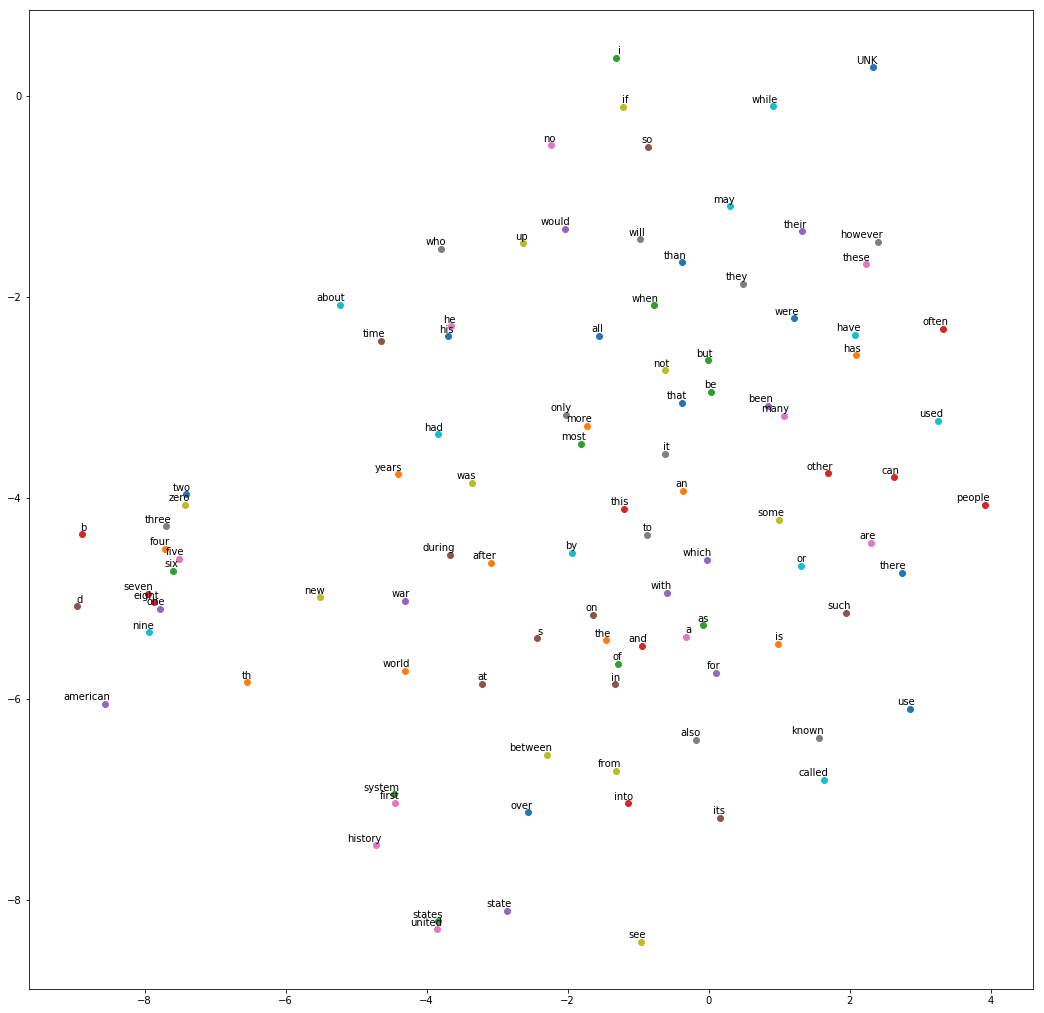

In [10]:
%matplotlib inline
# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')

  plt.savefig(filename)


try:
  # pylint: disable=g-import-not-at-top
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(
      perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
  plot_only = 100
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))

except ImportError as ex:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')
  print(ex)

## Evaluation
The below code uses the [kudkudak/word-embeddings-benchmarks package][1] to evaluate the above embeddings on the [Google Analogy test set][2].

 [1]: https://github.com/kudkudak/word-embeddings-benchmarks (Package for evaluating word embeddings)
 [2]: https://aclweb.org/aclwiki/Google_analogy_test_set_(State_of_the_art) (Google analogy test set)

In [ ]:
from annoy import AnnoyIndex

n_trees = 100
search_k = 100

annoy_index = AnnoyIndex(embedding_size, metric='angular')
for index, embedding in enumerate(final_embeddings):
    annoy_index.add_item(index, embedding)
annoy_index.build(n_trees)

In [12]:
from web.datasets.analogy import fetch_google_analogy

dataset = fetch_google_analogy()


Dataset created in /root/web_data/analogy/EN-GOOGLE



In [13]:
from __future__ import division

previous_category = dataset.category[0]
trials = {'semantic': [], 'syntactic': [], 'total': []}
missing_words = set()
skipped_trials = 0

def print_acc():
    print('- Semantic accuracy:\t{} %\n- Syntactic accuracy:\t{} %\n- Total accuracy:\t{} %'.format(
        float('nan') if not trials['semantic'] else sum(trials['semantic']) / len(trials['semantic']) * 100,
        float('nan') if not trials['syntactic'] else sum(trials['syntactic']) / len(trials['syntactic']) * 100,
        float('nan') if not trials['total'] else sum(trials['total']) / len(trials['total']) * 100,
    ))
    print('- Missing words:\t{} (skipped {} % of all trials)'.format(
        ', '.join(missing_words),
        float('nan') if not trials['total'] else skipped_trials / len(trials['total']) * 100,
    ))
    print()

for X, y, category, category_high_level in zip(
            dataset.X,
            dataset.y,
            dataset.category,
            dataset.category_high_level
        ):

    if previous_category != category:
        previous_category = category
        print('Current category: {}'.format(category))
        print_acc()

    if X[0] in dictionary and X[1] in dictionary and X[2] in dictionary and y in dictionary:
        u1 = final_embeddings[dictionary[X[0]]]
        v1 = final_embeddings[dictionary[X[1]]]
        u2 = final_embeddings[dictionary[X[2]]]
        v2_index = annoy_index.get_nns_by_vector(u2 + (v1 - u1), 1, search_k)[0]
        v2_word = reverse_dictionary[v2_index]
        print('{} - {} + {} = {} (correct answer: {})'.format(X[1], X[0], X[2], v2_word, y))
        trial_success = v2_word == y
    else:
        if X[0] not in dictionary:
            missing_words.add(X[0])
        if X[1] not in dictionary:
            missing_words.add(X[1])
        if X[2] not in dictionary:
            missing_words.add(X[2])
        if y not in dictionary:
            missing_words.add(y)
        skipped_trials += 1
        trial_success = False
    trials[category_high_level].append(trial_success)
    trials['total'].append(trial_success)

print('Finished!')
print_acc()

greece - athens + baghdad = baghdad (correct answer: iraq)
greece - athens + bangkok = bangkok (correct answer: thailand)
greece - athens + beijing = creates (correct answer: china)
greece - athens + berlin = greece (correct answer: germany)
greece - athens + bern = exerted (correct answer: switzerland)
greece - athens + cairo = wins (correct answer: egypt)
greece - athens + canberra = canberra (correct answer: australia)
greece - athens + hanoi = flatter (correct answer: vietnam)
greece - athens + havana = monarchs (correct answer: cuba)
greece - athens + helsinki = venture (correct answer: finland)
greece - athens + islamabad = glaciation (correct answer: pakistan)
greece - athens + kabul = superseded (correct answer: afghanistan)
greece - athens + london = business (correct answer: england)
greece - athens + madrid = saints (correct answer: spain)
greece - athens + moscow = statute (correct answer: russia)
greece - athens + oslo = atolls (correct answer: norway)
greece - athens + ot

australia - canberra + cairo = cairo (correct answer: egypt)
vietnam - hanoi + havana = continuation (correct answer: cuba)
vietnam - hanoi + helsinki = jupiter (correct answer: finland)
vietnam - hanoi + islamabad = builder (correct answer: pakistan)
vietnam - hanoi + kabul = kidd (correct answer: afghanistan)
vietnam - hanoi + london = london (correct answer: england)
vietnam - hanoi + madrid = territory (correct answer: spain)
vietnam - hanoi + moscow = theory (correct answer: russia)
vietnam - hanoi + oslo = manhattan (correct answer: norway)
vietnam - hanoi + ottawa = tim (correct answer: canada)
vietnam - hanoi + paris = articles (correct answer: france)
vietnam - hanoi + rome = occurred (correct answer: italy)
vietnam - hanoi + stockholm = manhattan (correct answer: sweden)
vietnam - hanoi + tehran = dissenting (correct answer: iran)
vietnam - hanoi + tokyo = biography (correct answer: japan)
vietnam - hanoi + athens = athens (correct answer: greece)
vietnam - hanoi + baghdad = 

norway - oslo + stockholm = provide (correct answer: sweden)
norway - oslo + tehran = provide (correct answer: iran)
norway - oslo + tokyo = released (correct answer: japan)
norway - oslo + athens = proposed (correct answer: greece)
norway - oslo + baghdad = norway (correct answer: iraq)
norway - oslo + bangkok = mojo (correct answer: thailand)
norway - oslo + beijing = might (correct answer: china)
norway - oslo + berlin = proposed (correct answer: germany)
norway - oslo + bern = bought (correct answer: switzerland)
norway - oslo + cairo = cairo (correct answer: egypt)
norway - oslo + canberra = offered (correct answer: australia)
norway - oslo + hanoi = determination (correct answer: vietnam)
norway - oslo + havana = offered (correct answer: cuba)
norway - oslo + helsinki = helsinki (correct answer: finland)
norway - oslo + islamabad = pipe (correct answer: pakistan)
norway - oslo + kabul = norway (correct answer: afghanistan)
norway - oslo + london = offered (correct answer: england

nigeria - abuja + bucharest = nation (correct answer: romania)
nigeria - abuja + budapest = knows (correct answer: hungary)
nigeria - abuja + bujumbura = inherit (correct answer: burundi)
nigeria - abuja + cairo = income (correct answer: egypt)
nigeria - abuja + canberra = negro (correct answer: australia)
nigeria - abuja + caracas = hunting (correct answer: venezuela)
nigeria - abuja + chisinau = longbow (correct answer: moldova)
nigeria - abuja + conakry = negro (correct answer: guinea)
nigeria - abuja + copenhagen = copenhagen (correct answer: denmark)
nigeria - abuja + dakar = nigeria (correct answer: senegal)
nigeria - abuja + damascus = stalingrad (correct answer: syria)
nigeria - abuja + dhaka = seeking (correct answer: bangladesh)
nigeria - abuja + doha = speaks (correct answer: qatar)
nigeria - abuja + dublin = territory (correct answer: ireland)
nigeria - abuja + dushanbe = tender (correct answer: tajikistan)
ghana - accra + algiers = ghana (correct answer: algeria)
ghana - a

madagascar - antananarivo + dublin = yugoslavia (correct answer: ireland)
madagascar - antananarivo + dushanbe = servers (correct answer: tajikistan)
madagascar - antananarivo + gaborone = queue (correct answer: botswana)
madagascar - antananarivo + georgetown = realistic (correct answer: guyana)
madagascar - antananarivo + hanoi = hanoi (correct answer: vietnam)
madagascar - antananarivo + harare = checking (correct answer: zimbabwe)
samoa - apia + asmara = serves (correct answer: eritrea)
samoa - apia + astana = astana (correct answer: kazakhstan)
samoa - apia + athens = elected (correct answer: greece)
samoa - apia + baghdad = keep (correct answer: iraq)
samoa - apia + baku = pocket (correct answer: azerbaijan)
samoa - apia + bamako = bamako (correct answer: mali)
samoa - apia + bangkok = bangkok (correct answer: thailand)
samoa - apia + banjul = currents (correct answer: gambia)
samoa - apia + beijing = twenty (correct answer: china)
samoa - apia + beirut = considers (correct answe

iraq - baghdad + jakarta = exclusively (correct answer: indonesia)
iraq - baghdad + kabul = resembling (correct answer: afghanistan)
iraq - baghdad + kampala = cyberangel (correct answer: uganda)
azerbaijan - baku + bamako = bamako (correct answer: mali)
azerbaijan - baku + bangkok = ambassadors (correct answer: thailand)
azerbaijan - baku + banjul = blab (correct answer: gambia)
azerbaijan - baku + beijing = azerbaijan (correct answer: china)
azerbaijan - baku + beirut = azerbaijan (correct answer: lebanon)
azerbaijan - baku + belgrade = impeded (correct answer: serbia)
azerbaijan - baku + belmopan = spellwork (correct answer: belize)
azerbaijan - baku + berlin = azerbaijan (correct answer: germany)
azerbaijan - baku + bern = deaf (correct answer: switzerland)
azerbaijan - baku + bishkek = bishkek (correct answer: kyrgyzstan)
azerbaijan - baku + bratislava = hack (correct answer: slovakia)
azerbaijan - baku + brussels = brussels (correct answer: belgium)
azerbaijan - baku + bucharest 

china - beijing + kiev = refugee (correct answer: ukraine)
china - beijing + kigali = uiro (correct answer: rwanda)
china - beijing + kingston = borges (correct answer: jamaica)
lebanon - beirut + belgrade = illegally (correct answer: serbia)
lebanon - beirut + belmopan = tronf (correct answer: belize)
lebanon - beirut + berlin = lebanon (correct answer: germany)
lebanon - beirut + bern = dante (correct answer: switzerland)
lebanon - beirut + bishkek = bishkek (correct answer: kyrgyzstan)
lebanon - beirut + bratislava = referendum (correct answer: slovakia)
lebanon - beirut + brussels = lebanon (correct answer: belgium)
lebanon - beirut + bucharest = clotting (correct answer: romania)
lebanon - beirut + budapest = lebanon (correct answer: hungary)
lebanon - beirut + bujumbura = corrette (correct answer: burundi)
lebanon - beirut + cairo = abba (correct answer: egypt)
lebanon - beirut + canberra = lebanon (correct answer: australia)
lebanon - beirut + caracas = flyby (correct answer: ve

germany - berlin + dushanbe = lymphopenia (correct answer: tajikistan)
germany - berlin + gaborone = gaborone (correct answer: botswana)
germany - berlin + georgetown = prepares (correct answer: guyana)
germany - berlin + hanoi = rachel (correct answer: vietnam)
germany - berlin + harare = refreshment (correct answer: zimbabwe)
germany - berlin + havana = anal (correct answer: cuba)
germany - berlin + helsinki = pardoned (correct answer: finland)
germany - berlin + islamabad = prepares (correct answer: pakistan)
germany - berlin + jakarta = jakarta (correct answer: indonesia)
germany - berlin + kabul = kabul (correct answer: afghanistan)
germany - berlin + kampala = sepedi (correct answer: uganda)
germany - berlin + kathmandu = kathmandu (correct answer: nepal)
germany - berlin + khartoum = containing (correct answer: sudan)
germany - berlin + kiev = gottfried (correct answer: ukraine)
germany - berlin + kigali = kigali (correct answer: rwanda)
germany - berlin + kingston = kingston (c

belgium - brussels + budapest = budapest (correct answer: hungary)
belgium - brussels + bujumbura = roo (correct answer: burundi)
belgium - brussels + cairo = implemented (correct answer: egypt)
belgium - brussels + canberra = focal (correct answer: australia)
belgium - brussels + caracas = caracas (correct answer: venezuela)
belgium - brussels + chisinau = dispatches (correct answer: moldova)
belgium - brussels + conakry = vichy (correct answer: guinea)
belgium - brussels + copenhagen = poor (correct answer: denmark)
belgium - brussels + dakar = saigon (correct answer: senegal)
belgium - brussels + damascus = damascus (correct answer: syria)
belgium - brussels + dhaka = discounted (correct answer: bangladesh)
belgium - brussels + doha = miserably (correct answer: qatar)
belgium - brussels + dublin = belgium (correct answer: ireland)
belgium - brussels + dushanbe = siar (correct answer: tajikistan)
belgium - brussels + gaborone = juta (correct answer: botswana)
belgium - brussels + geo

burundi - bujumbura + kiev = kiev (correct answer: ukraine)
burundi - bujumbura + kigali = transmitters (correct answer: rwanda)
burundi - bujumbura + kingston = normal (correct answer: jamaica)
burundi - bujumbura + libreville = provide (correct answer: gabon)
burundi - bujumbura + lilongwe = colloquially (correct answer: malawi)
burundi - bujumbura + lima = lima (correct answer: peru)
burundi - bujumbura + lisbon = riding (correct answer: portugal)
burundi - bujumbura + ljubljana = feast (correct answer: slovenia)
burundi - bujumbura + london = within (correct answer: england)
burundi - bujumbura + luanda = bore (correct answer: angola)
burundi - bujumbura + lusaka = triple (correct answer: zambia)
burundi - bujumbura + madrid = too (correct answer: spain)
burundi - bujumbura + managua = preferred (correct answer: nicaragua)
burundi - bujumbura + manama = leap (correct answer: bahrain)
egypt - cairo + canberra = lubyanka (correct answer: australia)
egypt - cairo + caracas = shipwreck

moldova - chisinau + dublin = moldova (correct answer: ireland)
moldova - chisinau + dushanbe = misleadingly (correct answer: tajikistan)
moldova - chisinau + gaborone = jamo (correct answer: botswana)
moldova - chisinau + georgetown = georgetown (correct answer: guyana)
moldova - chisinau + hanoi = hanoi (correct answer: vietnam)
moldova - chisinau + harare = harare (correct answer: zimbabwe)
moldova - chisinau + havana = noun (correct answer: cuba)
moldova - chisinau + helsinki = quasi (correct answer: finland)
moldova - chisinau + islamabad = homosexual (correct answer: pakistan)
moldova - chisinau + jakarta = serbia (correct answer: indonesia)
moldova - chisinau + kabul = carried (correct answer: afghanistan)
moldova - chisinau + kampala = bungee (correct answer: uganda)
moldova - chisinau + kathmandu = landmarks (correct answer: nepal)
moldova - chisinau + khartoum = column (correct answer: sudan)
moldova - chisinau + kiev = decreed (correct answer: ukraine)
moldova - chisinau + k

senegal - dakar + lima = parameters (correct answer: peru)
senegal - dakar + lisbon = lisbon (correct answer: portugal)
senegal - dakar + ljubljana = unconditional (correct answer: slovenia)
senegal - dakar + london = london (correct answer: england)
senegal - dakar + luanda = luanda (correct answer: angola)
senegal - dakar + lusaka = textbooks (correct answer: zambia)
senegal - dakar + madrid = senegal (correct answer: spain)
senegal - dakar + managua = foreskin (correct answer: nicaragua)
senegal - dakar + manama = deletion (correct answer: bahrain)
senegal - dakar + manila = senegal (correct answer: philippines)
senegal - dakar + maputo = dogmatically (correct answer: mozambique)
senegal - dakar + minsk = productive (correct answer: belarus)
senegal - dakar + mogadishu = gsm (correct answer: somalia)
senegal - dakar + monrovia = antibiotics (correct answer: liberia)
senegal - dakar + montevideo = oppose (correct answer: uruguay)
senegal - dakar + moscow = senegal (correct answer: ru

tajikistan - dushanbe + manila = simplicity (correct answer: philippines)
tajikistan - dushanbe + maputo = tajikistan (correct answer: mozambique)
tajikistan - dushanbe + minsk = absorb (correct answer: belarus)
tajikistan - dushanbe + mogadishu = mogadishu (correct answer: somalia)
tajikistan - dushanbe + monrovia = charter (correct answer: liberia)
tajikistan - dushanbe + montevideo = yields (correct answer: uruguay)
tajikistan - dushanbe + moscow = moscow (correct answer: russia)
tajikistan - dushanbe + muscat = connecting (correct answer: oman)
tajikistan - dushanbe + nairobi = tajikistan (correct answer: kenya)
tajikistan - dushanbe + nassau = tajikistan (correct answer: bahamas)
tajikistan - dushanbe + nicosia = mesopotamia (correct answer: cyprus)
botswana - gaborone + georgetown = pun (correct answer: guyana)
botswana - gaborone + hanoi = slide (correct answer: vietnam)
botswana - gaborone + harare = explosive (correct answer: zimbabwe)
botswana - gaborone + havana = havana (co

cuba - havana + monrovia = bcl (correct answer: liberia)
cuba - havana + montevideo = royal (correct answer: uruguay)
cuba - havana + moscow = cuba (correct answer: russia)
cuba - havana + muscat = vedanta (correct answer: oman)
cuba - havana + nairobi = cuban (correct answer: kenya)
cuba - havana + nassau = cuba (correct answer: bahamas)
cuba - havana + nicosia = nicosia (correct answer: cyprus)
cuba - havana + nouakchott = nouakchott (correct answer: mauritania)
cuba - havana + nuuk = nuuk (correct answer: greenland)
cuba - havana + oslo = performs (correct answer: norway)
cuba - havana + ottawa = ottawa (correct answer: canada)
cuba - havana + paramaribo = colinot (correct answer: suriname)
cuba - havana + paris = paris (correct answer: france)
finland - helsinki + islamabad = islamabad (correct answer: pakistan)
finland - helsinki + jakarta = finland (correct answer: indonesia)
finland - helsinki + kabul = finland (correct answer: afghanistan)
finland - helsinki + kampala = apartne

afghanistan - kabul + mogadishu = elvis (correct answer: somalia)
afghanistan - kabul + monrovia = sahara (correct answer: liberia)
afghanistan - kabul + montevideo = invisibly (correct answer: uruguay)
afghanistan - kabul + moscow = influence (correct answer: russia)
afghanistan - kabul + muscat = dazzle (correct answer: oman)
afghanistan - kabul + nairobi = resultant (correct answer: kenya)
afghanistan - kabul + nassau = nassau (correct answer: bahamas)
afghanistan - kabul + nicosia = shiny (correct answer: cyprus)
afghanistan - kabul + nouakchott = nouakchott (correct answer: mauritania)
afghanistan - kabul + nuuk = nuuk (correct answer: greenland)
afghanistan - kabul + oslo = atlas (correct answer: norway)
afghanistan - kabul + ottawa = team (correct answer: canada)
afghanistan - kabul + paramaribo = skandar (correct answer: suriname)
afghanistan - kabul + paris = paris (correct answer: france)
afghanistan - kabul + podgorica = deinonychosaurs (correct answer: montenegro)
afghanist

rwanda - kigali + ottawa = operate (correct answer: canada)
rwanda - kigali + paramaribo = faulkner (correct answer: suriname)
rwanda - kigali + paris = rwanda (correct answer: france)
rwanda - kigali + podgorica = hearing (correct answer: montenegro)
rwanda - kigali + quito = hyde (correct answer: ecuador)
rwanda - kigali + rabat = rwanda (correct answer: morocco)
rwanda - kigali + riga = allocated (correct answer: latvia)
rwanda - kigali + rome = rome (correct answer: italy)
rwanda - kigali + roseau = subnet (correct answer: dominica)
rwanda - kigali + santiago = baghdad (correct answer: chile)
rwanda - kigali + skopje = rwanda (correct answer: macedonia)
rwanda - kigali + sofia = sofia (correct answer: bulgaria)
jamaica - kingston + libreville = iers (correct answer: gabon)
jamaica - kingston + lilongwe = roundheads (correct answer: malawi)
jamaica - kingston + lima = jamaica (correct answer: peru)
jamaica - kingston + lisbon = misuse (correct answer: portugal)
jamaica - kingston + 

portugal - lisbon + santiago = united (correct answer: chile)
portugal - lisbon + skopje = airframe (correct answer: macedonia)
portugal - lisbon + sofia = goals (correct answer: bulgaria)
portugal - lisbon + stockholm = stockholm (correct answer: sweden)
portugal - lisbon + suva = suva (correct answer: fiji)
portugal - lisbon + taipei = isp (correct answer: taiwan)
portugal - lisbon + tallinn = round (correct answer: estonia)
portugal - lisbon + tashkent = hetman (correct answer: uzbekistan)
slovenia - ljubljana + london = london (correct answer: england)
slovenia - ljubljana + luanda = luanda (correct answer: angola)
slovenia - ljubljana + lusaka = tortuous (correct answer: zambia)
slovenia - ljubljana + madrid = games (correct answer: spain)
slovenia - ljubljana + managua = firenze (correct answer: nicaragua)
slovenia - ljubljana + manama = manama (correct answer: bahrain)
slovenia - ljubljana + manila = slovenia (correct answer: philippines)
slovenia - ljubljana + maputo = unoffici

zambia - lusaka + nairobi = jeffrey (correct answer: kenya)
zambia - lusaka + nassau = nassau (correct answer: bahamas)
zambia - lusaka + nicosia = pmid (correct answer: cyprus)
zambia - lusaka + nouakchott = nouakchott (correct answer: mauritania)
zambia - lusaka + nuuk = collectivism (correct answer: greenland)
zambia - lusaka + oslo = humanoid (correct answer: norway)
zambia - lusaka + ottawa = ottawa (correct answer: canada)
zambia - lusaka + paramaribo = propitious (correct answer: suriname)
zambia - lusaka + paris = paris (correct answer: france)
zambia - lusaka + podgorica = looptail (correct answer: montenegro)
zambia - lusaka + quito = universes (correct answer: ecuador)
zambia - lusaka + rabat = ghost (correct answer: morocco)
zambia - lusaka + riga = riga (correct answer: latvia)
zambia - lusaka + rome = rome (correct answer: italy)
zambia - lusaka + roseau = announces (correct answer: dominica)
zambia - lusaka + santiago = calculated (correct answer: chile)
zambia - lusaka 

mozambique - maputo + rabat = discharged (correct answer: morocco)
mozambique - maputo + riga = mozambique (correct answer: latvia)
mozambique - maputo + rome = rome (correct answer: italy)
mozambique - maputo + roseau = mozambique (correct answer: dominica)
mozambique - maputo + santiago = swept (correct answer: chile)
mozambique - maputo + skopje = borda (correct answer: macedonia)
mozambique - maputo + sofia = sofia (correct answer: bulgaria)
mozambique - maputo + stockholm = sends (correct answer: sweden)
mozambique - maputo + suva = mozambique (correct answer: fiji)
mozambique - maputo + taipei = ducati (correct answer: taiwan)
mozambique - maputo + tallinn = prohibition (correct answer: estonia)
mozambique - maputo + tashkent = assisted (correct answer: uzbekistan)
mozambique - maputo + tbilisi = mercy (correct answer: georgia)
mozambique - maputo + tegucigalpa = fairbanks (correct answer: honduras)
mozambique - maputo + tehran = consideration (correct answer: iran)
mozambique - 

russia - moscow + tegucigalpa = penicuik (correct answer: honduras)
russia - moscow + tehran = tehran (correct answer: iran)
russia - moscow + tirana = caan (correct answer: albania)
russia - moscow + tokyo = lowercase (correct answer: japan)
russia - moscow + tripoli = seals (correct answer: libya)
russia - moscow + tunis = thunders (correct answer: tunisia)
russia - moscow + vaduz = vaduz (correct answer: liechtenstein)
russia - moscow + valletta = valletta (correct answer: malta)
russia - moscow + vienna = vienna (correct answer: austria)
russia - moscow + vientiane = hungarians (correct answer: laos)
russia - moscow + vilnius = ordinary (correct answer: lithuania)
russia - moscow + warsaw = warsaw (correct answer: poland)
oman - muscat + nairobi = nairobi (correct answer: kenya)
oman - muscat + nassau = oman (correct answer: bahamas)
oman - muscat + nicosia = oman (correct answer: cyprus)
oman - muscat + nouakchott = volatile (correct answer: mauritania)
oman - muscat + nuuk = allo

mauritania - nouakchott + windhoek = normale (correct answer: namibia)
mauritania - nouakchott + yerevan = yerevan (correct answer: armenia)
mauritania - nouakchott + zagreb = focuses (correct answer: croatia)
mauritania - nouakchott + abuja = abuja (correct answer: nigeria)
mauritania - nouakchott + accra = odyssey (correct answer: ghana)
mauritania - nouakchott + algiers = rhine (correct answer: algeria)
greenland - nuuk + oslo = z (correct answer: norway)
greenland - nuuk + ottawa = longitude (correct answer: canada)
greenland - nuuk + paramaribo = boutiques (correct answer: suriname)
greenland - nuuk + paris = paris (correct answer: france)
greenland - nuuk + podgorica = crimea (correct answer: montenegro)
greenland - nuuk + quito = charter (correct answer: ecuador)
greenland - nuuk + rabat = punk (correct answer: morocco)
greenland - nuuk + riga = submitted (correct answer: latvia)
greenland - nuuk + rome = gdp (correct answer: italy)
greenland - nuuk + roseau = measure (correct a

suriname - paramaribo + tallinn = suriname (correct answer: estonia)
suriname - paramaribo + tashkent = importantly (correct answer: uzbekistan)
suriname - paramaribo + tbilisi = nationals (correct answer: georgia)
suriname - paramaribo + tegucigalpa = suriname (correct answer: honduras)
suriname - paramaribo + tehran = suriname (correct answer: iran)
suriname - paramaribo + tirana = anagrams (correct answer: albania)
suriname - paramaribo + tokyo = suriname (correct answer: japan)
suriname - paramaribo + tripoli = tripoli (correct answer: libya)
suriname - paramaribo + tunis = suriname (correct answer: tunisia)
suriname - paramaribo + vaduz = identity (correct answer: liechtenstein)
suriname - paramaribo + valletta = sennett (correct answer: malta)
suriname - paramaribo + vienna = theology (correct answer: austria)
suriname - paramaribo + vientiane = suriname (correct answer: laos)
suriname - paramaribo + vilnius = suriname (correct answer: lithuania)
suriname - paramaribo + warsaw = 

latvia - riga + tripoli = airways (correct answer: libya)
latvia - riga + tunis = tunis (correct answer: tunisia)
latvia - riga + vaduz = vaduz (correct answer: liechtenstein)
latvia - riga + valletta = bolted (correct answer: malta)
latvia - riga + vienna = operating (correct answer: austria)
latvia - riga + vientiane = vientiane (correct answer: laos)
latvia - riga + vilnius = amino (correct answer: lithuania)
latvia - riga + warsaw = warsaw (correct answer: poland)
latvia - riga + windhoek = windhoek (correct answer: namibia)
latvia - riga + yerevan = prosper (correct answer: armenia)
latvia - riga + zagreb = ark (correct answer: croatia)
latvia - riga + abuja = abuja (correct answer: nigeria)
latvia - riga + accra = airways (correct answer: ghana)
latvia - riga + algiers = lifestyle (correct answer: algeria)
latvia - riga + amman = claude (correct answer: jordan)
latvia - riga + ankara = required (correct answer: turkey)
latvia - riga + antananarivo = psc (correct answer: madagasca

macedonia - skopje + tbilisi = otaku (correct answer: georgia)
macedonia - skopje + tegucigalpa = macedonia (correct answer: honduras)
macedonia - skopje + tehran = constance (correct answer: iran)
macedonia - skopje + tirana = tirana (correct answer: albania)
macedonia - skopje + tokyo = women (correct answer: japan)
macedonia - skopje + tripoli = tripoli (correct answer: libya)
macedonia - skopje + tunis = poor (correct answer: tunisia)
macedonia - skopje + vaduz = tissue (correct answer: liechtenstein)
macedonia - skopje + valletta = cahiers (correct answer: malta)
macedonia - skopje + vienna = macedonia (correct answer: austria)
macedonia - skopje + vientiane = vientiane (correct answer: laos)
macedonia - skopje + vilnius = commentators (correct answer: lithuania)
macedonia - skopje + warsaw = sixty (correct answer: poland)
macedonia - skopje + windhoek = beatification (correct answer: namibia)
macedonia - skopje + yerevan = logan (correct answer: armenia)
macedonia - skopje + zagr

estonia - tallinn + accra = imperative (correct answer: ghana)
estonia - tallinn + algiers = gag (correct answer: algeria)
estonia - tallinn + amman = estonia (correct answer: jordan)
estonia - tallinn + ankara = estonia (correct answer: turkey)
estonia - tallinn + antananarivo = antananarivo (correct answer: madagascar)
estonia - tallinn + apia = costal (correct answer: samoa)
estonia - tallinn + asmara = asmara (correct answer: eritrea)
estonia - tallinn + astana = ade (correct answer: kazakhstan)
estonia - tallinn + athens = met (correct answer: greece)
estonia - tallinn + baghdad = west (correct answer: iraq)
estonia - tallinn + baku = possessed (correct answer: azerbaijan)
estonia - tallinn + bamako = cooh (correct answer: mali)
estonia - tallinn + bangkok = judgement (correct answer: thailand)
estonia - tallinn + banjul = meilan (correct answer: gambia)
estonia - tallinn + beijing = beijing (correct answer: china)
estonia - tallinn + beirut = possessed (correct answer: lebanon)
e

honduras - tegucigalpa + bratislava = luftwaffe (correct answer: slovakia)
iran - tehran + tirana = roundabout (correct answer: albania)
iran - tehran + tokyo = deeply (correct answer: japan)
iran - tehran + tripoli = plc (correct answer: libya)
iran - tehran + tunis = programmes (correct answer: tunisia)
iran - tehran + vaduz = vaduz (correct answer: liechtenstein)
iran - tehran + valletta = armpit (correct answer: malta)
iran - tehran + vienna = iran (correct answer: austria)
iran - tehran + vientiane = cashmere (correct answer: laos)
iran - tehran + vilnius = vilnius (correct answer: lithuania)
iran - tehran + warsaw = warsaw (correct answer: poland)
iran - tehran + windhoek = dimarco (correct answer: namibia)
iran - tehran + yerevan = yerevan (correct answer: armenia)
iran - tehran + zagreb = iran (correct answer: croatia)
iran - tehran + abuja = sili (correct answer: nigeria)
iran - tehran + accra = acupuncture (correct answer: ghana)
iran - tehran + algiers = iran (correct answer

libya - tripoli + baku = baku (correct answer: azerbaijan)
libya - tripoli + bamako = bamako (correct answer: mali)
libya - tripoli + bangkok = sanskrit (correct answer: thailand)
libya - tripoli + banjul = banjul (correct answer: gambia)
libya - tripoli + beijing = for (correct answer: china)
libya - tripoli + beirut = sort (correct answer: lebanon)
libya - tripoli + belgrade = mcgill (correct answer: serbia)
libya - tripoli + belmopan = gimes (correct answer: belize)
libya - tripoli + berlin = months (correct answer: germany)
libya - tripoli + bern = bern (correct answer: switzerland)
libya - tripoli + bishkek = musical (correct answer: kyrgyzstan)
libya - tripoli + bratislava = correspondingly (correct answer: slovakia)
libya - tripoli + brussels = industry (correct answer: belgium)
libya - tripoli + bucharest = bucharest (correct answer: romania)
libya - tripoli + budapest = sanskrit (correct answer: hungary)
libya - tripoli + bujumbura = bujumbura (correct answer: burundi)
libya -

laos - vientiane + bern = laos (correct answer: switzerland)
laos - vientiane + bishkek = inaugurated (correct answer: kyrgyzstan)
laos - vientiane + bratislava = catch (correct answer: slovakia)
laos - vientiane + brussels = brussels (correct answer: belgium)
laos - vientiane + bucharest = bucharest (correct answer: romania)
laos - vientiane + budapest = shipped (correct answer: hungary)
laos - vientiane + bujumbura = willamette (correct answer: burundi)
laos - vientiane + cairo = cairo (correct answer: egypt)
laos - vientiane + canberra = las (correct answer: australia)
laos - vientiane + caracas = songwriter (correct answer: venezuela)
laos - vientiane + chisinau = chisinau (correct answer: moldova)
laos - vientiane + conakry = three (correct answer: guinea)
laos - vientiane + copenhagen = forbidden (correct answer: denmark)
lithuania - vilnius + warsaw = adopted (correct answer: poland)
lithuania - vilnius + windhoek = layolle (correct answer: namibia)
lithuania - vilnius + yerevan

armenia - yerevan + accra = handheld (correct answer: ghana)
armenia - yerevan + algiers = algiers (correct answer: algeria)
armenia - yerevan + amman = guidance (correct answer: jordan)
armenia - yerevan + ankara = exactly (correct answer: turkey)
armenia - yerevan + antananarivo = chile (correct answer: madagascar)
armenia - yerevan + apia = grails (correct answer: samoa)
armenia - yerevan + asmara = spellings (correct answer: eritrea)
armenia - yerevan + astana = guadeloupe (correct answer: kazakhstan)
armenia - yerevan + athens = section (correct answer: greece)
armenia - yerevan + baghdad = armenia (correct answer: iraq)
armenia - yerevan + baku = armenia (correct answer: azerbaijan)
armenia - yerevan + bamako = container (correct answer: mali)
armenia - yerevan + bangkok = bangkok (correct answer: thailand)
armenia - yerevan + banjul = lakh (correct answer: gambia)
armenia - yerevan + beijing = correct (correct answer: china)
armenia - yerevan + beirut = fraction (correct answer:

peso - argentina + croatia = peso (correct answer: kuna)
peso - argentina + denmark = benjamin (correct answer: krone)
peso - argentina + europe = quietly (correct answer: euro)
peso - argentina + hungary = gb (correct answer: forint)
peso - argentina + india = differentiates (correct answer: rupee)
peso - argentina + iran = mates (correct answer: rial)
peso - argentina + japan = japan (correct answer: yen)
peso - argentina + korea = sen (correct answer: won)
peso - argentina + latvia = porta (correct answer: lats)
peso - argentina + lithuania = alterations (correct answer: litas)
peso - argentina + macedonia = scholarships (correct answer: denar)
peso - argentina + malaysia = chargers (correct answer: ringgit)
peso - argentina + nigeria = rab (correct answer: naira)
peso - argentina + poland = peso (correct answer: zloty)
peso - argentina + romania = consigned (correct answer: leu)
peso - argentina + russia = singapore (correct answer: ruble)
peso - argentina + sweden = rab (correct a

kuna - croatia + canada = brightman (correct answer: dollar)
krone - denmark + europe = eastwood (correct answer: euro)
krone - denmark + hungary = krone (correct answer: forint)
krone - denmark + india = alison (correct answer: rupee)
krone - denmark + iran = sanctuaries (correct answer: rial)
krone - denmark + japan = dignitaries (correct answer: yen)
krone - denmark + korea = superfluous (correct answer: won)
krone - denmark + latvia = rationals (correct answer: lats)
krone - denmark + lithuania = astronomers (correct answer: litas)
krone - denmark + macedonia = malian (correct answer: denar)
krone - denmark + malaysia = mitsotakis (correct answer: ringgit)
krone - denmark + mexico = longship (correct answer: peso)
krone - denmark + nigeria = chapterhouse (correct answer: naira)
krone - denmark + poland = germanicus (correct answer: zloty)
krone - denmark + romania = deployments (correct answer: leu)
krone - denmark + russia = reverses (correct answer: ruble)
krone - denmark + swede

yen - japan + mexico = anthologies (correct answer: peso)
yen - japan + nigeria = ministries (correct answer: naira)
yen - japan + poland = yen (correct answer: zloty)
yen - japan + romania = anthologies (correct answer: leu)
yen - japan + russia = consistent (correct answer: ruble)
yen - japan + sweden = gateway (correct answer: krona)
yen - japan + thailand = yen (correct answer: baht)
yen - japan + ukraine = redshift (correct answer: hryvnia)
yen - japan + usa = chagas (correct answer: dollar)
yen - japan + vietnam = integrator (correct answer: dong)
yen - japan + algeria = vie (correct answer: dinar)
yen - japan + angola = mandy (correct answer: kwanza)
yen - japan + argentina = yen (correct answer: peso)
yen - japan + armenia = serapeum (correct answer: dram)
yen - japan + brazil = inanimate (correct answer: real)
yen - japan + bulgaria = subsidiaries (correct answer: lev)
yen - japan + cambodia = harlan (correct answer: riel)
yen - japan + canada = cedar (correct answer: dollar)


peso - mexico + malaysia = peso (correct answer: ringgit)
naira - nigeria + poland = naira (correct answer: zloty)
naira - nigeria + romania = naira (correct answer: leu)
naira - nigeria + russia = beatboxers (correct answer: ruble)
naira - nigeria + sweden = callacanthis (correct answer: krona)
naira - nigeria + thailand = celmins (correct answer: baht)
naira - nigeria + ukraine = mitologica (correct answer: hryvnia)
naira - nigeria + usa = ideational (correct answer: dollar)
naira - nigeria + vietnam = qamatz (correct answer: dong)
naira - nigeria + algeria = adelchis (correct answer: dinar)
naira - nigeria + angola = lawteacher (correct answer: kwanza)
naira - nigeria + argentina = mahavratas (correct answer: peso)
naira - nigeria + armenia = psychologies (correct answer: dram)
naira - nigeria + brazil = embroil (correct answer: real)
naira - nigeria + bulgaria = varshney (correct answer: lev)
naira - nigeria + cambodia = naira (correct answer: riel)
naira - nigeria + canada = swcz 

dollar - usa + mexico = mexico (correct answer: peso)
dollar - usa + nigeria = dollar (correct answer: naira)
dollar - usa + poland = dollar (correct answer: zloty)
dollar - usa + romania = romania (correct answer: leu)
dollar - usa + russia = simultaneous (correct answer: ruble)
dollar - usa + sweden = expands (correct answer: krona)
dollar - usa + thailand = rite (correct answer: baht)
dollar - usa + ukraine = harps (correct answer: hryvnia)
dong - vietnam + algeria = nul (correct answer: dinar)
dong - vietnam + angola = laban (correct answer: kwanza)
dong - vietnam + argentina = argentina (correct answer: peso)
dong - vietnam + armenia = wiley (correct answer: dram)
dong - vietnam + brazil = laban (correct answer: real)
dong - vietnam + bulgaria = dong (correct answer: lev)
dong - vietnam + cambodia = kai (correct answer: riel)
dong - vietnam + canada = cure (correct answer: dollar)
dong - vietnam + croatia = deception (correct answer: kuna)
dong - vietnam + denmark = favorable (cor

pennsylvania - philadelphia + portland = portland (correct answer: oregon)
pennsylvania - philadelphia + tucson = mommy (correct answer: arizona)
pennsylvania - philadelphia + fresno = fresno (correct answer: california)
pennsylvania - philadelphia + sacramento = parliaments (correct answer: california)
pennsylvania - philadelphia + mesa = arranges (correct answer: arizona)
pennsylvania - philadelphia + atlanta = pennsylvania (correct answer: georgia)
pennsylvania - philadelphia + omaha = assess (correct answer: nebraska)
pennsylvania - philadelphia + miami = org (correct answer: florida)
pennsylvania - philadelphia + tulsa = tulsa (correct answer: oklahoma)
pennsylvania - philadelphia + oakland = propulsion (correct answer: california)
pennsylvania - philadelphia + cleveland = promoted (correct answer: ohio)
pennsylvania - philadelphia + minneapolis = only (correct answer: minnesota)
pennsylvania - philadelphia + wichita = singapore (correct answer: kansas)
pennsylvania - philadelphia

florida - jacksonville + pittsburgh = florida (correct answer: pennsylvania)
florida - jacksonville + lexington = florida (correct answer: kentucky)
florida - jacksonville + stockton = entering (correct answer: california)
florida - jacksonville + cincinnati = customers (correct answer: ohio)
florida - jacksonville + anchorage = florida (correct answer: alaska)
florida - jacksonville + toledo = florida (correct answer: ohio)
florida - jacksonville + plano = plano (correct answer: texas)
florida - jacksonville + henderson = quote (correct answer: nevada)
florida - jacksonville + laredo = smd (correct answer: texas)
indiana - indianapolis + austin = sets (correct answer: texas)
indiana - indianapolis + detroit = today (correct answer: michigan)
indiana - indianapolis + memphis = today (correct answer: tennessee)
indiana - indianapolis + boston = indiana (correct answer: massachusetts)
indiana - indianapolis + seattle = luke (correct answer: washington)
indiana - indianapolis + denver = d

tennessee - memphis + seattle = licensed (correct answer: washington)
tennessee - memphis + denver = firefox (correct answer: colorado)
tennessee - memphis + baltimore = baltimore (correct answer: maryland)
tennessee - memphis + louisville = anthem (correct answer: kentucky)
tennessee - memphis + milwaukee = acronym (correct answer: wisconsin)
tennessee - memphis + portland = biology (correct answer: oregon)
tennessee - memphis + tucson = tucson (correct answer: arizona)
tennessee - memphis + fresno = fresno (correct answer: california)
tennessee - memphis + sacramento = schilling (correct answer: california)
tennessee - memphis + mesa = liaison (correct answer: arizona)
tennessee - memphis + atlanta = lp (correct answer: georgia)
tennessee - memphis + omaha = omaha (correct answer: nebraska)
tennessee - memphis + miami = miami (correct answer: florida)
tennessee - memphis + tulsa = ngc (correct answer: oklahoma)
tennessee - memphis + oakland = none (correct answer: california)
tenness

colorado - denver + miami = leader (correct answer: florida)
colorado - denver + tulsa = bought (correct answer: oklahoma)
colorado - denver + oakland = oakland (correct answer: california)
colorado - denver + cleveland = macau (correct answer: ohio)
colorado - denver + minneapolis = iona (correct answer: minnesota)
colorado - denver + wichita = lawsuits (correct answer: kansas)
colorado - denver + arlington = arlington (correct answer: texas)
colorado - denver + bakersfield = bakersfield (correct answer: california)
colorado - denver + tampa = censors (correct answer: florida)
colorado - denver + anaheim = caligula (correct answer: california)
colorado - denver + honolulu = clown (correct answer: hawaii)
colorado - denver + pittsburgh = results (correct answer: pennsylvania)
colorado - denver + lexington = equivalents (correct answer: kentucky)
colorado - denver + stockton = struggled (correct answer: california)
colorado - denver + cincinnati = cincinnati (correct answer: ohio)
color

kentucky - louisville + laredo = kindling (correct answer: texas)
kentucky - louisville + chandler = baghdad (correct answer: arizona)
kentucky - louisville + madison = kentucky (correct answer: wisconsin)
kentucky - louisville + lubbock = colloidal (correct answer: texas)
kentucky - louisville + garland = fence (correct answer: texas)
kentucky - louisville + glendale = clutch (correct answer: arizona)
kentucky - louisville + hialeah = leib (correct answer: florida)
kentucky - louisville + reno = statistic (correct answer: nevada)
kentucky - louisville + scottsdale = scottsdale (correct answer: arizona)
kentucky - louisville + irving = liturgical (correct answer: texas)
kentucky - louisville + fremont = asleep (correct answer: california)
wisconsin - milwaukee + portland = sentences (correct answer: oregon)
wisconsin - milwaukee + tucson = tucson (correct answer: arizona)
wisconsin - milwaukee + fresno = olduvai (correct answer: california)
wisconsin - milwaukee + sacramento = practica

california - fresno + minneapolis = efforts (correct answer: minnesota)
california - fresno + wichita = california (correct answer: kansas)
california - fresno + arlington = california (correct answer: texas)
california - fresno + tampa = saw (correct answer: florida)
california - fresno + honolulu = california (correct answer: hawaii)
california - fresno + pittsburgh = washington (correct answer: pennsylvania)
california - fresno + lexington = printing (correct answer: kentucky)
california - fresno + cincinnati = california (correct answer: ohio)
california - fresno + anchorage = california (correct answer: alaska)
california - fresno + toledo = uniform (correct answer: ohio)
california - fresno + plano = financial (correct answer: texas)
california - fresno + henderson = california (correct answer: nevada)
california - fresno + orlando = california (correct answer: florida)
california - fresno + laredo = reach (correct answer: texas)
california - fresno + chandler = similarly (correc

georgia - atlanta + fontana = satirized (correct answer: california)
nebraska - omaha + miami = miami (correct answer: florida)
nebraska - omaha + tulsa = clustered (correct answer: oklahoma)
nebraska - omaha + oakland = nebraska (correct answer: california)
nebraska - omaha + cleveland = upcoming (correct answer: ohio)
nebraska - omaha + minneapolis = undergraduate (correct answer: minnesota)
nebraska - omaha + wichita = guessing (correct answer: kansas)
nebraska - omaha + arlington = custom (correct answer: texas)
nebraska - omaha + bakersfield = hummers (correct answer: california)
nebraska - omaha + tampa = monumental (correct answer: florida)
nebraska - omaha + anaheim = attacking (correct answer: california)
nebraska - omaha + honolulu = totalitarian (correct answer: hawaii)
nebraska - omaha + pittsburgh = scripts (correct answer: pennsylvania)
nebraska - omaha + lexington = nebraska (correct answer: kentucky)
nebraska - omaha + stockton = breaking (correct answer: california)
ne

california - oakland + glendale = inform (correct answer: arizona)
california - oakland + hialeah = hialeah (correct answer: florida)
california - oakland + reno = reno (correct answer: nevada)
california - oakland + scottsdale = gott (correct answer: arizona)
california - oakland + irving = martin (correct answer: texas)
california - oakland + spokane = spokane (correct answer: washington)
california - oakland + shreveport = cannae (correct answer: louisiana)
california - oakland + tacoma = concluding (correct answer: washington)
california - oakland + akron = bar (correct answer: ohio)
california - oakland + amarillo = counterpunch (correct answer: texas)
california - oakland + tallahassee = shevchenko (correct answer: florida)
ohio - cleveland + minneapolis = ohio (correct answer: minnesota)
ohio - cleveland + wichita = friar (correct answer: kansas)
ohio - cleveland + arlington = arlington (correct answer: texas)
ohio - cleveland + bakersfield = lucky (correct answer: california)
o

texas - arlington + scottsdale = bbl (correct answer: arizona)
texas - arlington + fremont = attac (correct answer: california)
texas - arlington + irvine = rail (correct answer: california)
texas - arlington + spokane = spokane (correct answer: washington)
texas - arlington + modesto = geen (correct answer: california)
texas - arlington + shreveport = texas (correct answer: louisiana)
texas - arlington + tacoma = asia (correct answer: washington)
texas - arlington + oxnard = artspeak (correct answer: california)
texas - arlington + fontana = fontana (correct answer: california)
texas - arlington + akron = sparking (correct answer: ohio)
texas - arlington + glendale = glendale (correct answer: california)
texas - arlington + tallahassee = tallahassee (correct answer: florida)
texas - arlington + huntsville = eversharp (correct answer: alabama)
texas - arlington + worcester = noise (correct answer: massachusetts)
texas - arlington + chicago = project (correct answer: illinois)
californi

hawaii - honolulu + modesto = modesto (correct answer: california)
hawaii - honolulu + shreveport = stabilize (correct answer: louisiana)
hawaii - honolulu + tacoma = braille (correct answer: washington)
hawaii - honolulu + oxnard = atutxa (correct answer: california)
hawaii - honolulu + fontana = tycho (correct answer: california)
hawaii - honolulu + akron = maradona (correct answer: ohio)
hawaii - honolulu + amarillo = asagiri (correct answer: texas)
hawaii - honolulu + glendale = sick (correct answer: california)
hawaii - honolulu + tallahassee = tallahassee (correct answer: florida)
hawaii - honolulu + huntsville = urbanohio (correct answer: alabama)
hawaii - honolulu + worcester = worcester (correct answer: massachusetts)
hawaii - honolulu + chicago = grammar (correct answer: illinois)
hawaii - honolulu + houston = widow (correct answer: texas)
hawaii - honolulu + philadelphia = grammar (correct answer: pennsylvania)
hawaii - honolulu + phoenix = sets (correct answer: arizona)
haw

ohio - cincinnati + fremont = steffi (correct answer: california)
ohio - cincinnati + irvine = dolphin (correct answer: california)
ohio - cincinnati + spokane = resenting (correct answer: washington)
ohio - cincinnati + modesto = ketton (correct answer: california)
ohio - cincinnati + shreveport = stifling (correct answer: louisiana)
ohio - cincinnati + tacoma = sloan (correct answer: washington)
ohio - cincinnati + oxnard = hexateuch (correct answer: california)
ohio - cincinnati + fontana = fontana (correct answer: california)
ohio - cincinnati + amarillo = kimiko (correct answer: texas)
ohio - cincinnati + glendale = glendale (correct answer: california)
ohio - cincinnati + tallahassee = antlered (correct answer: florida)
ohio - cincinnati + huntsville = phaswane (correct answer: alabama)
ohio - cincinnati + worcester = meats (correct answer: massachusetts)
ohio - cincinnati + chicago = ohio (correct answer: illinois)
ohio - cincinnati + houston = macrovision (correct answer: texas

nevada - henderson + irving = xiii (correct answer: texas)
nevada - henderson + fremont = fremont (correct answer: california)
nevada - henderson + irvine = stylised (correct answer: california)
nevada - henderson + spokane = opcode (correct answer: washington)
nevada - henderson + modesto = modesto (correct answer: california)
nevada - henderson + shreveport = shreveport (correct answer: louisiana)
nevada - henderson + tacoma = obstacle (correct answer: washington)
nevada - henderson + oxnard = oxnard (correct answer: california)
nevada - henderson + fontana = enthusiast (correct answer: california)
nevada - henderson + akron = akron (correct answer: ohio)
nevada - henderson + amarillo = amarillo (correct answer: texas)
nevada - henderson + glendale = redundancy (correct answer: california)
nevada - henderson + tallahassee = flunitrazepam (correct answer: florida)
nevada - henderson + huntsville = rotunda (correct answer: alabama)
nevada - henderson + worcester = malawi (correct answe

wisconsin - madison + lubbock = azores (correct answer: texas)
wisconsin - madison + garland = similar (correct answer: texas)
wisconsin - madison + glendale = takeover (correct answer: arizona)
wisconsin - madison + hialeah = boldinghiana (correct answer: florida)
wisconsin - madison + reno = biggs (correct answer: nevada)
wisconsin - madison + scottsdale = resistivity (correct answer: arizona)
wisconsin - madison + irving = col (correct answer: texas)
wisconsin - madison + fremont = vadis (correct answer: california)
wisconsin - madison + irvine = fast (correct answer: california)
wisconsin - madison + spokane = posteriori (correct answer: washington)
wisconsin - madison + modesto = jeita (correct answer: california)
wisconsin - madison + shreveport = extermination (correct answer: louisiana)
wisconsin - madison + tacoma = stein (correct answer: washington)
wisconsin - madison + oxnard = gayal (correct answer: california)
wisconsin - madison + fontana = experts (correct answer: calif

arizona - glendale + denver = award (correct answer: colorado)
arizona - glendale + baltimore = dropped (correct answer: maryland)
arizona - glendale + nashville = display (correct answer: tennessee)
arizona - glendale + louisville = ansi (correct answer: kentucky)
arizona - glendale + milwaukee = saturday (correct answer: wisconsin)
arizona - glendale + portland = portland (correct answer: oregon)
arizona - glendale + fresno = dd (correct answer: california)
arizona - glendale + sacramento = assets (correct answer: california)
florida - hialeah + reno = meters (correct answer: nevada)
florida - hialeah + scottsdale = iraqi (correct answer: arizona)
florida - hialeah + irving = necessity (correct answer: texas)
florida - hialeah + fremont = property (correct answer: california)
florida - hialeah + irvine = crick (correct answer: california)
florida - hialeah + spokane = crick (correct answer: washington)
florida - hialeah + modesto = liver (correct answer: california)
florida - hialeah

california - fremont + tulsa = earl (correct answer: oklahoma)
california - irvine + spokane = california (correct answer: washington)
california - irvine + shreveport = california (correct answer: louisiana)
california - irvine + tacoma = exile (correct answer: washington)
california - irvine + akron = california (correct answer: ohio)
california - irvine + amarillo = demographer (correct answer: texas)
california - irvine + tallahassee = arnulf (correct answer: florida)
california - irvine + huntsville = huntsville (correct answer: alabama)
california - irvine + worcester = california (correct answer: massachusetts)
california - irvine + chicago = house (correct answer: illinois)
california - irvine + houston = california (correct answer: texas)
california - irvine + philadelphia = philadelphia (correct answer: pennsylvania)
california - irvine + phoenix = safe (correct answer: arizona)
california - irvine + dallas = california (correct answer: texas)
california - irvine + jacksonvil

washington - tacoma + cleveland = washington (correct answer: ohio)
washington - tacoma + minneapolis = her (correct answer: minnesota)
washington - tacoma + wichita = diagnosis (correct answer: kansas)
washington - tacoma + arlington = brought (correct answer: texas)
california - oxnard + akron = cup (correct answer: ohio)
california - oxnard + amarillo = differences (correct answer: texas)
california - oxnard + tallahassee = between (correct answer: florida)
california - oxnard + huntsville = huntsville (correct answer: alabama)
california - oxnard + worcester = deputies (correct answer: massachusetts)
california - oxnard + chicago = historical (correct answer: illinois)
california - oxnard + houston = took (correct answer: texas)
california - oxnard + philadelphia = took (correct answer: pennsylvania)
california - oxnard + phoenix = put (correct answer: arizona)
california - oxnard + dallas = dallas (correct answer: texas)
california - oxnard + jacksonville = california (correct ans

california - glendale + pittsburgh = put (correct answer: pennsylvania)
florida - tallahassee + huntsville = economy (correct answer: alabama)
florida - tallahassee + worcester = eichmann (correct answer: massachusetts)
florida - tallahassee + chicago = florida (correct answer: illinois)
florida - tallahassee + houston = sports (correct answer: texas)
florida - tallahassee + philadelphia = value (correct answer: pennsylvania)
florida - tallahassee + phoenix = phoenix (correct answer: arizona)
florida - tallahassee + dallas = dallas (correct answer: texas)
florida - tallahassee + indianapolis = jones (correct answer: indiana)
florida - tallahassee + austin = youth (correct answer: texas)
florida - tallahassee + detroit = users (correct answer: michigan)
florida - tallahassee + memphis = april (correct answer: tennessee)
florida - tallahassee + boston = florida (correct answer: massachusetts)
florida - tallahassee + seattle = seattle (correct answer: washington)
florida - tallahassee + d

girl - boy + brother = brother (correct answer: sister)
girl - boy + brothers = girl (correct answer: sisters)
girl - boy + dad = improvisations (correct answer: mom)
girl - boy + father = girl (correct answer: mother)
girl - boy + grandfather = privatization (correct answer: grandmother)
girl - boy + grandpa = reissues (correct answer: grandma)
girl - boy + grandson = sank (correct answer: granddaughter)
girl - boy + groom = paranoid (correct answer: bride)
girl - boy + he = birth (correct answer: she)
girl - boy + his = girl (correct answer: her)
girl - boy + husband = girl (correct answer: wife)
girl - boy + king = girl (correct answer: queen)
girl - boy + man = man (correct answer: woman)
girl - boy + nephew = pmid (correct answer: niece)
girl - boy + policeman = policeman (correct answer: policewoman)
girl - boy + prince = prince (correct answer: princess)
girl - boy + son = text (correct answer: daughter)
girl - boy + sons = vinyl (correct answer: daughters)
girl - boy + stepbrot

grandma - grandpa + king = but (correct answer: queen)
grandma - grandpa + man = would (correct answer: woman)
grandma - grandpa + nephew = immaterial (correct answer: niece)
grandma - grandpa + policeman = trentino (correct answer: policewoman)
grandma - grandpa + prince = would (correct answer: princess)
grandma - grandpa + son = but (correct answer: daughter)
grandma - grandpa + sons = chung (correct answer: daughters)
grandma - grandpa + stepbrother = chernogorovka (correct answer: stepsister)
grandma - grandpa + stepfather = calreticulin (correct answer: stepmother)
grandma - grandpa + stepson = delporte (correct answer: stepdaughter)
grandma - grandpa + uncle = unmortgaged (correct answer: aunt)
grandma - grandpa + boy = would (correct answer: girl)
grandma - grandpa + brother = disciple (correct answer: sister)
grandma - grandpa + brothers = would (correct answer: sisters)
grandma - grandpa + dad = grandma (correct answer: mom)
grandma - grandpa + father = them (correct answer: 

princess - prince + sons = achieving (correct answer: daughters)
princess - prince + stepbrother = stepbrother (correct answer: stepsister)
princess - prince + stepfather = snails (correct answer: stepmother)
princess - prince + stepson = fresnel (correct answer: stepdaughter)
princess - prince + uncle = iupac (correct answer: aunt)
princess - prince + boy = expenditures (correct answer: girl)
princess - prince + brother = wanted (correct answer: sister)
princess - prince + brothers = princess (correct answer: sisters)
princess - prince + dad = overwhelms (correct answer: mom)
princess - prince + father = caucasus (correct answer: mother)
princess - prince + grandfather = wwf (correct answer: grandmother)
princess - prince + grandpa = steamships (correct answer: grandma)
princess - prince + grandson = analgesic (correct answer: granddaughter)
princess - prince + groom = simulation (correct answer: bride)
princess - prince + he = inversion (correct answer: she)
princess - prince + his =

aunt - uncle + dad = wheaton (correct answer: mom)
aunt - uncle + father = father (correct answer: mother)
aunt - uncle + grandfather = dekker (correct answer: grandmother)
aunt - uncle + grandpa = potencies (correct answer: grandma)
aunt - uncle + grandson = postmodernism (correct answer: granddaughter)
aunt - uncle + groom = shortage (correct answer: bride)
aunt - uncle + he = casing (correct answer: she)
aunt - uncle + his = his (correct answer: her)
aunt - uncle + husband = husband (correct answer: wife)
aunt - uncle + king = king (correct answer: queen)
aunt - uncle + man = fate (correct answer: woman)
aunt - uncle + nephew = adjustments (correct answer: niece)
aunt - uncle + policeman = ket (correct answer: policewoman)
aunt - uncle + prince = helsinki (correct answer: princess)
aunt - uncle + son = appointment (correct answer: daughter)
aunt - uncle + sons = unveiled (correct answer: daughters)
aunt - uncle + stepbrother = pseudoacacia (correct answer: stepsister)
aunt - uncle +

cheerfully - cheerful + sudden = challenging (correct answer: suddenly)
cheerfully - cheerful + swift = angiotensin (correct answer: swiftly)
cheerfully - cheerful + typical = location (correct answer: typically)
cheerfully - cheerful + unfortunate = cheerfully (correct answer: unfortunately)
cheerfully - cheerful + usual = cheerfully (correct answer: usually)
cheerfully - cheerful + amazing = merwe (correct answer: amazingly)
cheerfully - cheerful + apparent = vital (correct answer: apparently)
cheerfully - cheerful + calm = challenging (correct answer: calmly)
completely - complete + efficient = dunes (correct answer: efficiently)
completely - complete + fortunate = abolishing (correct answer: fortunately)
completely - complete + free = free (correct answer: freely)
completely - complete + furious = gibbon (correct answer: furiously)
completely - complete + happy = authoritarian (correct answer: happily)
completely - complete + immediate = literal (correct answer: immediately)
comple

freely - free + usual = communion (correct answer: usually)
freely - free + amazing = banker (correct answer: amazingly)
freely - free + apparent = freely (correct answer: apparently)
freely - free + calm = nas (correct answer: calmly)
freely - free + cheerful = mooney (correct answer: cheerfully)
freely - free + complete = complete (correct answer: completely)
freely - free + efficient = memo (correct answer: efficiently)
freely - free + fortunate = urine (correct answer: fortunately)
furiously - furious + happy = angliae (correct answer: happily)
furiously - furious + immediate = furiously (correct answer: immediately)
furiously - furious + infrequent = eide (correct answer: infrequently)
furiously - furious + lucky = dhy (correct answer: luckily)
furiously - furious + most = furiously (correct answer: mostly)
furiously - furious + obvious = furiously (correct answer: obviously)
furiously - furious + occasional = furiously (correct answer: occasionally)
furiously - furious + possible

luckily - lucky + obvious = youths (correct answer: obviously)
luckily - lucky + occasional = carver (correct answer: occasionally)
luckily - lucky + possible = work (correct answer: possibly)
luckily - lucky + precise = tautou (correct answer: precisely)
luckily - lucky + professional = rigveda (correct answer: professionally)
luckily - lucky + quick = eof (correct answer: quickly)
luckily - lucky + quiet = excepting (correct answer: quietly)
luckily - lucky + rapid = reformulated (correct answer: rapidly)
luckily - lucky + rare = knockoff (correct answer: rarely)
luckily - lucky + reluctant = uncompromising (correct answer: reluctantly)
luckily - lucky + safe = safe (correct answer: safely)
luckily - lucky + serious = beatrice (correct answer: seriously)
luckily - lucky + slow = clamouring (correct answer: slowly)
luckily - lucky + sudden = longrightarrow (correct answer: suddenly)
luckily - lucky + swift = paramagnetic (correct answer: swiftly)
luckily - lucky + typical = merges (co

possibly - possible + quick = cavalry (correct answer: quickly)
possibly - possible + quiet = sqrt (correct answer: quietly)
possibly - possible + rapid = belts (correct answer: rapidly)
possibly - possible + rare = rare (correct answer: rarely)
possibly - possible + reluctant = influx (correct answer: reluctantly)
possibly - possible + safe = controlling (correct answer: safely)
possibly - possible + serious = serious (correct answer: seriously)
possibly - possible + slow = t (correct answer: slowly)
possibly - possible + sudden = assassinate (correct answer: suddenly)
possibly - possible + swift = castro (correct answer: swiftly)
possibly - possible + typical = typical (correct answer: typically)
possibly - possible + unfortunate = gaza (correct answer: unfortunately)
possibly - possible + usual = exclusive (correct answer: usually)
possibly - possible + amazing = moment (correct answer: amazingly)
possibly - possible + apparent = apparent (correct answer: apparently)
possibly - poss

quietly - quiet + reluctant = bitter (correct answer: reluctantly)
quietly - quiet + safe = athletic (correct answer: safely)
quietly - quiet + serious = quietly (correct answer: seriously)
quietly - quiet + slow = rights (correct answer: slowly)
quietly - quiet + sudden = neighborhood (correct answer: suddenly)
quietly - quiet + swift = suv (correct answer: swiftly)
quietly - quiet + typical = simile (correct answer: typically)
quietly - quiet + unfortunate = bitter (correct answer: unfortunately)
quietly - quiet + usual = bitter (correct answer: usually)
quietly - quiet + amazing = abacus (correct answer: amazingly)
quietly - quiet + apparent = arsenic (correct answer: apparently)
quietly - quiet + calm = looped (correct answer: calmly)
quietly - quiet + cheerful = interruptions (correct answer: cheerfully)
quietly - quiet + complete = cover (correct answer: completely)
quietly - quiet + efficient = bitter (correct answer: efficiently)
quietly - quiet + fortunate = ramps (correct ans

seriously - serious + safe = exact (correct answer: safely)
slowly - slow + sudden = village (correct answer: suddenly)
slowly - slow + swift = swift (correct answer: swiftly)
slowly - slow + typical = existed (correct answer: typically)
slowly - slow + unfortunate = slowly (correct answer: unfortunately)
slowly - slow + usual = slowly (correct answer: usually)
slowly - slow + amazing = amazing (correct answer: amazingly)
slowly - slow + apparent = outbreak (correct answer: apparently)
slowly - slow + calm = cum (correct answer: calmly)
slowly - slow + cheerful = failure (correct answer: cheerfully)
slowly - slow + complete = slowly (correct answer: completely)
slowly - slow + efficient = investigated (correct answer: efficiently)
slowly - slow + fortunate = shy (correct answer: fortunately)
slowly - slow + free = free (correct answer: freely)
slowly - slow + furious = workstation (correct answer: furiously)
slowly - slow + happy = yom (correct answer: happily)
slowly - slow + immediat

usually - usual + typical = they (correct answer: typically)
usually - usual + unfortunate = factbook (correct answer: unfortunately)
Current category: gram2-opposite
- Semantic accuracy:	0.0112752283234 %
- Syntactic accuracy:	0.0 %
- Total accuracy:	0.0101409593348 %
- Missing words:	niamey, funafuti, thimphu, ashgabat (skipped 3.1234154751 % of all trials)

unacceptable - acceptable + aware = rulings (correct answer: unaware)
unacceptable - acceptable + certain = certain (correct answer: uncertain)
unacceptable - acceptable + clear = attack (correct answer: unclear)
unacceptable - acceptable + comfortable = dividends (correct answer: uncomfortable)
unacceptable - acceptable + competitive = ndp (correct answer: uncompetitive)
unacceptable - acceptable + consistent = should (correct answer: inconsistent)
unacceptable - acceptable + convincing = zork (correct answer: unconvincing)
unacceptable - acceptable + convenient = coiled (correct answer: inconvenient)
unacceptable - acceptable +

uncomfortable - comfortable + informative = uncomfortable (correct answer: uninformative)
uncomfortable - comfortable + informed = uncomfortable (correct answer: uninformed)
uncomfortable - comfortable + known = bambara (correct answer: unknown)
uncomfortable - comfortable + likely = uncomfortable (correct answer: unlikely)
uncomfortable - comfortable + logical = uncomfortable (correct answer: illogical)
uncomfortable - comfortable + pleasant = uncomfortable (correct answer: unpleasant)
uncomfortable - comfortable + possible = frodo (correct answer: impossible)
uncomfortable - comfortable + possibly = numbers (correct answer: impossibly)
uncomfortable - comfortable + productive = environmental (correct answer: unproductive)
uncomfortable - comfortable + rational = uncomfortable (correct answer: irrational)
uncomfortable - comfortable + reasonable = correspondence (correct answer: unreasonable)
uncomfortable - comfortable + responsible = every (correct answer: irresponsible)
uncomfortab

undecided - decided + convincing = unobservable (correct answer: unconvincing)
undecided - decided + convenient = hsls (correct answer: inconvenient)
inefficient - efficient + ethical = inefficient (correct answer: unethical)
inefficient - efficient + fortunate = vibration (correct answer: unfortunate)
inefficient - efficient + honest = vanes (correct answer: dishonest)
inefficient - efficient + impressive = boulevard (correct answer: unimpressive)
inefficient - efficient + informative = akan (correct answer: uninformative)
inefficient - efficient + informed = simulations (correct answer: uninformed)
inefficient - efficient + known = known (correct answer: unknown)
inefficient - efficient + likely = humanism (correct answer: unlikely)
inefficient - efficient + logical = brighter (correct answer: illogical)
inefficient - efficient + pleasant = nest (correct answer: unpleasant)
inefficient - efficient + possible = inefficient (correct answer: impossible)
inefficient - efficient + possibl

unimpressive - impressive + consistent = videocassette (correct answer: inconsistent)
unimpressive - impressive + convincing = wendover (correct answer: unconvincing)
unimpressive - impressive + convenient = legalizing (correct answer: inconvenient)
unimpressive - impressive + decided = apostolicity (correct answer: undecided)
unimpressive - impressive + efficient = kimchi (correct answer: inefficient)
unimpressive - impressive + ethical = brisk (correct answer: unethical)
unimpressive - impressive + fortunate = jibraeel (correct answer: unfortunate)
unimpressive - impressive + honest = encrypting (correct answer: dishonest)
uninformative - informative + informed = laughton (correct answer: uninformed)
uninformative - informative + known = dirtbike (correct answer: unknown)
uninformative - informative + likely = nucleolus (correct answer: unlikely)
uninformative - informative + logical = metalwork (correct answer: illogical)
uninformative - informative + pleasant = lukic (correct answe

unpleasant - pleasant + informative = womb (correct answer: uninformative)
unpleasant - pleasant + informed = ala (correct answer: uninformed)
unpleasant - pleasant + known = known (correct answer: unknown)
unpleasant - pleasant + likely = applied (correct answer: unlikely)
unpleasant - pleasant + logical = unpleasant (correct answer: illogical)
impossible - possible + possibly = possibly (correct answer: impossibly)
impossible - possible + productive = productive (correct answer: unproductive)
impossible - possible + rational = rational (correct answer: irrational)
impossible - possible + reasonable = impossible (correct answer: unreasonable)
impossible - possible + responsible = raised (correct answer: irresponsible)
impossible - possible + sure = sure (correct answer: unsure)
impossible - possible + tasteful = cardarelli (correct answer: distasteful)
impossible - possible + acceptable = applies (correct answer: unacceptable)
impossible - possible + aware = extracts (correct answer: 

irresponsible - responsible + known = orthogonally (correct answer: unknown)
irresponsible - responsible + likely = irresponsible (correct answer: unlikely)
irresponsible - responsible + logical = acquittal (correct answer: illogical)
irresponsible - responsible + pleasant = irresponsible (correct answer: unpleasant)
irresponsible - responsible + possible = presently (correct answer: impossible)
irresponsible - responsible + possibly = hexahedron (correct answer: impossibly)
irresponsible - responsible + productive = irresponsible (correct answer: unproductive)
irresponsible - responsible + rational = irresponsible (correct answer: irrational)
irresponsible - responsible + reasonable = irresponsible (correct answer: unreasonable)
unsure - sure + tasteful = trinita (correct answer: distasteful)
unsure - sure + acceptable = ominous (correct answer: unacceptable)
unsure - sure + aware = protecting (correct answer: unaware)
unsure - sure + certain = unsure (correct answer: uncertain)
unsur

bigger - big + small = josephus (correct answer: smaller)
bigger - big + smart = smart (correct answer: smarter)
bigger - big + strong = right (correct answer: stronger)
bigger - big + tall = distinguishing (correct answer: taller)
bigger - big + tight = jeong (correct answer: tighter)
bigger - big + tough = kabbalists (correct answer: tougher)
bigger - big + warm = puberty (correct answer: warmer)
bigger - big + weak = limiting (correct answer: weaker)
bigger - big + wide = flat (correct answer: wider)
bigger - big + young = ways (correct answer: younger)
bigger - big + bad = josephus (correct answer: worse)
brighter - bright + cheap = fireball (correct answer: cheaper)
brighter - bright + cold = caves (correct answer: colder)
brighter - bright + cool = polidori (correct answer: cooler)
brighter - bright + deep = brighter (correct answer: deeper)
brighter - bright + easy = caldera (correct answer: easier)
brighter - bright + fast = ox (correct answer: faster)
brighter - bright + good 

deeper - deep + cold = deeper (correct answer: colder)
deeper - deep + cool = gkos (correct answer: cooler)
easier - easy + fast = easier (correct answer: faster)
easier - easy + good = rain (correct answer: better)
easier - easy + great = billion (correct answer: greater)
easier - easy + hard = easier (correct answer: harder)
easier - easy + heavy = heavy (correct answer: heavier)
easier - easy + high = high (correct answer: higher)
easier - easy + hot = iv (correct answer: hotter)
easier - easy + large = large (correct answer: larger)
easier - easy + long = jesus (correct answer: longer)
easier - easy + loud = loud (correct answer: louder)
easier - easy + low = finding (correct answer: lower)
easier - easy + new = description (correct answer: newer)
easier - easy + old = emitted (correct answer: older)
easier - easy + quick = exclude (correct answer: quicker)
easier - easy + safe = douglass (correct answer: safer)
easier - easy + sharp = iss (correct answer: sharper)
easier - easy + 

harder - hard + bright = fertilized (correct answer: brighter)
harder - hard + cheap = marries (correct answer: cheaper)
harder - hard + cold = flop (correct answer: colder)
harder - hard + cool = taxi (correct answer: cooler)
harder - hard + deep = bose (correct answer: deeper)
harder - hard + easy = arguing (correct answer: easier)
harder - hard + fast = acceleration (correct answer: faster)
harder - hard + good = bebop (correct answer: better)
harder - hard + great = buildings (correct answer: greater)
heavier - heavy + high = organization (correct answer: higher)
heavier - heavy + hot = scandals (correct answer: hotter)
heavier - heavy + large = amu (correct answer: larger)
heavier - heavy + long = surprising (correct answer: longer)
heavier - heavy + loud = refectory (correct answer: louder)
heavier - heavy + low = appealing (correct answer: lower)
heavier - heavy + new = chorus (correct answer: newer)
heavier - heavy + old = heavier (correct answer: older)
heavier - heavy + quick

longer - long + fast = fast (correct answer: faster)
longer - long + good = good (correct answer: better)
longer - long + great = low (correct answer: greater)
longer - long + hard = longer (correct answer: harder)
longer - long + heavy = heavy (correct answer: heavier)
longer - long + high = low (correct answer: higher)
longer - long + hot = longer (correct answer: hotter)
longer - long + large = large (correct answer: larger)
louder - loud + low = hitler (correct answer: lower)
louder - loud + new = departed (correct answer: newer)
louder - loud + old = community (correct answer: older)
louder - loud + quick = sequel (correct answer: quicker)
louder - loud + safe = imprint (correct answer: safer)
louder - loud + sharp = cosmetics (correct answer: sharper)
louder - loud + short = today (correct answer: shorter)
louder - loud + simple = community (correct answer: simpler)
louder - loud + slow = pronunciation (correct answer: slower)
louder - loud + small = function (correct answer: sma

quicker - quick + hot = juan (correct answer: hotter)
quicker - quick + large = organisations (correct answer: larger)
quicker - quick + long = long (correct answer: longer)
quicker - quick + loud = overpopulation (correct answer: louder)
quicker - quick + low = requirement (correct answer: lower)
quicker - quick + new = odegard (correct answer: newer)
quicker - quick + old = scotsman (correct answer: older)
safer - safe + sharp = amendments (correct answer: sharper)
safer - safe + short = dilbert (correct answer: shorter)
safer - safe + simple = halt (correct answer: simpler)
safer - safe + slow = heck (correct answer: slower)
safer - safe + small = specialty (correct answer: smaller)
safer - safe + smart = condoms (correct answer: smarter)
safer - safe + strong = cairn (correct answer: stronger)
safer - safe + tall = shelf (correct answer: taller)
safer - safe + tight = ishmael (correct answer: tighter)
safer - safe + tough = amendments (correct answer: tougher)
safer - safe + warm =

slower - slow + short = dimensions (correct answer: shorter)
slower - slow + simple = slower (correct answer: simpler)
smaller - small + smart = impose (correct answer: smarter)
smaller - small + strong = strong (correct answer: stronger)
smaller - small + tall = peers (correct answer: taller)
smaller - small + tight = europeans (correct answer: tighter)
smaller - small + tough = inconclusive (correct answer: tougher)
smaller - small + warm = spectrum (correct answer: warmer)
smaller - small + weak = weak (correct answer: weaker)
smaller - small + wide = smaller (correct answer: wider)
smaller - small + young = liberal (correct answer: younger)
smaller - small + bad = less (correct answer: worse)
smaller - small + big = presbyterian (correct answer: bigger)
smaller - small + bright = bright (correct answer: brighter)
smaller - small + cheap = fredericton (correct answer: cheaper)
smaller - small + cold = disorder (correct answer: colder)
smaller - small + cool = operational (correct an

tougher - tough + high = seem (correct answer: higher)
tougher - tough + hot = vee (correct answer: hotter)
tougher - tough + large = netherlands (correct answer: larger)
tougher - tough + long = netherlands (correct answer: longer)
tougher - tough + loud = loud (correct answer: louder)
tougher - tough + low = sign (correct answer: lower)
tougher - tough + new = sign (correct answer: newer)
tougher - tough + old = shall (correct answer: older)
tougher - tough + quick = technical (correct answer: quicker)
tougher - tough + safe = safe (correct answer: safer)
tougher - tough + sharp = language (correct answer: sharper)
tougher - tough + short = sign (correct answer: shorter)
tougher - tough + simple = sign (correct answer: simpler)
tougher - tough + slow = mutants (correct answer: slower)
tougher - tough + small = because (correct answer: smaller)
tougher - tough + smart = because (correct answer: smarter)
tougher - tough + strong = because (correct answer: stronger)
tougher - tough + ta

worst - bad + simple = worst (correct answer: simplest)
worst - bad + short = learning (correct answer: shortest)
worst - bad + slow = vaughan (correct answer: slowest)
worst - bad + small = granite (correct answer: smallest)
worst - bad + smart = suborder (correct answer: smartest)
worst - bad + strange = strange (correct answer: strangest)
worst - bad + strong = conviction (correct answer: strongest)
worst - bad + sweet = worst (correct answer: sweetest)
worst - bad + tall = intellivision (correct answer: tallest)
worst - bad + warm = maturity (correct answer: warmest)
worst - bad + weak = freedom (correct answer: weakest)
worst - bad + wide = worst (correct answer: widest)
worst - bad + young = worst (correct answer: youngest)
biggest - big + bright = bristol (correct answer: brightest)
biggest - big + cold = observational (correct answer: coldest)
biggest - big + cool = cool (correct answer: coolest)
biggest - big + dark = cathedral (correct answer: darkest)
biggest - big + easy = 

fastest - fast + high = byzantium (correct answer: highest)
fastest - fast + hot = strengthen (correct answer: hottest)
fastest - fast + large = fastest (correct answer: largest)
fastest - fast + long = minimum (correct answer: longest)
fastest - fast + low = proliferation (correct answer: lowest)
fastest - fast + lucky = lcd (correct answer: luckiest)
fastest - fast + old = greene (correct answer: oldest)
fastest - fast + quick = fastest (correct answer: quickest)
fastest - fast + sharp = jakob (correct answer: sharpest)
fastest - fast + simple = simple (correct answer: simplest)
fastest - fast + short = instability (correct answer: shortest)
fastest - fast + slow = fastest (correct answer: slowest)
fastest - fast + small = cottage (correct answer: smallest)
fastest - fast + smart = roi (correct answer: smartest)
fastest - fast + strange = physically (correct answer: strangest)
fastest - fast + strong = fastest (correct answer: strongest)
fastest - fast + sweet = fastest (correct answ

largest - large + hot = arbor (correct answer: hottest)
longest - long + low = low (correct answer: lowest)
longest - long + lucky = megabyte (correct answer: luckiest)
longest - long + old = old (correct answer: oldest)
longest - long + quick = quotient (correct answer: quickest)
longest - long + sharp = projections (correct answer: sharpest)
longest - long + simple = plant (correct answer: simplest)
longest - long + short = buddhist (correct answer: shortest)
longest - long + slow = slow (correct answer: slowest)
longest - long + small = nl (correct answer: smallest)
longest - long + smart = chad (correct answer: smartest)
longest - long + strange = magnetism (correct answer: strangest)
longest - long + strong = chad (correct answer: strongest)
longest - long + sweet = machines (correct answer: sweetest)
longest - long + tall = copernican (correct answer: tallest)
longest - long + warm = gallon (correct answer: warmest)
longest - long + weak = chad (correct answer: weakest)
longest -

shortest - short + small = exporting (correct answer: smallest)
shortest - short + smart = comply (correct answer: smartest)
shortest - short + strange = premiers (correct answer: strangest)
shortest - short + strong = revenues (correct answer: strongest)
shortest - short + sweet = boyer (correct answer: sweetest)
shortest - short + tall = tall (correct answer: tallest)
shortest - short + warm = traces (correct answer: warmest)
shortest - short + weak = bulldog (correct answer: weakest)
shortest - short + wide = napol (correct answer: widest)
shortest - short + young = separatist (correct answer: youngest)
shortest - short + bad = chichester (correct answer: worst)
shortest - short + big = encountered (correct answer: biggest)
shortest - short + bright = abandonware (correct answer: brightest)
shortest - short + cold = trophy (correct answer: coldest)
shortest - short + cool = continuous (correct answer: coolest)
shortest - short + dark = melvin (correct answer: darkest)
shortest - sho

strangest - strange + good = grandduchess (correct answer: best)
strangest - strange + great = strangest (correct answer: greatest)
strangest - strange + high = macdowell (correct answer: highest)
strangest - strange + hot = novymost (correct answer: hottest)
strangest - strange + large = dizionario (correct answer: largest)
strangest - strange + long = mudville (correct answer: longest)
strangest - strange + low = viktor (correct answer: lowest)
strangest - strange + lucky = strangest (correct answer: luckiest)
strangest - strange + old = sallen (correct answer: oldest)
strangest - strange + quick = rios (correct answer: quickest)
strangest - strange + sharp = marcello (correct answer: sharpest)
strangest - strange + simple = smoothed (correct answer: simplest)
strangest - strange + short = inuk (correct answer: shortest)
strangest - strange + slow = reformist (correct answer: slowest)
strangest - strange + small = givens (correct answer: smallest)
strangest - strange + smart = adjace

weakest - weak + sharp = weakest (correct answer: sharpest)
weakest - weak + simple = porn (correct answer: simplest)
weakest - weak + short = weakest (correct answer: shortest)
weakest - weak + slow = jos (correct answer: slowest)
weakest - weak + small = weakest (correct answer: smallest)
weakest - weak + smart = gott (correct answer: smartest)
weakest - weak + strange = exceptionally (correct answer: strangest)
weakest - weak + strong = weakest (correct answer: strongest)
weakest - weak + sweet = cloak (correct answer: sweetest)
weakest - weak + tall = sennacherib (correct answer: tallest)
weakest - weak + warm = identifiers (correct answer: warmest)
widest - wide + young = precipitated (correct answer: youngest)
widest - wide + bad = widest (correct answer: worst)
widest - wide + big = amarna (correct answer: biggest)
widest - wide + bright = specification (correct answer: brightest)
widest - wide + cold = quintuple (correct answer: coldest)
widest - wide + cool = polymerase (corre

decreasing - decrease + scream = uncontrollable (correct answer: screaming)
decreasing - decrease + see = ring (correct answer: seeing)
decreasing - decrease + shuffle = kerguelen (correct answer: shuffling)
decreasing - decrease + sing = sing (correct answer: singing)
decreasing - decrease + sit = disruption (correct answer: sitting)
decreasing - decrease + slow = slow (correct answer: slowing)
decreasing - decrease + swim = nach (correct answer: swimming)
decreasing - decrease + think = saving (correct answer: thinking)
decreasing - decrease + vanish = carries (correct answer: vanishing)
decreasing - decrease + walk = decreasing (correct answer: walking)
decreasing - decrease + write = syntax (correct answer: writing)
decreasing - decrease + code = code (correct answer: coding)
decreasing - decrease + dance = decreasing (correct answer: dancing)
decreasing - decrease + debug = bcws (correct answer: debugging)
describing - describe + discover = ported (correct answer: discovering)
des

flying - fly + see = equivalent (correct answer: seeing)
flying - fly + shuffle = elliott (correct answer: shuffling)
flying - fly + sing = friction (correct answer: singing)
flying - fly + sit = manslaughter (correct answer: sitting)
flying - fly + slow = flying (correct answer: slowing)
flying - fly + swim = reject (correct answer: swimming)
flying - fly + think = think (correct answer: thinking)
flying - fly + vanish = vanish (correct answer: vanishing)
flying - fly + walk = klan (correct answer: walking)
flying - fly + write = mainstream (correct answer: writing)
flying - fly + code = flying (correct answer: coding)
flying - fly + dance = genetic (correct answer: dancing)
flying - fly + debug = frisians (correct answer: debugging)
flying - fly + decrease = appealing (correct answer: decreasing)
flying - fly + describe = using (correct answer: describing)
flying - fly + discover = approximation (correct answer: discovering)
flying - fly + enhance = regulations (correct answer: enhan

jumping - jump + read = read (correct answer: reading)
jumping - jump + run = jumping (correct answer: running)
jumping - jump + say = produce (correct answer: saying)
jumping - jump + scream = scream (correct answer: screaming)
jumping - jump + see = sort (correct answer: seeing)
jumping - jump + shuffle = meteoric (correct answer: shuffling)
jumping - jump + sing = deterioration (correct answer: singing)
jumping - jump + sit = elsewhere (correct answer: sitting)
jumping - jump + slow = romantic (correct answer: slowing)
jumping - jump + swim = camel (correct answer: swimming)
jumping - jump + think = americans (correct answer: thinking)
jumping - jump + vanish = biosphere (correct answer: vanishing)
jumping - jump + walk = regulation (correct answer: walking)
jumping - jump + write = write (correct answer: writing)
jumping - jump + code = jumping (correct answer: coding)
jumping - jump + dance = produced (correct answer: dancing)
jumping - jump + debug = macdougall (correct answer: d

predicting - predict + look = inflation (correct answer: looking)
predicting - predict + move = move (correct answer: moving)
predicting - predict + play = astronaut (correct answer: playing)
reading - read + run = run (correct answer: running)
reading - read + say = reading (correct answer: saying)
reading - read + scream = colossians (correct answer: screaming)
reading - read + see = see (correct answer: seeing)
reading - read + shuffle = nkvd (correct answer: shuffling)
reading - read + sing = outrageous (correct answer: singing)
reading - read + sit = sit (correct answer: sitting)
reading - read + slow = association (correct answer: slowing)
reading - read + swim = salient (correct answer: swimming)
reading - read + think = think (correct answer: thinking)
reading - read + vanish = waves (correct answer: vanishing)
reading - read + walk = walk (correct answer: walking)
reading - read + write = missouri (correct answer: writing)
reading - read + code = iranian (correct answer: codin

shuffling - shuffle + invent = kochen (correct answer: inventing)
shuffling - shuffle + jump = caving (correct answer: jumping)
shuffling - shuffle + listen = shuffling (correct answer: listening)
shuffling - shuffle + look = look (correct answer: looking)
shuffling - shuffle + move = here (correct answer: moving)
shuffling - shuffle + play = caving (correct answer: playing)
shuffling - shuffle + predict = publicist (correct answer: predicting)
shuffling - shuffle + read = surviving (correct answer: reading)
shuffling - shuffle + run = ladino (correct answer: running)
shuffling - shuffle + say = reference (correct answer: saying)
shuffling - shuffle + scream = marca (correct answer: screaming)
shuffling - shuffle + see = lucanians (correct answer: seeing)
singing - sing + sit = premise (correct answer: sitting)
singing - sing + slow = some (correct answer: slowing)
singing - sing + swim = substrate (correct answer: swimming)
singing - sing + think = premise (correct answer: thinking)
s

vanishing - vanish + invent = nystagmus (correct answer: inventing)
vanishing - vanish + jump = chester (correct answer: jumping)
vanishing - vanish + listen = bitterness (correct answer: listening)
vanishing - vanish + look = cargo (correct answer: looking)
vanishing - vanish + move = line (correct answer: moving)
vanishing - vanish + play = chester (correct answer: playing)
vanishing - vanish + predict = frameworks (correct answer: predicting)
vanishing - vanish + read = reuse (correct answer: reading)
vanishing - vanish + run = run (correct answer: running)
vanishing - vanish + say = below (correct answer: saying)
vanishing - vanish + scream = bonewits (correct answer: screaming)
vanishing - vanish + see = isthmus (correct answer: seeing)
vanishing - vanish + shuffle = shuffle (correct answer: shuffling)
vanishing - vanish + sing = explanatory (correct answer: singing)
vanishing - vanish + sit = hire (correct answer: sitting)
vanishing - vanish + slow = dx (correct answer: slowing)


australian - australia + norway = younger (correct answer: norwegian)
australian - australia + peru = atheists (correct answer: peruvian)
australian - australia + poland = administer (correct answer: polish)
australian - australia + portugal = portugal (correct answer: portuguese)
australian - australia + russia = porter (correct answer: russian)
australian - australia + slovakia = euler (correct answer: slovakian)
australian - australia + spain = giants (correct answer: spanish)
australian - australia + sweden = atheists (correct answer: swedish)
australian - australia + switzerland = australian (correct answer: swiss)
australian - australia + thailand = endeavor (correct answer: thai)
australian - australia + ukraine = biology (correct answer: ukrainian)
australian - australia + albania = bdsm (correct answer: albanian)
austrian - austria + belarus = scars (correct answer: belorussian)
austrian - austria + brazil = austrian (correct answer: brazilian)
austrian - austria + bulgaria = 

bulgarian - bulgaria + peru = taoiseach (correct answer: peruvian)
bulgarian - bulgaria + poland = bulgarian (correct answer: polish)
bulgarian - bulgaria + portugal = yacht (correct answer: portuguese)
bulgarian - bulgaria + russia = let (correct answer: russian)
bulgarian - bulgaria + slovakia = searchable (correct answer: slovakian)
bulgarian - bulgaria + spain = spain (correct answer: spanish)
bulgarian - bulgaria + sweden = sweden (correct answer: swedish)
bulgarian - bulgaria + switzerland = provides (correct answer: swiss)
bulgarian - bulgaria + thailand = niche (correct answer: thai)
bulgarian - bulgaria + ukraine = attacks (correct answer: ukrainian)
bulgarian - bulgaria + albania = bulgarian (correct answer: albanian)
bulgarian - bulgaria + argentina = argentina (correct answer: argentinean)
bulgarian - bulgaria + australia = matches (correct answer: australian)
bulgarian - bulgaria + austria = austria (correct answer: austrian)
bulgarian - bulgaria + belarus = ers (correct a

croatian - croatia + ireland = accepting (correct answer: irish)
croatian - croatia + israel = funny (correct answer: israeli)
croatian - croatia + italy = croatian (correct answer: italian)
croatian - croatia + japan = practice (correct answer: japanese)
croatian - croatia + korea = franco (correct answer: korean)
croatian - croatia + macedonia = macedonia (correct answer: macedonian)
croatian - croatia + malta = sprague (correct answer: maltese)
croatian - croatia + mexico = aged (correct answer: mexican)
croatian - croatia + moldova = herg (correct answer: moldovan)
croatian - croatia + netherlands = invoked (correct answer: dutch)
croatian - croatia + norway = norway (correct answer: norwegian)
croatian - croatia + peru = motorcycle (correct answer: peruvian)
croatian - croatia + poland = architecture (correct answer: polish)
croatian - croatia + portugal = varying (correct answer: portuguese)
croatian - croatia + russia = neolithic (correct answer: russian)
croatian - croatia + sl

french - france + brazil = experience (correct answer: brazilian)
french - france + bulgaria = motions (correct answer: bulgarian)
french - france + cambodia = aegina (correct answer: cambodian)
french - france + chile = expectancy (correct answer: chilean)
french - france + china = political (correct answer: chinese)
french - france + colombia = continuum (correct answer: colombian)
french - france + croatia = french (correct answer: croatian)
french - france + denmark = modes (correct answer: danish)
french - france + egypt = curtis (correct answer: egyptian)
german - germany + greece = frequent (correct answer: greek)
german - germany + iceland = german (correct answer: icelandic)
german - germany + india = india (correct answer: indian)
german - germany + ireland = obligation (correct answer: irish)
german - germany + israel = dictionary (correct answer: israeli)
german - germany + italy = simulation (correct answer: italian)
german - germany + japan = peak (correct answer: japanes

irish - ireland + switzerland = practitioners (correct answer: swiss)
irish - ireland + thailand = thailand (correct answer: thai)
irish - ireland + ukraine = poem (correct answer: ukrainian)
irish - ireland + albania = ghosts (correct answer: albanian)
irish - ireland + argentina = past (correct answer: argentinean)
irish - ireland + australia = australia (correct answer: australian)
irish - ireland + austria = towers (correct answer: austrian)
irish - ireland + belarus = cognitive (correct answer: belorussian)
irish - ireland + brazil = evans (correct answer: brazilian)
irish - ireland + bulgaria = katrina (correct answer: bulgarian)
irish - ireland + cambodia = wives (correct answer: cambodian)
irish - ireland + chile = chile (correct answer: chilean)
irish - ireland + china = worked (correct answer: chinese)
irish - ireland + colombia = irish (correct answer: colombian)
irish - ireland + croatia = executed (correct answer: croatian)
irish - ireland + denmark = serving (correct answ

macedonian - macedonia + mexico = berkeley (correct answer: mexican)
macedonian - macedonia + moldova = divides (correct answer: moldovan)
macedonian - macedonia + netherlands = aarhus (correct answer: dutch)
macedonian - macedonia + norway = targeted (correct answer: norwegian)
macedonian - macedonia + peru = respecting (correct answer: peruvian)
macedonian - macedonia + poland = purely (correct answer: polish)
macedonian - macedonia + portugal = independent (correct answer: portuguese)
macedonian - macedonia + russia = hand (correct answer: russian)
macedonian - macedonia + slovakia = promoter (correct answer: slovakian)
macedonian - macedonia + spain = spain (correct answer: spanish)
macedonian - macedonia + sweden = abdu (correct answer: swedish)
macedonian - macedonia + switzerland = cities (correct answer: swiss)
macedonian - macedonia + thailand = promoter (correct answer: thai)
macedonian - macedonia + ukraine = invested (correct answer: ukrainian)
macedonian - macedonia + alba

dutch - netherlands + iceland = gauss (correct answer: icelandic)
dutch - netherlands + india = brilliant (correct answer: indian)
dutch - netherlands + ireland = attacks (correct answer: irish)
dutch - netherlands + israel = israel (correct answer: israeli)
dutch - netherlands + italy = wimbledon (correct answer: italian)
dutch - netherlands + japan = minutes (correct answer: japanese)
dutch - netherlands + korea = wedge (correct answer: korean)
dutch - netherlands + macedonia = satan (correct answer: macedonian)
dutch - netherlands + malta = engraving (correct answer: maltese)
dutch - netherlands + mexico = supreme (correct answer: mexican)
norwegian - norway + peru = marry (correct answer: peruvian)
norwegian - norway + poland = poland (correct answer: polish)
norwegian - norway + portugal = portugal (correct answer: portuguese)
norwegian - norway + russia = other (correct answer: russian)
norwegian - norway + slovakia = tribunal (correct answer: slovakian)
norwegian - norway + spai

russian - russia + china = china (correct answer: chinese)
russian - russia + colombia = industrialized (correct answer: colombian)
russian - russia + croatia = bengali (correct answer: croatian)
russian - russia + denmark = page (correct answer: danish)
russian - russia + egypt = sell (correct answer: egyptian)
russian - russia + england = explains (correct answer: english)
russian - russia + france = place (correct answer: french)
russian - russia + germany = russian (correct answer: german)
russian - russia + greece = greece (correct answer: greek)
russian - russia + iceland = iceland (correct answer: icelandic)
russian - russia + india = india (correct answer: indian)
russian - russia + ireland = page (correct answer: irish)
russian - russia + israel = russian (correct answer: israeli)
russian - russia + italy = edition (correct answer: italian)
russian - russia + japan = page (correct answer: japanese)
russian - russia + korea = peirce (correct answer: korean)
russian - russia + m

thai - thailand + bulgaria = pencil (correct answer: bulgarian)
thai - thailand + cambodia = conducting (correct answer: cambodian)
thai - thailand + chile = thai (correct answer: chilean)
thai - thailand + china = thai (correct answer: chinese)
thai - thailand + colombia = thai (correct answer: colombian)
thai - thailand + croatia = daredevil (correct answer: croatian)
thai - thailand + denmark = gave (correct answer: danish)
thai - thailand + egypt = ice (correct answer: egyptian)
thai - thailand + england = thai (correct answer: english)
thai - thailand + france = starts (correct answer: french)
thai - thailand + germany = ottoman (correct answer: german)
thai - thailand + greece = conflict (correct answer: greek)
thai - thailand + iceland = iceland (correct answer: icelandic)
thai - thailand + india = cinema (correct answer: indian)
thai - thailand + ireland = thai (correct answer: irish)
thai - thailand + israel = thai (correct answer: israeli)
thai - thailand + italy = king (corr

described - describing + playing = the (correct answer: played)
described - describing + predicting = satisfy (correct answer: predicted)
described - describing + reading = this (correct answer: read)
described - describing + running = described (correct answer: ran)
described - describing + saying = described (correct answer: said)
described - describing + screaming = richardson (correct answer: screamed)
described - describing + seeing = birthday (correct answer: saw)
described - describing + selling = succession (correct answer: sold)
described - describing + shrinking = falsity (correct answer: shrank)
described - describing + singing = described (correct answer: sang)
described - describing + sitting = solar (correct answer: sat)
described - describing + sleeping = telephone (correct answer: slept)
described - describing + slowing = varied (correct answer: slowed)
described - describing + spending = child (correct answer: spent)
described - describing + striking = pharmacy (correc

generated - generating + going = generated (correct answer: went)
generated - generating + hiding = guards (correct answer: hid)
generated - generating + hitting = benefits (correct answer: hit)
generated - generating + implementing = generated (correct answer: implemented)
generated - generating + increasing = generated (correct answer: increased)
generated - generating + jumping = generated (correct answer: jumped)
generated - generating + knowing = base (correct answer: knew)
generated - generating + listening = housed (correct answer: listened)
generated - generating + looking = looking (correct answer: looked)
generated - generating + moving = moving (correct answer: moved)
generated - generating + paying = comments (correct answer: paid)
generated - generating + playing = playing (correct answer: played)
generated - generating + predicting = generated (correct answer: predicted)
generated - generating + reading = generated (correct answer: read)
generated - generating + running =

implemented - implementing + describing = cartesian (correct answer: described)
implemented - implementing + enhancing = interception (correct answer: enhanced)
implemented - implementing + falling = focuses (correct answer: fell)
implemented - implementing + feeding = wizard (correct answer: fed)
implemented - implementing + flying = flying (correct answer: flew)
implemented - implementing + generating = specifically (correct answer: generated)
implemented - implementing + going = implemented (correct answer: went)
implemented - implementing + hiding = he (correct answer: hid)
implemented - implementing + hitting = hitting (correct answer: hit)
increased - increasing + jumping = aired (correct answer: jumped)
increased - increasing + knowing = knowing (correct answer: knew)
increased - increasing + listening = listening (correct answer: listened)
increased - increasing + looking = looking (correct answer: looked)
increased - increasing + moving = moving (correct answer: moved)
increas

looked - looking + striking = looked (correct answer: struck)
looked - looking + swimming = evaporate (correct answer: swam)
looked - looking + taking = manifesto (correct answer: took)
looked - looking + thinking = bb (correct answer: thought)
looked - looking + vanishing = plurals (correct answer: vanished)
looked - looking + walking = gorilla (correct answer: walked)
looked - looking + writing = curricula (correct answer: wrote)
looked - looking + dancing = steelers (correct answer: danced)
looked - looking + decreasing = looked (correct answer: decreased)
looked - looking + describing = elaborately (correct answer: described)
looked - looking + enhancing = cay (correct answer: enhanced)
looked - looking + falling = cay (correct answer: fell)
looked - looking + feeding = syndrome (correct answer: fed)
looked - looking + flying = archetype (correct answer: flew)
looked - looking + generating = pinning (correct answer: generated)
looked - looking + going = going (correct answer: went)

read - reading + singing = innumerable (correct answer: sang)
read - reading + sitting = dakota (correct answer: sat)
read - reading + sleeping = arising (correct answer: slept)
read - reading + slowing = lead (correct answer: slowed)
read - reading + spending = concessions (correct answer: spent)
read - reading + striking = ball (correct answer: struck)
read - reading + swimming = movies (correct answer: swam)
read - reading + taking = read (correct answer: took)
read - reading + thinking = did (correct answer: thought)
read - reading + vanishing = komodo (correct answer: vanished)
read - reading + walking = walking (correct answer: walked)
read - reading + writing = obscure (correct answer: wrote)
read - reading + dancing = dancing (correct answer: danced)
read - reading + decreasing = decreasing (correct answer: decreased)
read - reading + describing = promises (correct answer: described)
read - reading + enhancing = custody (correct answer: enhanced)
read - reading + falling = bord

sold - selling + slowing = periodically (correct answer: slowed)
sold - selling + spending = than (correct answer: spent)
sold - selling + striking = britain (correct answer: struck)
sold - selling + swimming = sold (correct answer: swam)
sold - selling + taking = sold (correct answer: took)
sold - selling + thinking = technique (correct answer: thought)
sold - selling + vanishing = supersonic (correct answer: vanished)
sold - selling + walking = sold (correct answer: walked)
sold - selling + writing = sold (correct answer: wrote)
sold - selling + dancing = alternative (correct answer: danced)
sold - selling + decreasing = decreasing (correct answer: decreased)
sold - selling + describing = slight (correct answer: described)
sold - selling + enhancing = enhancing (correct answer: enhanced)
sold - selling + falling = murderer (correct answer: fell)
sold - selling + feeding = formula (correct answer: fed)
sold - selling + flying = tat (correct answer: flew)
sold - selling + generating = 

slept - sleeping + shrinking = remini (correct answer: shrank)
slept - sleeping + singing = bloom (correct answer: sang)
slept - sleeping + sitting = sitting (correct answer: sat)
slowed - slowing + spending = doves (correct answer: spent)
slowed - slowing + striking = latin (correct answer: struck)
slowed - slowing + swimming = gettysburg (correct answer: swam)
slowed - slowing + taking = slowed (correct answer: took)
slowed - slowing + thinking = isbn (correct answer: thought)
slowed - slowing + vanishing = citizenry (correct answer: vanished)
slowed - slowing + walking = conditions (correct answer: walked)
slowed - slowing + writing = gdp (correct answer: wrote)
slowed - slowing + dancing = ada (correct answer: danced)
slowed - slowing + decreasing = doves (correct answer: decreased)
slowed - slowing + describing = critique (correct answer: described)
slowed - slowing + enhancing = seychelles (correct answer: enhanced)
slowed - slowing + falling = doves (correct answer: fell)
slowed

took - taking + shrinking = shrinking (correct answer: shrank)
took - taking + singing = county (correct answer: sang)
took - taking + sitting = palm (correct answer: sat)
took - taking + sleeping = cannes (correct answer: slept)
took - taking + slowing = tis (correct answer: slowed)
took - taking + spending = measuring (correct answer: spent)
took - taking + striking = strength (correct answer: struck)
took - taking + swimming = graphs (correct answer: swam)
thought - thinking + vanishing = cannibals (correct answer: vanished)
thought - thinking + walking = walking (correct answer: walked)
thought - thinking + writing = its (correct answer: wrote)
thought - thinking + dancing = speaking (correct answer: danced)
thought - thinking + decreasing = decreasing (correct answer: decreased)
thought - thinking + describing = relations (correct answer: described)
thought - thinking + enhancing = enhancing (correct answer: enhanced)
thought - thinking + falling = falling (correct answer: fell)
t

bananas - banana + eagle = pederastic (correct answer: eagles)
bananas - banana + elephant = elephant (correct answer: elephants)
bananas - banana + eye = renders (correct answer: eyes)
bananas - banana + finger = sienkiewicz (correct answer: fingers)
bananas - banana + goat = shaw (correct answer: goats)
bananas - banana + hand = hand (correct answer: hands)
bananas - banana + horse = books (correct answer: horses)
bananas - banana + lion = supporters (correct answer: lions)
bananas - banana + machine = bananas (correct answer: machines)
bananas - banana + mango = maturation (correct answer: mangoes)
bananas - banana + man = man (correct answer: men)
bananas - banana + melon = defun (correct answer: melons)
bananas - banana + monkey = bananas (correct answer: monkeys)
bananas - banana + mouse = scenes (correct answer: mice)
bananas - banana + onion = bananas (correct answer: onions)
bananas - banana + pear = odo (correct answer: pears)
bananas - banana + pig = spears (correct answer: 

cats - cat + onion = immaterial (correct answer: onions)
cats - cat + pear = inkjet (correct answer: pears)
cats - cat + pig = naturalization (correct answer: pigs)
cats - cat + pineapple = spikes (correct answer: pineapples)
cats - cat + rat = yemen (correct answer: rats)
cats - cat + road = kentucky (correct answer: roads)
cats - cat + snake = bias (correct answer: snakes)
cats - cat + woman = write (correct answer: women)
cats - cat + banana = banana (correct answer: bananas)
cats - cat + bird = skiing (correct answer: birds)
cats - cat + bottle = calm (correct answer: bottles)
cats - cat + building = body (correct answer: buildings)
cats - cat + car = utamaro (correct answer: cars)
children - child + cloud = scheer (correct answer: clouds)
children - child + color = likely (correct answer: colors)
children - child + computer = video (correct answer: computers)
children - child + cow = confirmed (correct answer: cows)
children - child + dog = indeed (correct answer: dogs)
children -

cows - cow + woman = woman (correct answer: women)
cows - cow + banana = pill (correct answer: bananas)
cows - cow + bird = cows (correct answer: birds)
cows - cow + bottle = cows (correct answer: bottles)
cows - cow + building = foot (correct answer: buildings)
cows - cow + car = kabul (correct answer: cars)
cows - cow + cat = legal (correct answer: cats)
cows - cow + child = risk (correct answer: children)
cows - cow + cloud = mutilation (correct answer: clouds)
cows - cow + color = cows (correct answer: colors)
cows - cow + computer = cows (correct answer: computers)
dogs - dog + dollar = dollar (correct answer: dollars)
dogs - dog + donkey = si (correct answer: donkeys)
dogs - dog + dream = mods (correct answer: dreams)
dogs - dog + eagle = wilfred (correct answer: eagles)
dogs - dog + elephant = catholic (correct answer: elephants)
dogs - dog + eye = resident (correct answer: eyes)
dogs - dog + finger = valleys (correct answer: fingers)
dogs - dog + goat = landmines (correct answe

elephants - elephant + goat = goat (correct answer: goats)
elephants - elephant + hand = sides (correct answer: hands)
elephants - elephant + horse = horse (correct answer: horses)
elephants - elephant + lion = lion (correct answer: lions)
elephants - elephant + machine = pagan (correct answer: machines)
elephants - elephant + mango = horticultural (correct answer: mangoes)
elephants - elephant + man = elephants (correct answer: men)
elephants - elephant + melon = chloe (correct answer: melons)
elephants - elephant + monkey = gambling (correct answer: monkeys)
elephants - elephant + mouse = capped (correct answer: mice)
elephants - elephant + onion = awakened (correct answer: onions)
elephants - elephant + pear = abide (correct answer: pears)
elephants - elephant + pig = automated (correct answer: pigs)
elephants - elephant + pineapple = gian (correct answer: pineapples)
elephants - elephant + rat = rat (correct answer: rats)
elephants - elephant + road = road (correct answer: roads)
e

horses - horse + rat = yorkshire (correct answer: rats)
horses - horse + road = horses (correct answer: roads)
horses - horse + snake = encryption (correct answer: snakes)
horses - horse + woman = horses (correct answer: women)
horses - horse + banana = executing (correct answer: bananas)
horses - horse + bird = dennis (correct answer: birds)
horses - horse + bottle = implemented (correct answer: bottles)
horses - horse + building = result (correct answer: buildings)
horses - horse + car = car (correct answer: cars)
horses - horse + cat = sculptor (correct answer: cats)
horses - horse + child = child (correct answer: children)
horses - horse + cloud = cesare (correct answer: clouds)
horses - horse + color = caesar (correct answer: colors)
horses - horse + computer = capacitors (correct answer: computers)
horses - horse + cow = motherboard (correct answer: cows)
horses - horse + dog = dog (correct answer: dogs)
horses - horse + dollar = huffman (correct answer: dollars)
horses - horse +

melons - melon + dog = melons (correct answer: dogs)
melons - melon + dollar = melons (correct answer: dollars)
melons - melon + donkey = melons (correct answer: donkeys)
melons - melon + dream = melons (correct answer: dreams)
melons - melon + eagle = melons (correct answer: eagles)
melons - melon + elephant = melons (correct answer: elephants)
melons - melon + eye = melons (correct answer: eyes)
melons - melon + finger = melons (correct answer: fingers)
melons - melon + goat = melons (correct answer: goats)
melons - melon + hand = melons (correct answer: hands)
melons - melon + horse = marge (correct answer: horses)
melons - melon + lion = hysterical (correct answer: lions)
melons - melon + machine = melons (correct answer: machines)
melons - melon + mango = montju (correct answer: mangoes)
melons - melon + man = melons (correct answer: men)
monkeys - monkey + mouse = monitoring (correct answer: mice)
monkeys - monkey + onion = lover (correct answer: onions)
monkeys - monkey + pear =

pineapples - pineapple + rat = rat (correct answer: rats)
pineapples - pineapple + road = road (correct answer: roads)
pineapples - pineapple + snake = cultural (correct answer: snakes)
pineapples - pineapple + woman = extended (correct answer: women)
pineapples - pineapple + banana = banana (correct answer: bananas)
pineapples - pineapple + bird = arch (correct answer: birds)
pineapples - pineapple + bottle = ace (correct answer: bottles)
pineapples - pineapple + building = building (correct answer: buildings)
pineapples - pineapple + car = based (correct answer: cars)
pineapples - pineapple + cat = cat (correct answer: cats)
pineapples - pineapple + child = laws (correct answer: children)
pineapples - pineapple + cloud = withdrawing (correct answer: clouds)
pineapples - pineapple + color = argentina (correct answer: colors)
pineapples - pineapple + computer = computer (correct answer: computers)
pineapples - pineapple + cow = rohmer (correct answer: cows)
pineapples - pineapple + dog

decreases - decrease + increase = increase (correct answer: increases)
decreases - decrease + listen = decreases (correct answer: listens)
decreases - decrease + play = arm (correct answer: plays)
decreases - decrease + predict = convoluted (correct answer: predicts)
decreases - decrease + provide = simpler (correct answer: provides)
decreases - decrease + say = distinctive (correct answer: says)
decreases - decrease + scream = meagre (correct answer: screams)
decreases - decrease + search = negatively (correct answer: searches)
decreases - decrease + see = brilliant (correct answer: sees)
decreases - decrease + shuffle = meditation (correct answer: shuffles)
decreases - decrease + sing = statesman (correct answer: sings)
decreases - decrease + sit = simpler (correct answer: sits)
decreases - decrease + slow = day (correct answer: slows)
decreases - decrease + speak = shoot (correct answer: speaks)
decreases - decrease + swim = indochina (correct answer: swims)
decreases - decrease + t

generates - generate + find = generates (correct answer: finds)
goes - go + implement = unnecessary (correct answer: implements)
goes - go + increase = sector (correct answer: increases)
goes - go + listen = bordered (correct answer: listens)
goes - go + play = goes (correct answer: plays)
goes - go + predict = goes (correct answer: predicts)
goes - go + provide = similarly (correct answer: provides)
goes - go + say = say (correct answer: says)
goes - go + scream = lithium (correct answer: screams)
goes - go + search = search (correct answer: searches)
goes - go + see = trans (correct answer: sees)
goes - go + shuffle = motivated (correct answer: shuffles)
goes - go + sing = goldberg (correct answer: sings)
goes - go + sit = shrugged (correct answer: sits)
goes - go + slow = meanings (correct answer: slows)
goes - go + speak = speak (correct answer: speaks)
goes - go + swim = inca (correct answer: swims)
goes - go + talk = else (correct answer: talks)
goes - go + think = planned (corre

provides - provide + work = again (correct answer: works)
provides - provide + write = understand (correct answer: writes)
provides - provide + decrease = function (correct answer: decreases)
provides - provide + describe = describe (correct answer: describes)
provides - provide + eat = alan (correct answer: eats)
provides - provide + enhance = spaniards (correct answer: enhances)
provides - provide + estimate = caps (correct answer: estimates)
provides - provide + find = mechanics (correct answer: finds)
provides - provide + generate = provides (correct answer: generates)
provides - provide + go = division (correct answer: goes)
provides - provide + implement = gregorian (correct answer: implements)
provides - provide + increase = increase (correct answer: increases)
provides - provide + listen = listen (correct answer: listens)
provides - provide + play = trivially (correct answer: plays)
provides - provide + predict = paradigm (correct answer: predicts)
says - say + scream = spokesm

sits - sit + enhance = oscillation (correct answer: enhances)
sits - sit + estimate = haze (correct answer: estimates)
sits - sit + find = luxembourgish (correct answer: finds)
sits - sit + generate = theism (correct answer: generates)
sits - sit + go = fog (correct answer: goes)
sits - sit + implement = implement (correct answer: implements)
sits - sit + increase = apostolic (correct answer: increases)
sits - sit + listen = donor (correct answer: listens)
sits - sit + play = users (correct answer: plays)
sits - sit + predict = resigns (correct answer: predicts)
sits - sit + provide = sits (correct answer: provides)
sits - sit + say = biology (correct answer: says)
sits - sit + scream = armoured (correct answer: screams)
sits - sit + search = traditionally (correct answer: searches)
sits - sit + see = unlike (correct answer: sees)
sits - sit + shuffle = televisions (correct answer: shuffles)
sits - sit + sing = firepower (correct answer: sings)
slows - slow + speak = lm (correct answer

walks - walk + eat = skiing (correct answer: eats)
walks - walk + enhance = democritus (correct answer: enhances)
walks - walk + estimate = anzus (correct answer: estimates)
walks - walk + find = find (correct answer: finds)
walks - walk + generate = drain (correct answer: generates)
walks - walk + go = gough (correct answer: goes)
walks - walk + implement = tories (correct answer: implements)
walks - walk + increase = walks (correct answer: increases)
walks - walk + listen = eyed (correct answer: listens)
walks - walk + play = play (correct answer: plays)
walks - walk + predict = discounted (correct answer: predicts)
walks - walk + provide = destroys (correct answer: provides)
walks - walk + say = laboratory (correct answer: says)
walks - walk + scream = offshoot (correct answer: screams)
walks - walk + search = reconstructed (correct answer: searches)
walks - walk + see = walks (correct answer: sees)
walks - walk + shuffle = stoppage (correct answer: shuffles)
walks - walk + sing = w